# dMdisk = 5e-9 * 5.972e27/3.154e7/5000
# Zgr reduced by factor of 30 at outer boundary
# Did not fully converge

In [1]:
load_dep = True

In [2]:
import numpy as np
import os 
from dedalus import public as de
from dedalus.extras.plot_tools import quad_mesh, pad_limits
import matplotlib.pyplot as plt
from scipy.special import erf 
import logging
logger = logging.getLogger(__name__)

%matplotlib inline

import time

# from IPython.core.display import display, HTML
# display(HTML("<style>.container { width:100% !important; }</style>"))

from dedalus.extras import plot_tools 

In [3]:
a_1 = 0.2
AU = 1.496e13
Mp = 1 # Earth masses
T_disk = 300 *a_1**(-1/2)

rho_disk = 2.4e-9*a_1**(-11/4)
r_Hill = 2e11*a_1*(Mp)**(1/3)
r_Bondi = 4e10*a_1**(1/2)*Mp

print('disk temperature: ' + str(T_disk))
print('disk density: ' + str(rho_disk))
print('hill radius: {:.4e}'.format(r_Hill))
print('bondi radius: {:.4e}'.format(r_Bondi))

disk temperature: 670.820393249937
disk density: 2.0062209149292658e-07
hill radius: 4.0000e+10
bondi radius: 1.7889e+10


In [4]:
# Basis and domain

resolution = 256 #500
# normalization factors
r_0 = 1.2e8
T_0 = 1000
P_0 = 1 #1e5 #1
M_0 = 1e-12
m_0 = 1e25
L_0 = 3.144546892817586e+27
Dep_0 = 5.972e27/3.154e7 

# r_outer = 1.496e13/r_0
r_outer = r_Hill /r_0 # 3.4199512e11/r_0
r_inner = 1.2e9/r_0

log_inner = np.log(r_inner) 
log_outer = np.log(r_outer)

log_basis = de.Chebyshev('r', resolution, interval=(log_inner,log_outer))  
domain = de.Domain([log_basis], np.float64)

In [5]:
# Problem

ncc_cutoff = 1e-6 #1e-2
tolerance = 1e-6 #1e-2
# P and T are actually log(P) and log(T)
problem = de.NLBVP(domain,variables = ['lgP', 'lgT', 'lgM', 'lgZgr','m', 'L'], ncc_cutoff = ncc_cutoff)
R = np.log10(np.exp(domain.grid(0))*r_0)

In [6]:
# Parameters

problem.parameters['T_0'] = T_0 
problem.parameters['r_0'] = r_0
problem.parameters['P_0'] = P_0 # unused
problem.parameters['M_0'] = M_0
problem.parameters['m_0'] = m_0
problem.parameters['Dep_0'] = Dep_0
problem.parameters['L_0'] = L_0

lgP = domain.new_field(name='lgP')
lgT = domain.new_field(name='lgT')
lgZgr = domain.new_field(name='lgZgr')
lgM = domain.new_field(name='lgM')
m = domain.new_field(name='m')
L = domain.new_field(name='L')

r = domain.new_field(name='R')
r['g'] = domain.grid(0)
S = np.exp(r['g']) * r_0
ones = np.ones(len(r['g']))

pi = np.pi 
Core_mass = Mp*5.972e27
Mc = Core_mass # 5* mass of earth (in g)
mu = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
kb = 1.38064852e-16 # g*cm**2/(K*s**2)
G = 6.67408e-8 # cm**3/(g*s**2)
dMtot = 0.2*1e-5* 5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
sig = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
s0 = 1e-4 # cm
rho_o = 3 #g cm^-3 grain internal density
sigma_b = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
grad_rad_cst = - 3*dMtot/(64*np.pi*rcore*sig)
gm = G*Mc 

# rhodisk = 1e-11 #g/cm**3
# Tdisk = 150 # kelvin

# # rhodisk = 4e-9 #g/cm**3
# # Tdisk = 370 # kelvin

rhodisk = rho_disk # 7.5e-9 #g/cm**3
Tdisk = T_disk # 370 # kelvin

mdep = rho_o * 4/3 * pi *(1e4)**3
dMdisk = 5e-9 * 5.972e27/3.154e7/5000


problem.parameters['pi'] = np.pi
problem.parameters['Mc'] = Core_mass 
problem.parameters['mu'] = 2.34 * 1.6735575e-24 #mH multiplied by hydrogen atom mass 
problem.parameters['kb'] = 1.38064852e-16 # g*cm**2/(K*s**2)
problem.parameters['G'] = 6.67408e-8 # cm**3/(g*s**2)
problem.parameters['dMtot'] = 0.2*1e-5*5.972e27/3.154e7 # 10e-5* mass of earth, g/s #3.154e7 is conversion from yr to s
problem.parameters['sig'] = 5.670367e-5 # (cgs units) e-5 in g/(K^4s^3), Stefan Boltzmann Const (normally it's e-8 in [W⋅m−2⋅K−4])
problem.parameters['s0'] = 1e-4 # cm
problem.parameters['rho_o'] = 3 #g cm^-3 grain internal density
problem.parameters['mdep'] = problem.parameters['rho_o']*4/3*np.pi*(1e-4)**(3)
problem.parameters['sigma_b'] = 5.6704e-5 # erg*cm^-2*s^-1*K^-4 Stefan Boltzmann 
rcore = 1.2e9
problem.parameters['grad_rad_cst'] = - 3*problem.parameters['dMtot']/(64*np.pi*rcore*problem.parameters['sig'])


# problem.parameters['rhodisk'] = 4e-9 # 1e-11 #g/cm**3
# problem.parameters['Tdisk'] = 370 # 150 # kelvin

problem.parameters['rhodisk'] = rhodisk #g/cm**3
problem.parameters['Tdisk'] = Tdisk # kelvin

problem.substitutions['s'] = '(exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)' # radius
s = (np.exp(lgM)*M_0*3/(4*pi*rho_o))**(1/3)


# Deposition Type (3 versions) 

-27.631021115928547


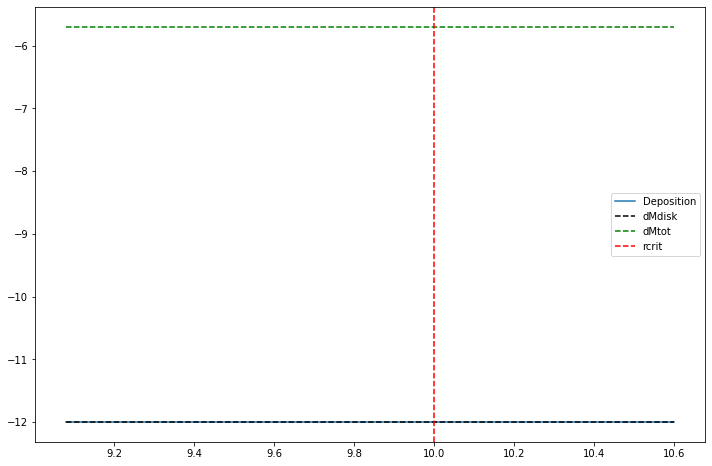

In [7]:
# # Mass deposition 
deposition_version = 'null'

if deposition_version == 0:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.loadtxt('M1dep.txt')

    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    Mdep_fixed = lgdM['g']
    dlgdM_fixed = dlgdM['g']
    n_roll = Mdep_fixed.shape[0]//4
    Mdep_fixed_rolled =np.roll(Mdep_fixed, n_roll)
    dlgdM_fixed_rolled = np.roll(dlgdM_fixed, n_roll)

    # Correct leftmost values too low from wrapping around
    Mdep_fixed_rolled[:n_roll] = Mdep_fixed[0]
    dlgdM_fixed_rolled[:n_roll] = 0. # Zero gradient for constant value correction

    ones = lgdM['g']/lgdM['g']

    constant = np.log(ones*1e-5)
    dconstant = 0.*ones

    lgdM['g'] = Mdep_fixed_rolled
    dlgdM['g'] = dlgdM_fixed_rolled

    

elif deposition_version == 1:
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

# elif deposition_version=='None':
#     lgdM = domain.new_field(name='lgdM')
#     lgdM['g'] = np.log(np.loadtxt('Deposition.txt')/Dep_0)
#     d_r = log_basis.Differentiate(lgdM)
#     dlgdM = d_r.evaluate()

elif deposition_version=='null':
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = X*0
    lgdM['g'] = lgdM['g']+np.log(dMdisk/Dep_0)
    print(np.log(dMdisk/Dep_0))
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()

else:
    location = 10 # in log10 
    smooth = 3
    X = r['g'] - np.log(10**location/r_0) 
    lgdM = domain.new_field(name='lgdM')
    lgdM['g'] = np.log((dMdisk + (dMtot-dMdisk)*((-erf(smooth*X) + 1)/2))/Dep_0)    
    # DEP = dMdisk + (dMtot-dMdisk)*((erf(smooth*eX['g']) + 1)/2)
    d_r = log_basis.Differentiate(lgdM)
    dlgdM = d_r.evaluate()
    
problem.parameters['lgDep'] = lgdM
problem.parameters['dlgDep'] = dlgdM

lgDep = domain.new_field(name='lgDep')
dlgDep = domain.new_field(name='dlgDep')
lgDep['g'] = lgdM['g']
dlgDep['g'] = dlgdM['g']

plt.figure(figsize=(12,8))
plt.plot(R, np.log10(np.exp(lgdM['g'])), label='Deposition')
plt.plot(R, np.log10(ones*dMdisk/Dep_0), 'k--', label='dMdisk')
plt.plot(R, np.log10(ones*dMtot/Dep_0), 'g--', label='dMtot')
if deposition_version != 1 and deposition_version !=0:
    plt.axvline(location, color = 'r', ls='--', label='rcrit')
plt.legend()
# plt.plot(R, np.log10(np.exp(dlgdM['g'])))

In [8]:
# Opacity

problem.substitutions['x'] = '2*pi*s*0.3/0.2898'
x = 2*pi*s*0.3/0.2898

# min(2,ex*T*T_0) 
k0 = -10. # -30.
problem.parameters['k0'] = k0

problem.substitutions['Qe'] = "(0.5*(2**k0 + (x*exp(lgT)*T_0)**k0))**(1/k0)"
Qe = (0.5*(2**k0 + (x*np.exp(lgT)*T_0)**k0))**(1/k0)

problem.substitutions['Qk_geo'] = "Qe*3/4*exp(lgZgr)/(s*rho_o)" 
Qk_geo = Qe*3/4*np.exp(lgZgr)/(s*rho_o)

k_gas_cst = 1e-8*(problem.parameters["mu"]/problem.parameters['kb'])**(2/3) # O(10^-14)
problem.parameters['k_gas_cst'] = k_gas_cst

problem.substitutions['k_gas'] = "k_gas_cst*(exp(lgT)*T_0)**(7/3)*(exp(lgP)*P_0)**(2/3)" 
k_gas = k_gas_cst*(np.exp(lgT)*T_0)**(7/3)*(np.exp(lgP)*P_0)**(2/3)

problem.substitutions['kappa'] = "k_gas + Qk_geo"
kappa = k_gas + Qk_geo 

In [9]:
# Gradient  


# problem.substitutions['grad_rad'] = "grad_rad_cst*kappa*exp(lgP)*P_0/(exp(lgT)*T_0)**4"

grad_ad = 0.28
problem.parameters['grad_ad'] = grad_ad


# problem.substitutions['grad_rad'] = '-3*kappa*exp(L)*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
problem.substitutions['grad_rad'] = '-3*kappa*L*L_0/(64*pi*sigma_b*gm) * exp(lgP)*P_0/(exp(lgT)*T_0)**4'
grad_rad = -3*kappa*L*L_0/(64*pi*sigma_b*gm) * np.exp(lgP)*P_0/(np.exp(lgT)*T_0)**4


# min
k1 = -10. # -30.
problem.parameters['k1'] = k1
problem.substitutions['grad'] = "(0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)" 
grad = (0.5*(grad_rad**k1 + (grad_ad)**k1))**(1/k1)

In [10]:
# Tstop: v_set = gm/r^2 * Tstop 

gm = problem.parameters['Mc']*problem.parameters['G']
problem.parameters['gm'] = gm

problem.substitutions['rho_g'] = '(exp(lgP)*P_0*mu)/(kb*exp(lgT)*T_0)'
rho_g = (np.exp(lgP)*P_0*mu)/(kb*np.exp(lgT)*T_0)

problem.substitutions['cg'] = 'sqrt(kb*exp(lgT)*T_0/mu)'
cg = np.sqrt(kb*np.exp(lgT)*T_0/mu)

problem.substitutions['Lg'] = '1e-9/rho_g'
Lg = 1e-9/rho_g

l = 30 #1 #15
problem.parameters['l'] = l

problem.substitutions['max'] = "(0.5*(1 + (s/Lg)**l))**(1/l)"
Max = (0.5*(1 + (s/Lg)**l))**(1/l)


problem.substitutions['Tstop'] = '(max*4*rho_o*s)/(9*cg*rho_g)'
Tstop = (Max*4*rho_o*s)/(9*cg*rho_g)

problem.substitutions['v_set'] = 'gm*Tstop/(exp(r)*r_0)**2'
v_set = gm*Tstop/(np.exp(r)*r_0)**2

In [11]:
# Tgrow 

problem.substitutions['v_bm'] = 'sqrt(16*kb*exp(lgT)*T_0/(pi*exp(lgM)*M_0))'
v_bm = np.sqrt(16*kb*np.exp(lgT)*T_0/(np.pi*np.exp(lgM)*M_0))

problem.substitutions['v_dd'] = '0.1*v_set'
v_dd = 0.1*v_set

problem.substitutions['Tgrow_inv'] = '3*exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)'
Tgrow_inv = 3*np.exp(lgZgr)*rho_g*(v_bm+v_dd)/(rho_o*s)

In [12]:
# Energy equation

# problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**2) * dlgDep * 1e5'
problem.substitutions['drho_dep'] = '-1/(4*pi*(exp(r)*r_0)**3) * dlgDep * Dep_0 * exp(lgDep)'
drho_dep = -1/(4*pi*(np.exp(r)*r_0)**3) * dlgDep * Dep_0 * np.exp(lgDep)

Trelax = 1e30
problem.parameters['Trelax'] = Trelax

Lcore = problem.parameters['gm']*problem.parameters['dMtot']/(r_inner*r_0)
problem.parameters['Lcore'] = Lcore
print(problem.parameters['Lcore'])

1.2578187571270345e+26


In [13]:
# New equations

problem.add_equation('lgZgr = log(exp(lgDep)*Dep_0/(4*pi*gm*Tstop*rho_g))')
# problem.add_equation('lgZgr = log(dMdep/(4*pi*gm*Tstop*rho_g))')
problem.add_equation('dr(lgM) = -Tgrow_inv*(exp(r)*r_0)**3/(gm*Tstop) + dlgDep*(mdep-exp(lgM)*M_0)/(exp(lgM)*M_0)')

In [14]:
# Normalized equations

# problem.parameters['eq1cst'] = -1*problem.parameters['G']*problem.parameters['Mc']*problem.parameters['mu']/(T_0*r_0*problem.parameters['kb'])
problem.add_equation('dr(m) = 4*pi*(exp(r)*r_0)**3 * rho_g/m_0')
problem.add_equation('exp(r) * dr(lgP) = -G*(Mc+m*m_0)*mu/(T_0*r_0*kb*exp(lgT))')
problem.add_equation('dr(lgT) = dr(lgP)*grad')

# problem.add_equation('dr(L) = 4*pi*(exp(r)*r_0)* (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0))')
# problem.add_equation('dr(L)*L_0 = 4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax )')
problem.add_equation('dr(L)*L_0 = (4*pi*(exp(r)*r_0)**3 * (G*(Mc+m*m_0)*drho_dep/(exp(r)*r_0) + rho_g*cg*(exp(lgT)*T_0 - Tdisk)/Trelax ))')


In [15]:
# Boundary Equations


problem.add_bc("right(lgT) = log(Tdisk/T_0)") # disk temp in kelvins
problem.add_bc("right(lgP) = log(rhodisk*kb*Tdisk/mu/P_0)") # gas law
problem.add_bc("right(lgZgr) = log(1e-3/30)")
problem.add_bc("left(m) = 0")
problem.add_bc("left(L) = Lcore/L_0")
# problem.add_bc("right(lgM) =log(1e-12*4*pi*rho_o/M_0/3)")

In [16]:
# solver = problem.build_solver(de.timesteppers.RK443)
solver = problem.build_solver()

2020-12-06 05:19:40,535 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 4.3e+01/s


Text(0.5, 1.0, 'm')

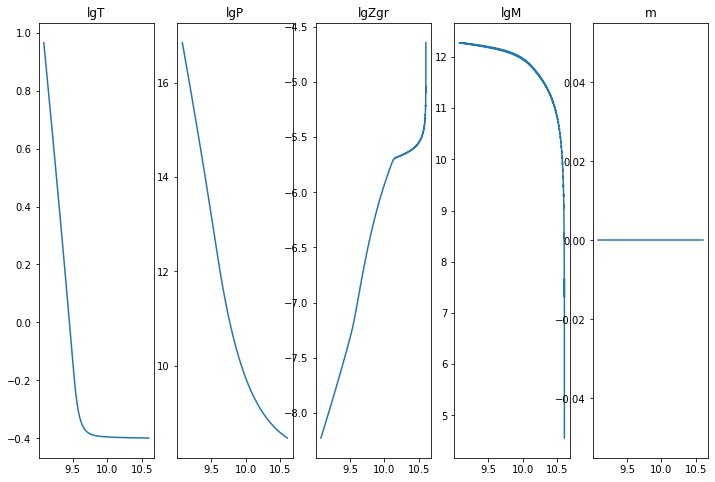

In [17]:
# initial conditions and referencing local grid state fields

lgr = domain.grid(0)
Rscale = np.log10(np.exp(domain.grid(0))*r_0)
lgT1 = solver.state['lgT']
lgP1 = solver.state['lgP']
lgZgr1 = solver.state['lgZgr']
lgM1 = solver.state['lgM']

L1 = solver.state['L']
m1= solver.state['m']

# Load from constant Mass and Zgr version

lgP_initial = np.loadtxt("Pressure.txt")
lgT_initial = np.loadtxt("Temperature.txt")
Zi = np.loadtxt('Zgr.txt')
Mi = np.loadtxt('M.txt')

lgP1['g'] = lgP_initial
lgT1['g'] = lgT_initial
ones = lgT1['g']/lgT1['g']

L1['g'] = ones*problem.parameters['Lcore']/L_0

lgZgr1['g'] = Zi 

lgM1['g'] = Mi
m1['g'] = ones*0


if load_dep: 
    lgP1['g'] = np.loadtxt("NPressure_dep.txt")
    lgT1['g'] = np.loadtxt("NTemperature_dep.txt")
    L1['g'] = np.loadtxt('NL_dep.txt')
    lgZgr1['g'] = np.loadtxt('NZgr_dep.txt') 
    lgM1['g'] = np.loadtxt('NM_dep.txt')
    m1['g'] = np.loadtxt('Nm_dep.txt')
    
    
plt.figure(figsize=(12,8))
plt.subplot(1,5,1)
plt.plot(Rscale,lgT1['g'])
plt.title("lgT")
plt.subplot(1,5,2)
plt.plot(Rscale, lgP1['g'])
plt.title("lgP")
plt.subplot(1,5,3)
plt.plot(Rscale, np.log10(np.exp(lgZgr1['g'])))
plt.title("lgZgr")
plt.subplot(1,5,4)
plt.plot(Rscale, lgM1['g'])
plt.title("lgM")
plt.subplot(1,5,5)
plt.plot(Rscale, m1['g'])
plt.title("m")

In [18]:

lgT_list = [np.copy(lgT1['g'])]
lgP_list = [np.copy(lgP1['g'])]
lgZgr_list = [np.copy(lgZgr1['g'])]
lgM_list = [np.copy(lgM1['g'])]
m_list = [np.copy(m1['g'])]
L_list = [np.copy(L1['g'])]

2020-12-06 05:19:45,082 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:19:46,136 __main__ 0/1 INFO :: Perturbation norm: 9.515185095645169
2020-12-06 05:19:46,138 __main__ 0/1 INFO :: lgT iterate: 0.9656715024150658
2020-12-06 05:19:46,139 __main__ 0/1 INFO :: lgP iterate: 16.851299062473398
2020-12-06 05:19:46,140 __main__ 0/1 INFO :: lgM iterate: 12.306662560893677
2020-12-06 05:19:46,140 __main__ 0/1 INFO :: lgZgr iterate: -18.96458115562311
2020-12-06 05:19:46,142 __main__ 0/1 INFO :: m iterate: 1.6114009250056682e-05
2020-12-06 05:19:46,143 __main__ 0/1 INFO :: L iterate: 0.039999999999999813


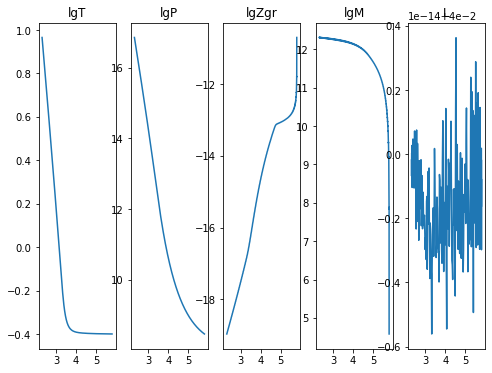

2020-12-06 05:19:49,859 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:19:51,143 __main__ 0/1 INFO :: Perturbation norm: 1.672072136282425
2020-12-06 05:19:51,144 __main__ 0/1 INFO :: lgT iterate: 0.965684908066512
2020-12-06 05:19:51,145 __main__ 0/1 INFO :: lgP iterate: 16.850329433800283
2020-12-06 05:19:51,146 __main__ 0/1 INFO :: lgM iterate: 12.278414434236709
2020-12-06 05:19:51,146 __main__ 0/1 INFO :: lgZgr iterate: -18.944752328821284
2020-12-06 05:19:51,147 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:19:51,148 __main__ 0/1 INFO :: L iterate: 0.04


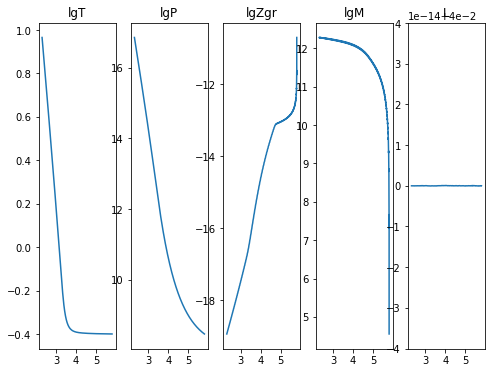

2020-12-06 05:19:55,658 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-12-06 05:19:56,644 __main__ 0/1 INFO :: Perturbation norm: 1.6720751634869582
2020-12-06 05:19:56,645 __main__ 0/1 INFO :: lgT iterate: 0.9656716251227181
2020-12-06 05:19:56,646 __main__ 0/1 INFO :: lgP iterate: 16.851299471184603
2020-12-06 05:19:56,646 __main__ 0/1 INFO :: lgM iterate: 12.306662613781464
2020-12-06 05:19:56,647 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415530105
2020-12-06 05:19:56,648 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:19:56,649 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


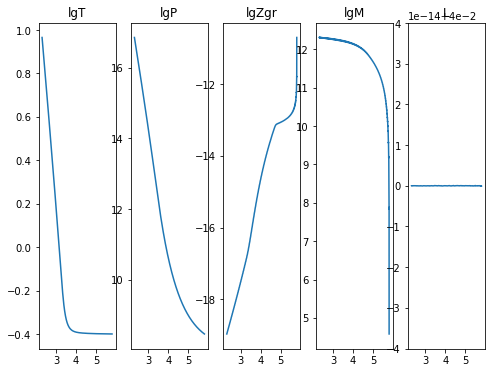

2020-12-06 05:20:00,627 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:20:01,776 __main__ 0/1 INFO :: Perturbation norm: 1.6720751662150442
2020-12-06 05:20:01,777 __main__ 0/1 INFO :: lgT iterate: 0.965684908089584
2020-12-06 05:20:01,778 __main__ 0/1 INFO :: lgP iterate: 16.850329433869767
2020-12-06 05:20:01,779 __main__ 0/1 INFO :: lgM iterate: 12.278414437379165
2020-12-06 05:20:01,779 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233095204
2020-12-06 05:20:01,780 __main__ 0/1 INFO :: m iterate: 1.6098110155127188e-05
2020-12-06 05:20:01,781 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


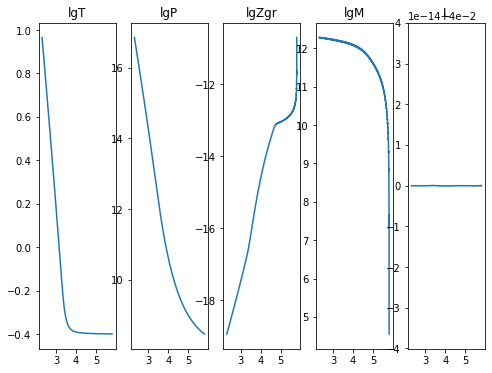

2020-12-06 05:20:05,720 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-12-06 05:20:07,249 __main__ 0/1 INFO :: Perturbation norm: 1.6720751570110495
2020-12-06 05:20:07,250 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234436
2020-12-06 05:20:07,251 __main__ 0/1 INFO :: lgP iterate: 16.851299471163962
2020-12-06 05:20:07,252 __main__ 0/1 INFO :: lgM iterate: 12.306662612963123
2020-12-06 05:20:07,252 __main__ 0/1 INFO :: lgZgr iterate: -18.964581414962716
2020-12-06 05:20:07,253 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:20:07,254 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


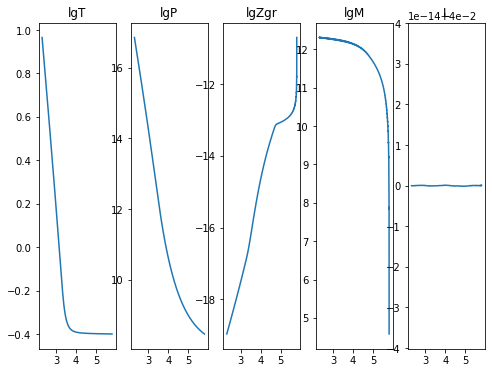

2020-12-06 05:20:12,216 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:20:13,339 __main__ 0/1 INFO :: Perturbation norm: 1.672075150692632
2020-12-06 05:20:13,341 __main__ 0/1 INFO :: lgT iterate: 0.9656849080895052
2020-12-06 05:20:13,342 __main__ 0/1 INFO :: lgP iterate: 16.85032943387732
2020-12-06 05:20:13,343 __main__ 0/1 INFO :: lgM iterate: 12.278414437693431
2020-12-06 05:20:13,343 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233116933
2020-12-06 05:20:13,344 __main__ 0/1 INFO :: m iterate: 1.60981101546831e-05
2020-12-06 05:20:13,345 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


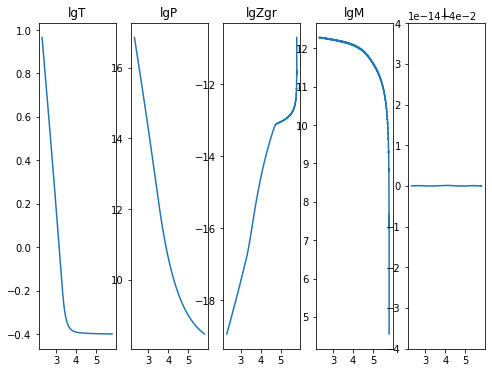

2020-12-06 05:20:17,325 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:20:18,458 __main__ 0/1 INFO :: Perturbation norm: 1.672075150054738
2020-12-06 05:20:18,459 __main__ 0/1 INFO :: lgT iterate: 0.9656716251233896
2020-12-06 05:20:18,460 __main__ 0/1 INFO :: lgP iterate: 16.851299471167863
2020-12-06 05:20:18,461 __main__ 0/1 INFO :: lgM iterate: 12.306662613126157
2020-12-06 05:20:18,461 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141507538
2020-12-06 05:20:18,462 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:20:18,463 __main__ 0/1 INFO :: L iterate: 0.04


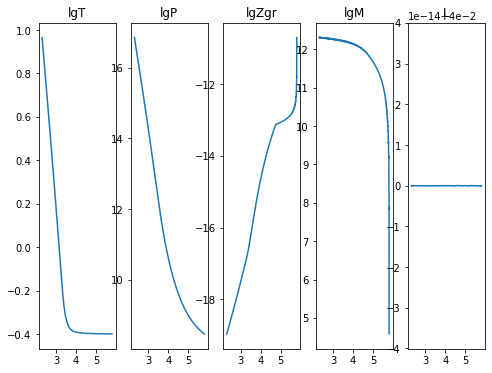

2020-12-06 05:20:23,965 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.5e+00/s
2020-12-06 05:20:25,001 __main__ 0/1 INFO :: Perturbation norm: 1.6720751486231245
2020-12-06 05:20:25,002 __main__ 0/1 INFO :: lgT iterate: 0.9656849080895009
2020-12-06 05:20:25,003 __main__ 0/1 INFO :: lgP iterate: 16.850329433877967
2020-12-06 05:20:25,004 __main__ 0/1 INFO :: lgM iterate: 12.278414437695021
2020-12-06 05:20:25,005 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331171046
2020-12-06 05:20:25,006 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:20:25,007 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


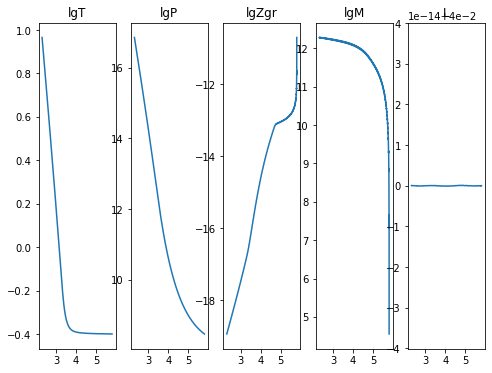

2020-12-06 05:20:29,194 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.6e+00/s
2020-12-06 05:20:30,443 __main__ 0/1 INFO :: Perturbation norm: 1.6720751485953613
2020-12-06 05:20:30,444 __main__ 0/1 INFO :: lgT iterate: 0.9656716251233953
2020-12-06 05:20:30,445 __main__ 0/1 INFO :: lgP iterate: 16.851299471167827
2020-12-06 05:20:30,446 __main__ 0/1 INFO :: lgM iterate: 12.306662613123677
2020-12-06 05:20:30,447 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415073674
2020-12-06 05:20:30,448 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-12-06 05:20:30,449 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


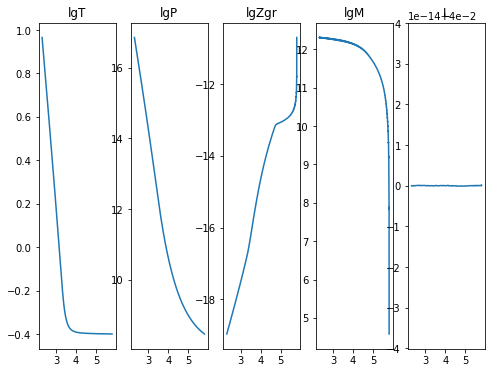

2020-12-06 05:20:35,125 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:20:36,399 __main__ 0/1 INFO :: Perturbation norm: 1.6720751483442906
2020-12-06 05:20:36,401 __main__ 0/1 INFO :: lgT iterate: 0.965684908089499
2020-12-06 05:20:36,402 __main__ 0/1 INFO :: lgP iterate: 16.850329433878144
2020-12-06 05:20:36,402 __main__ 0/1 INFO :: lgM iterate: 12.278414437701125
2020-12-06 05:20:36,403 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331175298
2020-12-06 05:20:36,404 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:20:36,405 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


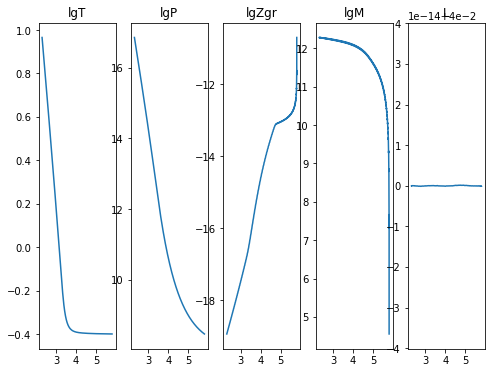

2020-12-06 05:20:41,404 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-12-06 05:20:42,637 __main__ 0/1 INFO :: Perturbation norm: 1.6720751480589326
2020-12-06 05:20:42,638 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234008
2020-12-06 05:20:42,639 __main__ 0/1 INFO :: lgP iterate: 16.85129947116736
2020-12-06 05:20:42,640 __main__ 0/1 INFO :: lgM iterate: 12.306662613109937
2020-12-06 05:20:42,641 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415064043
2020-12-06 05:20:42,642 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:20:42,643 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


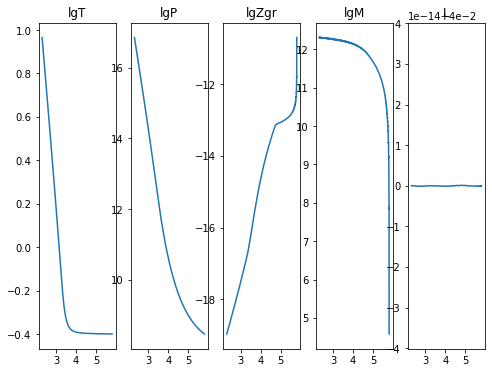

2020-12-06 05:20:47,655 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-12-06 05:20:48,713 __main__ 0/1 INFO :: Perturbation norm: 1.6720751478288916
2020-12-06 05:20:48,714 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894971
2020-12-06 05:20:48,715 __main__ 0/1 INFO :: lgP iterate: 16.850329433878343
2020-12-06 05:20:48,715 __main__ 0/1 INFO :: lgM iterate: 12.278414437709024
2020-12-06 05:20:48,716 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118077
2020-12-06 05:20:48,717 __main__ 0/1 INFO :: m iterate: 1.6098110155127188e-05
2020-12-06 05:20:48,718 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


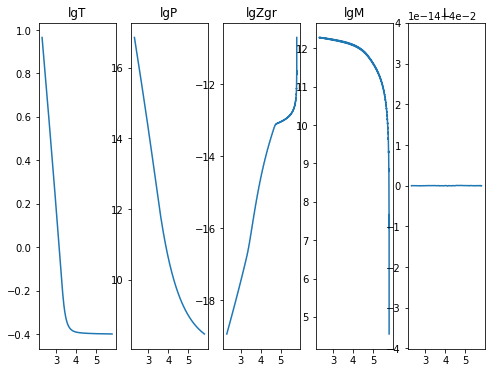

2020-12-06 05:20:52,757 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:20:53,956 __main__ 0/1 INFO :: Perturbation norm: 1.672075147707613
2020-12-06 05:20:53,957 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234018
2020-12-06 05:20:53,958 __main__ 0/1 INFO :: lgP iterate: 16.851299471167312
2020-12-06 05:20:53,958 __main__ 0/1 INFO :: lgM iterate: 12.306662613109642
2020-12-06 05:20:53,959 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063794
2020-12-06 05:20:53,960 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:20:53,960 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


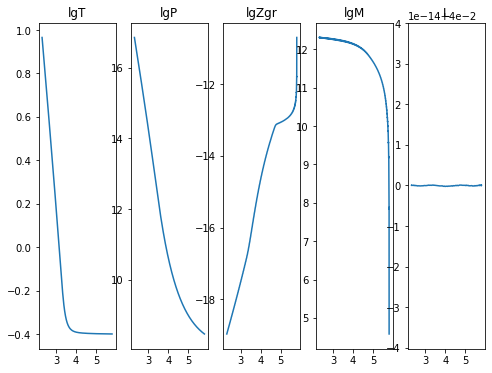

2020-12-06 05:20:57,856 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:20:58,859 __main__ 0/1 INFO :: Perturbation norm: 1.6720751475935642
2020-12-06 05:20:58,860 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894944
2020-12-06 05:20:58,861 __main__ 0/1 INFO :: lgP iterate: 16.85032943387842
2020-12-06 05:20:58,861 __main__ 0/1 INFO :: lgM iterate: 12.278414437711326
2020-12-06 05:20:58,862 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331182382
2020-12-06 05:20:58,863 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:20:58,864 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


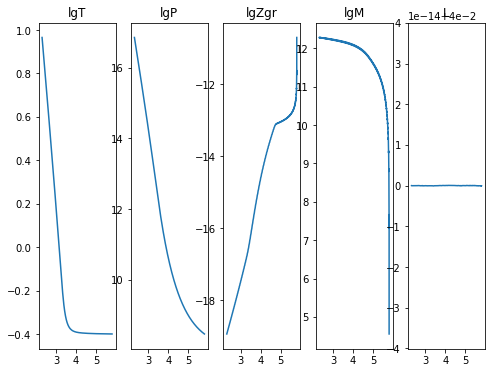

2020-12-06 05:21:02,443 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:21:03,471 __main__ 0/1 INFO :: Perturbation norm: 1.6720751475606492
2020-12-06 05:21:03,473 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:21:03,473 __main__ 0/1 INFO :: lgP iterate: 16.851299471167298
2020-12-06 05:21:03,474 __main__ 0/1 INFO :: lgM iterate: 12.306662613109783
2020-12-06 05:21:03,475 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063883
2020-12-06 05:21:03,475 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:21:03,476 __main__ 0/1 INFO :: L iterate: 0.04


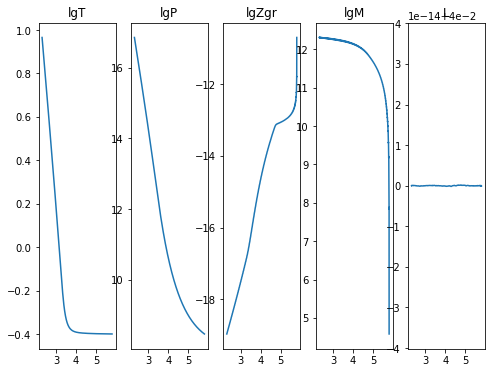

2020-12-06 05:21:07,077 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:21:08,102 __main__ 0/1 INFO :: Perturbation norm: 1.67207514752221
2020-12-06 05:21:08,103 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894953
2020-12-06 05:21:08,104 __main__ 0/1 INFO :: lgP iterate: 16.850329433878443
2020-12-06 05:21:08,105 __main__ 0/1 INFO :: lgM iterate: 12.278414437711918
2020-12-06 05:21:08,105 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331182794
2020-12-06 05:21:08,106 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:21:08,107 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


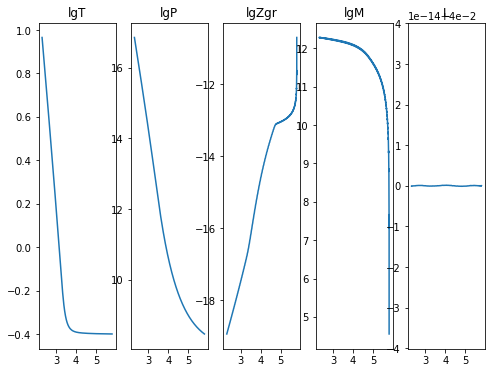

2020-12-06 05:21:11,714 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:21:12,716 __main__ 0/1 INFO :: Perturbation norm: 1.6720751475054525
2020-12-06 05:21:12,718 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:21:12,718 __main__ 0/1 INFO :: lgP iterate: 16.851299471167284
2020-12-06 05:21:12,719 __main__ 0/1 INFO :: lgM iterate: 12.30666261310941
2020-12-06 05:21:12,720 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063613
2020-12-06 05:21:12,721 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:21:12,722 __main__ 0/1 INFO :: L iterate: 0.04


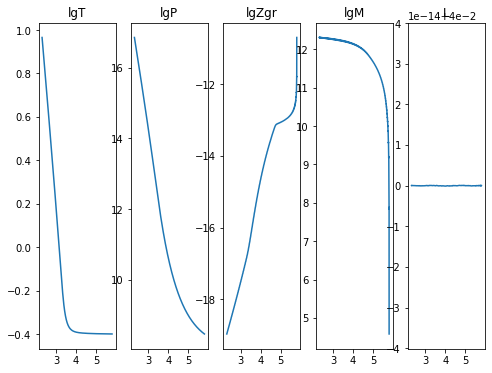

2020-12-06 05:21:16,620 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:21:17,645 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474887423
2020-12-06 05:21:17,646 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-12-06 05:21:17,647 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:21:17,648 __main__ 0/1 INFO :: lgM iterate: 12.278414437712222
2020-12-06 05:21:17,648 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183018
2020-12-06 05:21:17,649 __main__ 0/1 INFO :: m iterate: 1.6098110155127188e-05
2020-12-06 05:21:17,650 __main__ 0/1 INFO :: L iterate: 0.04


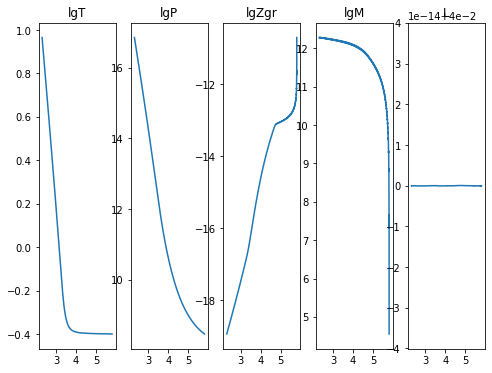

2020-12-06 05:21:23,334 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-12-06 05:21:24,877 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474808269
2020-12-06 05:21:24,878 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234065
2020-12-06 05:21:24,879 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:21:24,880 __main__ 0/1 INFO :: lgM iterate: 12.306662613109186
2020-12-06 05:21:24,881 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063453
2020-12-06 05:21:24,882 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:21:24,883 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


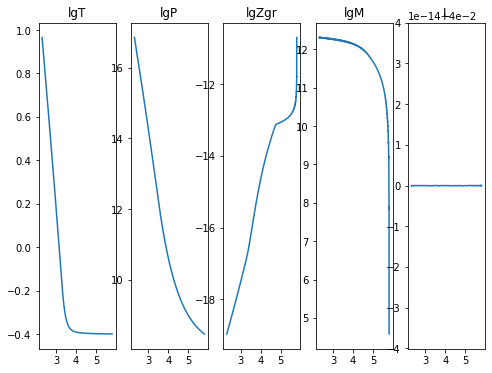

2020-12-06 05:21:30,314 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-12-06 05:21:31,603 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474733317
2020-12-06 05:21:31,608 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:21:31,609 __main__ 0/1 INFO :: lgP iterate: 16.85032943387845
2020-12-06 05:21:31,610 __main__ 0/1 INFO :: lgM iterate: 12.278414437712684
2020-12-06 05:21:31,611 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183324
2020-12-06 05:21:31,612 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:21:31,612 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


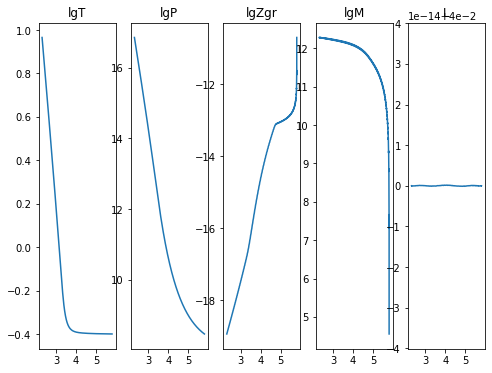

2020-12-06 05:21:35,687 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:21:37,310 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474700728
2020-12-06 05:21:37,312 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:21:37,313 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:21:37,313 __main__ 0/1 INFO :: lgM iterate: 12.306662613109275
2020-12-06 05:21:37,314 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063513
2020-12-06 05:21:37,318 __main__ 0/1 INFO :: m iterate: 1.611401383661004e-05
2020-12-06 05:21:37,319 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


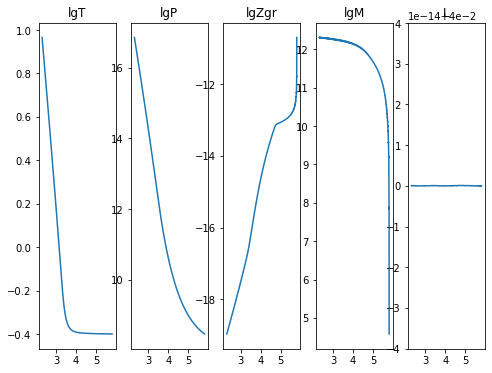

2020-12-06 05:21:42,535 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-12-06 05:21:44,051 __main__ 0/1 INFO :: Perturbation norm: 1.672075147466675
2020-12-06 05:21:44,053 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894951
2020-12-06 05:21:44,054 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-12-06 05:21:44,055 __main__ 0/1 INFO :: lgM iterate: 12.278414437712662
2020-12-06 05:21:44,055 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:21:44,057 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-12-06 05:21:44,058 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


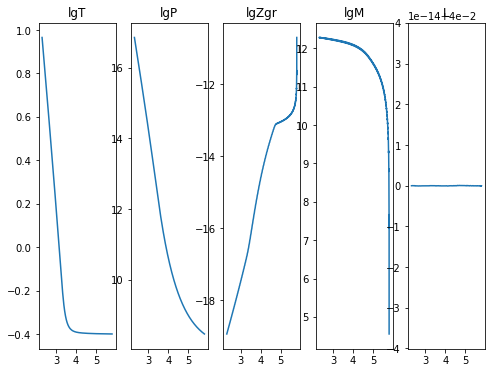

2020-12-06 05:21:48,496 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-12-06 05:21:50,145 __main__ 0/1 INFO :: Perturbation norm: 1.672075147464969
2020-12-06 05:21:50,146 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234025
2020-12-06 05:21:50,147 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:21:50,148 __main__ 0/1 INFO :: lgM iterate: 12.30666261310919
2020-12-06 05:21:50,149 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:21:50,150 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:21:50,151 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


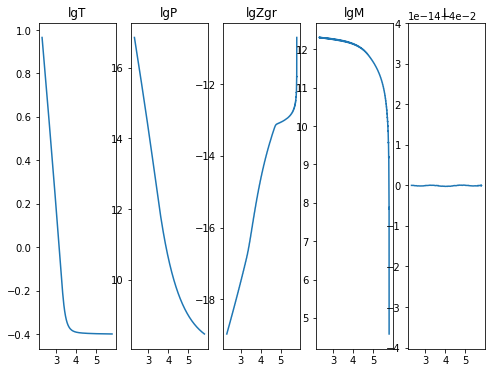

2020-12-06 05:21:54,158 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:21:55,190 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474634588
2020-12-06 05:21:55,191 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894938
2020-12-06 05:21:55,192 __main__ 0/1 INFO :: lgP iterate: 16.850329433878454
2020-12-06 05:21:55,193 __main__ 0/1 INFO :: lgM iterate: 12.278414437712634
2020-12-06 05:21:55,193 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118329
2020-12-06 05:21:55,194 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:21:55,195 __main__ 0/1 INFO :: L iterate: 0.04


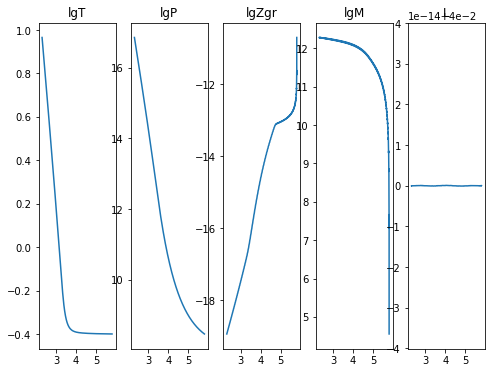

2020-12-06 05:21:59,297 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-12-06 05:22:00,621 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474631776
2020-12-06 05:22:00,622 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-12-06 05:22:00,623 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:22:00,624 __main__ 0/1 INFO :: lgM iterate: 12.306662613109111
2020-12-06 05:22:00,625 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063407
2020-12-06 05:22:00,626 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:22:00,627 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


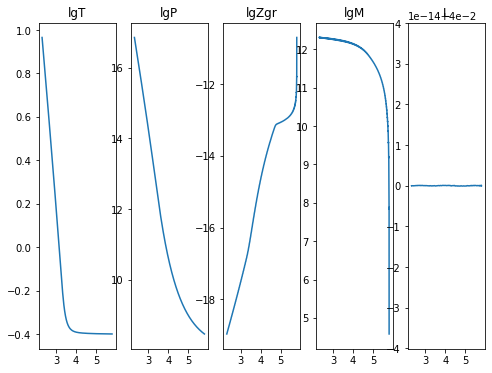

2020-12-06 05:22:05,031 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-12-06 05:22:06,448 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462918
2020-12-06 05:22:06,451 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894961
2020-12-06 05:22:06,452 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:22:06,453 __main__ 0/1 INFO :: lgM iterate: 12.278414437712598
2020-12-06 05:22:06,454 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183267
2020-12-06 05:22:06,455 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:22:06,456 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


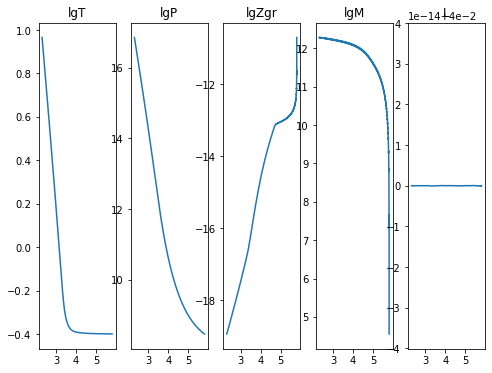

2020-12-06 05:22:11,421 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.8e+00/s
2020-12-06 05:22:12,624 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462801
2020-12-06 05:22:12,626 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-12-06 05:22:12,627 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:22:12,628 __main__ 0/1 INFO :: lgM iterate: 12.306662613109118
2020-12-06 05:22:12,629 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063407
2020-12-06 05:22:12,630 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:22:12,632 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


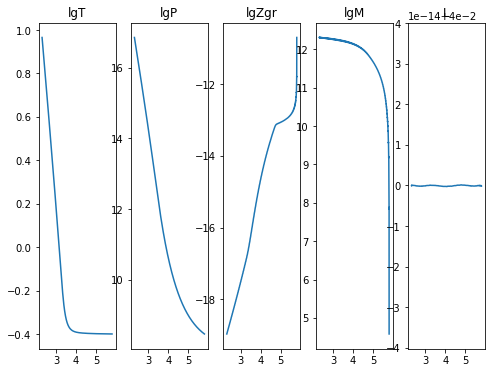

2020-12-06 05:22:17,266 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-12-06 05:22:18,435 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462593
2020-12-06 05:22:18,436 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-12-06 05:22:18,437 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:22:18,438 __main__ 0/1 INFO :: lgM iterate: 12.27841443771268
2020-12-06 05:22:18,439 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183324
2020-12-06 05:22:18,440 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:22:18,441 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


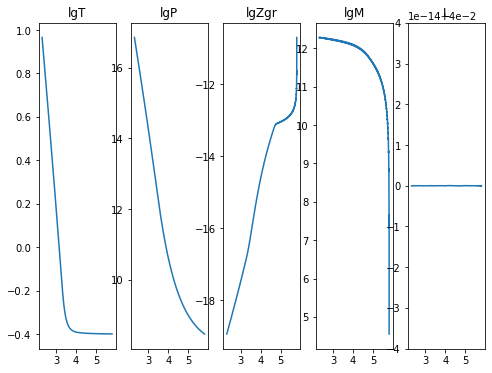

2020-12-06 05:22:21,940 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:22:23,102 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623632
2020-12-06 05:22:23,103 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:22:23,104 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:22:23,105 __main__ 0/1 INFO :: lgM iterate: 12.306662613109166
2020-12-06 05:22:23,106 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-12-06 05:22:23,107 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-12-06 05:22:23,108 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


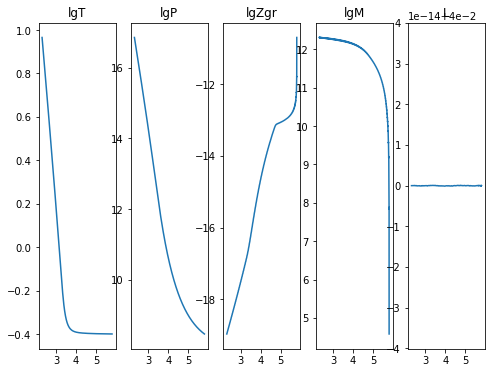

2020-12-06 05:22:26,821 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:22:27,794 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621094
2020-12-06 05:22:27,795 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894959
2020-12-06 05:22:27,796 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:22:27,797 __main__ 0/1 INFO :: lgM iterate: 12.278414437712643
2020-12-06 05:22:27,798 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-12-06 05:22:27,799 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:22:27,800 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


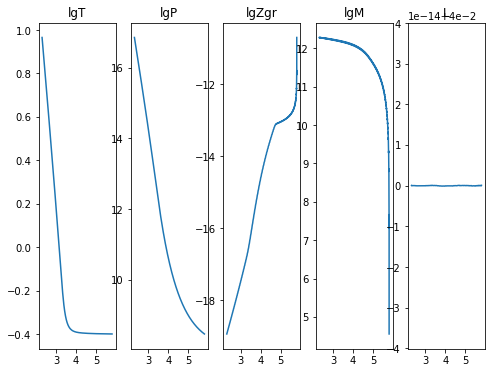

2020-12-06 05:22:31,314 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:22:32,354 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462237
2020-12-06 05:22:32,355 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234025
2020-12-06 05:22:32,356 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-12-06 05:22:32,357 __main__ 0/1 INFO :: lgM iterate: 12.306662613109093
2020-12-06 05:22:32,358 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063392
2020-12-06 05:22:32,359 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-12-06 05:22:32,360 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


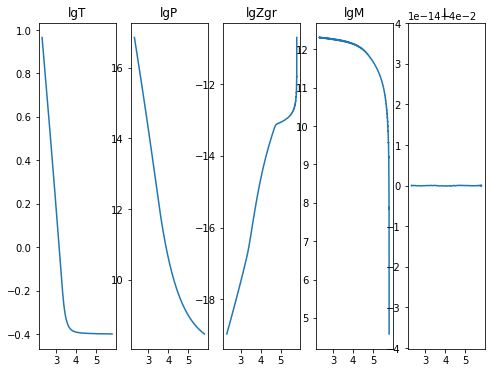

2020-12-06 05:22:35,890 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:22:36,857 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462274
2020-12-06 05:22:36,858 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894938
2020-12-06 05:22:36,859 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:22:36,859 __main__ 0/1 INFO :: lgM iterate: 12.2784144377128
2020-12-06 05:22:36,860 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118341
2020-12-06 05:22:36,861 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:22:36,862 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


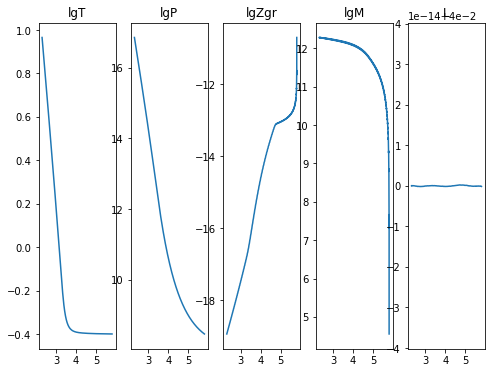

2020-12-06 05:22:40,324 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:22:41,289 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620608
2020-12-06 05:22:41,291 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234034
2020-12-06 05:22:41,291 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:22:41,292 __main__ 0/1 INFO :: lgM iterate: 12.306662613109204
2020-12-06 05:22:41,293 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:22:41,294 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:22:41,295 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


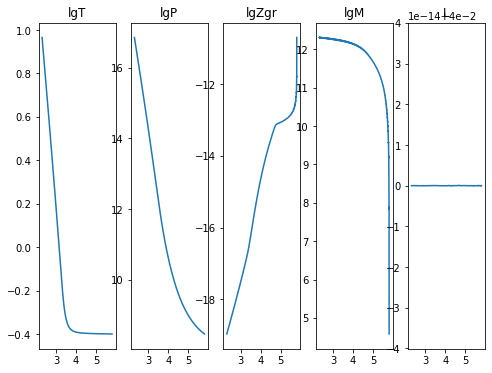

2020-12-06 05:22:44,833 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:22:45,819 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619935
2020-12-06 05:22:45,820 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-12-06 05:22:45,821 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:22:45,822 __main__ 0/1 INFO :: lgM iterate: 12.278414437712675
2020-12-06 05:22:45,823 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183327
2020-12-06 05:22:45,824 __main__ 0/1 INFO :: m iterate: 1.6098110162232615e-05
2020-12-06 05:22:45,825 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


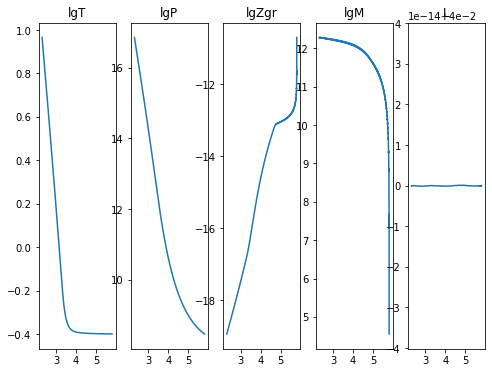

2020-12-06 05:22:49,778 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:22:50,735 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746215
2020-12-06 05:22:50,736 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-12-06 05:22:50,737 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:22:50,738 __main__ 0/1 INFO :: lgM iterate: 12.306662613109197
2020-12-06 05:22:50,739 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063467
2020-12-06 05:22:50,740 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:22:50,741 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


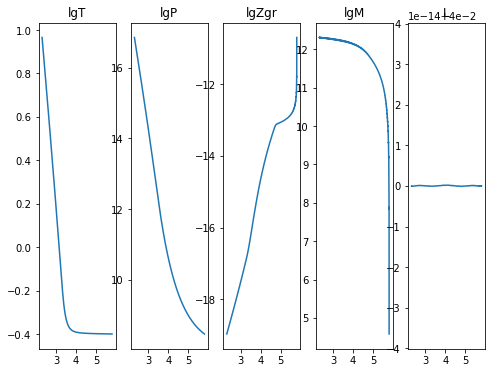

2020-12-06 05:22:54,763 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:22:55,820 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746219
2020-12-06 05:22:55,821 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894973
2020-12-06 05:22:55,821 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:22:55,822 __main__ 0/1 INFO :: lgM iterate: 12.278414437712634
2020-12-06 05:22:55,823 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-12-06 05:22:55,824 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-12-06 05:22:55,825 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


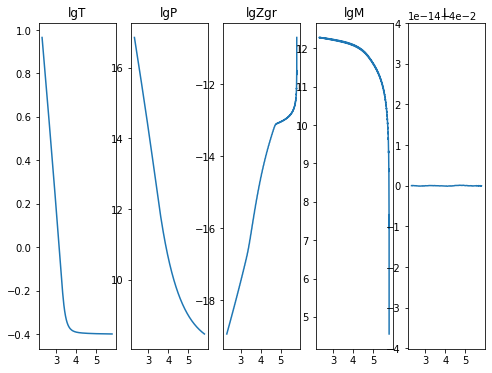

2020-12-06 05:22:59,171 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.9e+00/s
2020-12-06 05:23:00,157 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618398
2020-12-06 05:23:00,158 __main__ 0/1 INFO :: lgT iterate: 0.965671625123404
2020-12-06 05:23:00,159 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-12-06 05:23:00,159 __main__ 0/1 INFO :: lgM iterate: 12.30666261310912
2020-12-06 05:23:00,160 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-12-06 05:23:00,161 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:23:00,162 __main__ 0/1 INFO :: L iterate: 0.04


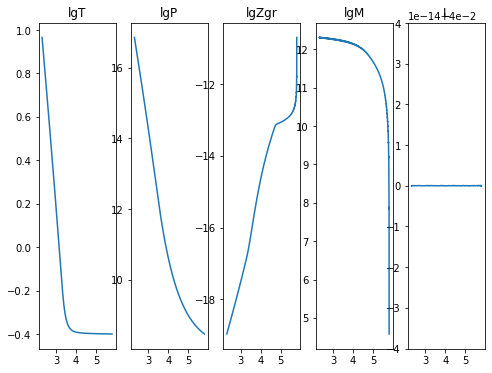

2020-12-06 05:23:03,598 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:23:04,558 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614184
2020-12-06 05:23:04,559 __main__ 0/1 INFO :: lgT iterate: 0.965684908089495
2020-12-06 05:23:04,560 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:23:04,561 __main__ 0/1 INFO :: lgM iterate: 12.278414437712694
2020-12-06 05:23:04,562 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183334
2020-12-06 05:23:04,563 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:23:04,563 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


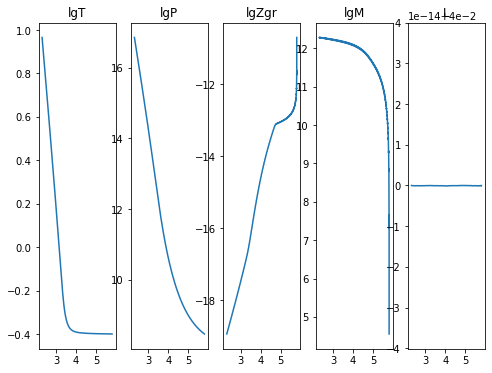

2020-12-06 05:23:07,939 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-12-06 05:23:08,910 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746122
2020-12-06 05:23:08,911 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:23:08,912 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:23:08,913 __main__ 0/1 INFO :: lgM iterate: 12.30666261310913
2020-12-06 05:23:08,913 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-12-06 05:23:08,914 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:23:08,915 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


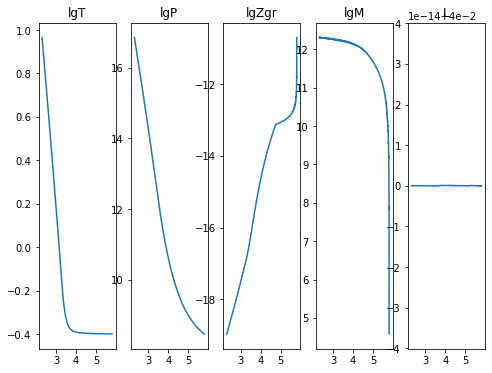

2020-12-06 05:23:12,249 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.8e+00/s
2020-12-06 05:23:13,238 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474610502
2020-12-06 05:23:13,239 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894951
2020-12-06 05:23:13,240 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:23:13,241 __main__ 0/1 INFO :: lgM iterate: 12.278414437712694
2020-12-06 05:23:13,242 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183334
2020-12-06 05:23:13,243 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:23:13,243 __main__ 0/1 INFO :: L iterate: 0.04000000000000005


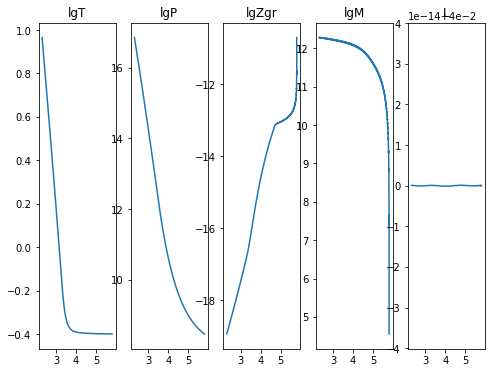

2020-12-06 05:23:16,883 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:23:18,076 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615971
2020-12-06 05:23:18,077 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:23:18,078 __main__ 0/1 INFO :: lgP iterate: 16.851299471167266
2020-12-06 05:23:18,079 __main__ 0/1 INFO :: lgM iterate: 12.306662613109193
2020-12-06 05:23:18,080 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063453
2020-12-06 05:23:18,081 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:23:18,082 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


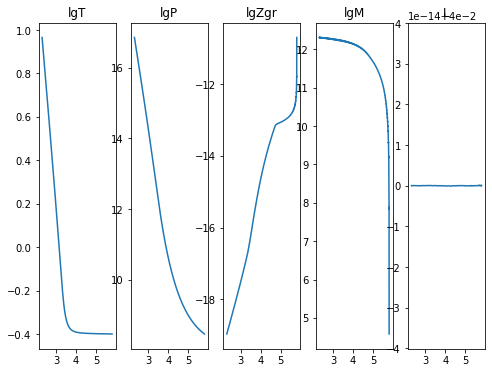

2020-12-06 05:23:21,898 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:23:22,982 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619926
2020-12-06 05:23:22,983 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894937
2020-12-06 05:23:22,984 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:23:22,984 __main__ 0/1 INFO :: lgM iterate: 12.278414437712573
2020-12-06 05:23:22,985 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183253
2020-12-06 05:23:22,986 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:23:22,987 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


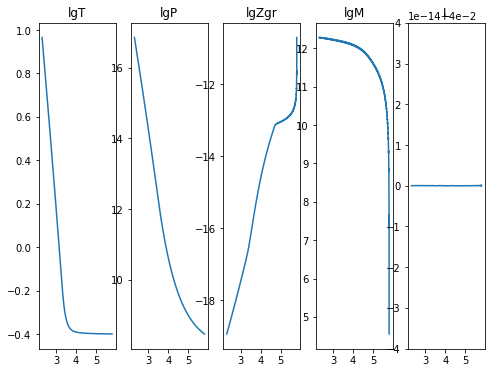

2020-12-06 05:23:26,634 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:23:27,683 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618922
2020-12-06 05:23:27,684 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234042
2020-12-06 05:23:27,685 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:23:27,685 __main__ 0/1 INFO :: lgM iterate: 12.306662613109191
2020-12-06 05:23:27,686 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506345
2020-12-06 05:23:27,687 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:23:27,688 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


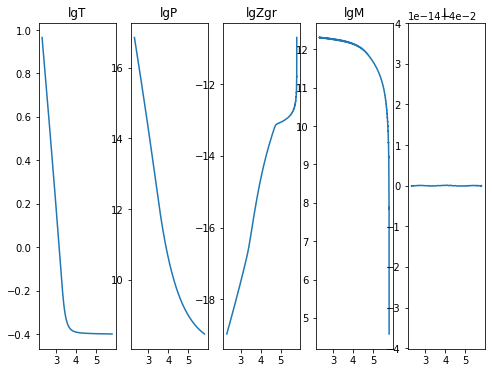

2020-12-06 05:23:31,323 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:23:32,395 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619222
2020-12-06 05:23:32,396 __main__ 0/1 INFO :: lgT iterate: 0.965684908089496
2020-12-06 05:23:32,397 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:23:32,398 __main__ 0/1 INFO :: lgM iterate: 12.278414437712623
2020-12-06 05:23:32,399 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-12-06 05:23:32,400 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:23:32,401 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


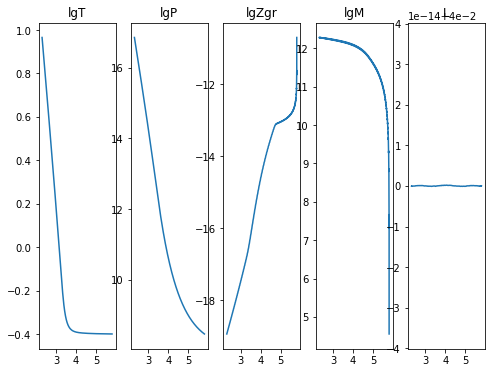

2020-12-06 05:23:36,005 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:23:37,110 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619757
2020-12-06 05:23:37,111 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234052
2020-12-06 05:23:37,112 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:23:37,113 __main__ 0/1 INFO :: lgM iterate: 12.30666261310908
2020-12-06 05:23:37,113 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063382
2020-12-06 05:23:37,114 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:23:37,115 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


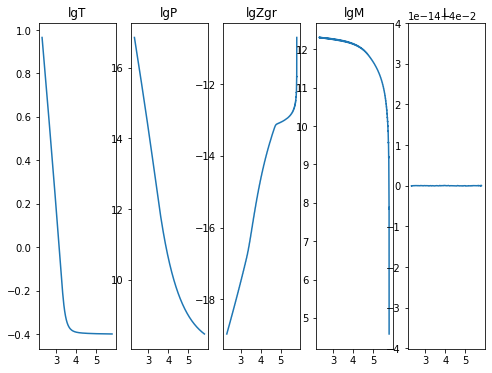

2020-12-06 05:23:40,823 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:23:41,900 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620164
2020-12-06 05:23:41,901 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894941
2020-12-06 05:23:41,902 __main__ 0/1 INFO :: lgP iterate: 16.85032943387845
2020-12-06 05:23:41,903 __main__ 0/1 INFO :: lgM iterate: 12.278414437712616
2020-12-06 05:23:41,904 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-12-06 05:23:41,905 __main__ 0/1 INFO :: m iterate: 1.6098110156015366e-05
2020-12-06 05:23:41,906 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


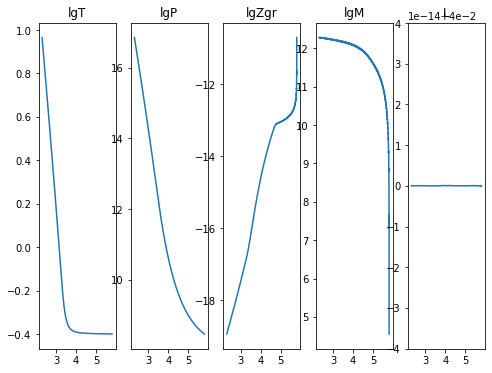

2020-12-06 05:23:45,536 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:23:46,652 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461674
2020-12-06 05:23:46,653 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234033
2020-12-06 05:23:46,654 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:23:46,654 __main__ 0/1 INFO :: lgM iterate: 12.306662613109097
2020-12-06 05:23:46,655 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506339
2020-12-06 05:23:46,656 __main__ 0/1 INFO :: m iterate: 1.611401383661004e-05
2020-12-06 05:23:46,657 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


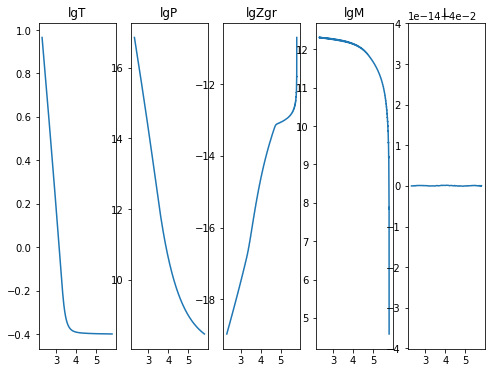

2020-12-06 05:23:50,301 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:23:51,358 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461472
2020-12-06 05:23:51,359 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-12-06 05:23:51,360 __main__ 0/1 INFO :: lgP iterate: 16.85032943387847
2020-12-06 05:23:51,361 __main__ 0/1 INFO :: lgM iterate: 12.278414437712637
2020-12-06 05:23:51,362 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-12-06 05:23:51,363 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:23:51,364 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


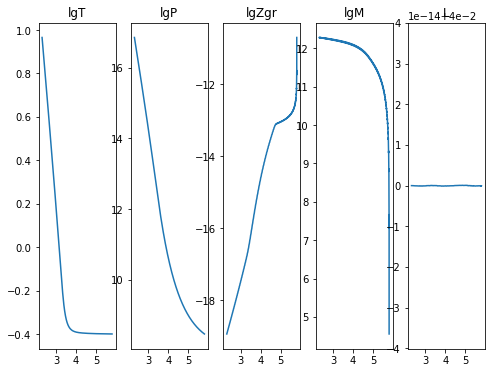

2020-12-06 05:23:55,800 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-12-06 05:23:57,105 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615674
2020-12-06 05:23:57,106 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234042
2020-12-06 05:23:57,106 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:23:57,107 __main__ 0/1 INFO :: lgM iterate: 12.306662613109102
2020-12-06 05:23:57,108 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-12-06 05:23:57,108 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-12-06 05:23:57,109 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


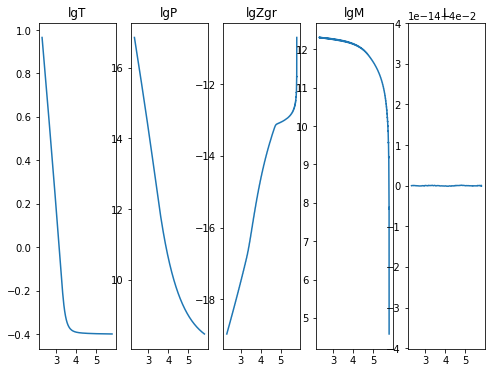

2020-12-06 05:24:02,191 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-12-06 05:24:03,487 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616398
2020-12-06 05:24:03,488 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:24:03,489 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:24:03,490 __main__ 0/1 INFO :: lgM iterate: 12.278414437712726
2020-12-06 05:24:03,490 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183356
2020-12-06 05:24:03,491 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:24:03,492 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


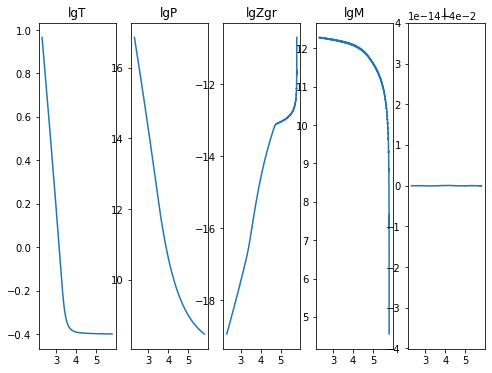

2020-12-06 05:24:07,790 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:24:09,050 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621485
2020-12-06 05:24:09,051 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234019
2020-12-06 05:24:09,052 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:24:09,053 __main__ 0/1 INFO :: lgM iterate: 12.306662613109062
2020-12-06 05:24:09,055 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506337
2020-12-06 05:24:09,057 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:24:09,058 __main__ 0/1 INFO :: L iterate: 0.04


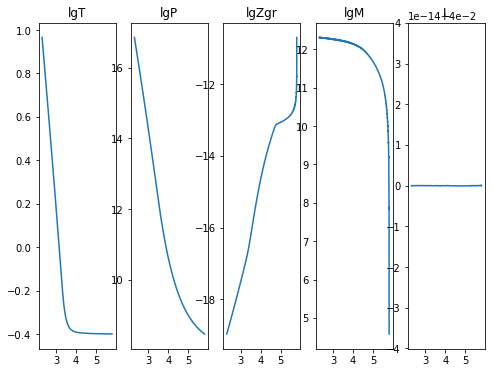

2020-12-06 05:24:13,233 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.1e+00/s
2020-12-06 05:24:14,338 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462375
2020-12-06 05:24:14,339 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894978
2020-12-06 05:24:14,340 __main__ 0/1 INFO :: lgP iterate: 16.85032943387845
2020-12-06 05:24:14,341 __main__ 0/1 INFO :: lgM iterate: 12.278414437712613
2020-12-06 05:24:14,342 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-12-06 05:24:14,343 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-12-06 05:24:14,344 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


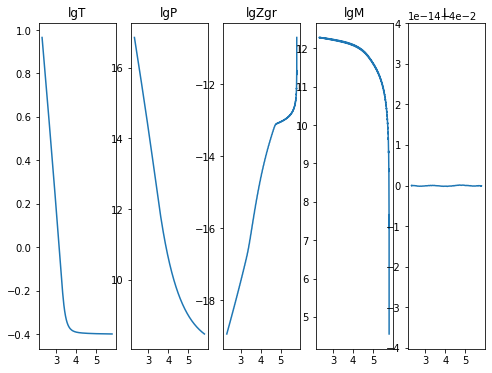

2020-12-06 05:24:18,142 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:24:19,191 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619528
2020-12-06 05:24:19,192 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:24:19,193 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:24:19,194 __main__ 0/1 INFO :: lgM iterate: 12.306662613109044
2020-12-06 05:24:19,195 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506336
2020-12-06 05:24:19,196 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:24:19,197 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


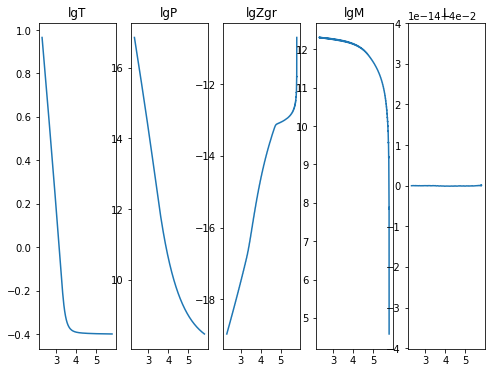

2020-12-06 05:24:22,901 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:24:23,930 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616573
2020-12-06 05:24:23,931 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894967
2020-12-06 05:24:23,931 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:24:23,932 __main__ 0/1 INFO :: lgM iterate: 12.27841443771262
2020-12-06 05:24:23,933 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-12-06 05:24:23,934 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:24:23,935 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


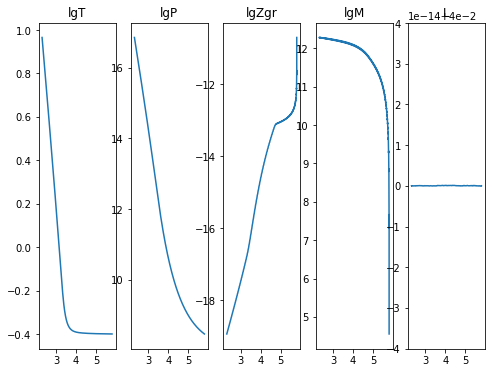

2020-12-06 05:24:27,602 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:24:28,594 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614444
2020-12-06 05:24:28,595 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234061
2020-12-06 05:24:28,596 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:24:28,597 __main__ 0/1 INFO :: lgM iterate: 12.306662613109214
2020-12-06 05:24:28,598 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063478
2020-12-06 05:24:28,599 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:24:28,600 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


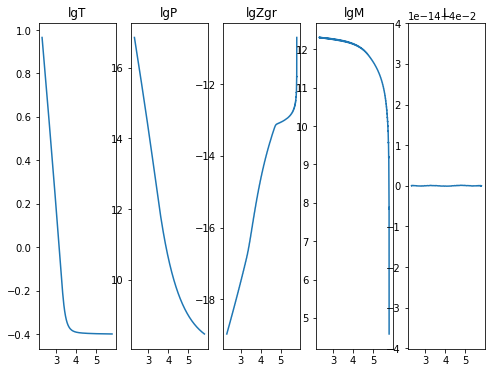

2020-12-06 05:24:32,216 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:24:33,243 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613234
2020-12-06 05:24:33,244 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:24:33,245 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:24:33,246 __main__ 0/1 INFO :: lgM iterate: 12.278414437712678
2020-12-06 05:24:33,247 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-12-06 05:24:33,248 __main__ 0/1 INFO :: m iterate: 1.6098110162232615e-05
2020-12-06 05:24:33,249 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


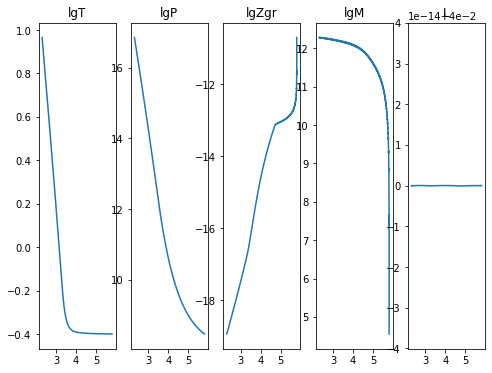

2020-12-06 05:24:36,788 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:24:37,791 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615179
2020-12-06 05:24:37,792 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-12-06 05:24:37,793 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:24:37,794 __main__ 0/1 INFO :: lgM iterate: 12.306662613109228
2020-12-06 05:24:37,795 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063478
2020-12-06 05:24:37,796 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:24:37,796 __main__ 0/1 INFO :: L iterate: 0.04


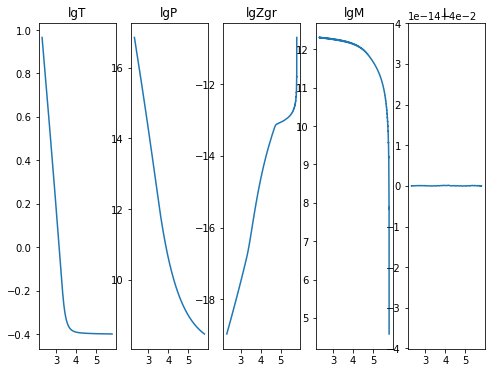

2020-12-06 05:24:41,461 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:24:42,464 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616646
2020-12-06 05:24:42,465 __main__ 0/1 INFO :: lgT iterate: 0.965684908089496
2020-12-06 05:24:42,466 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:24:42,467 __main__ 0/1 INFO :: lgM iterate: 12.278414437712657
2020-12-06 05:24:42,468 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-12-06 05:24:42,469 __main__ 0/1 INFO :: m iterate: 1.6098110156015366e-05
2020-12-06 05:24:42,470 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


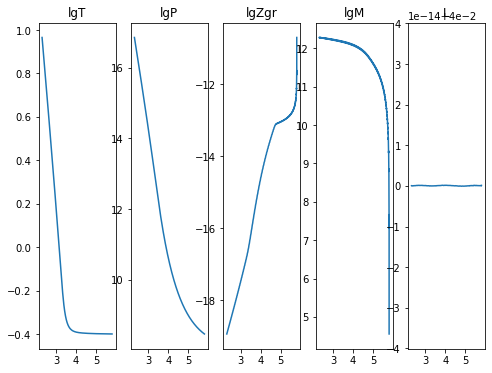

2020-12-06 05:24:46,046 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:24:47,049 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616748
2020-12-06 05:24:47,050 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:24:47,051 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:24:47,052 __main__ 0/1 INFO :: lgM iterate: 12.306662613109111
2020-12-06 05:24:47,053 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-12-06 05:24:47,053 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:24:47,054 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


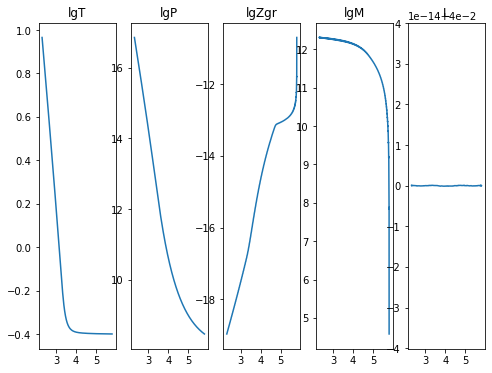

2020-12-06 05:24:50,619 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:24:51,630 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461844
2020-12-06 05:24:51,631 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-12-06 05:24:51,632 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-12-06 05:24:51,633 __main__ 0/1 INFO :: lgM iterate: 12.278414437712744
2020-12-06 05:24:51,634 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183373
2020-12-06 05:24:51,635 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:24:51,636 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


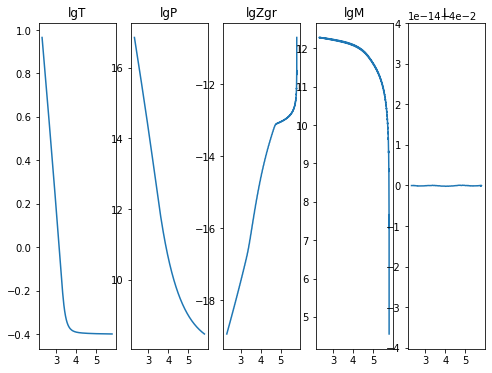

2020-12-06 05:24:55,237 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:24:56,375 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617335
2020-12-06 05:24:56,376 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234034
2020-12-06 05:24:56,377 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:24:56,378 __main__ 0/1 INFO :: lgM iterate: 12.306662613109175
2020-12-06 05:24:56,379 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-12-06 05:24:56,380 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:24:56,381 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


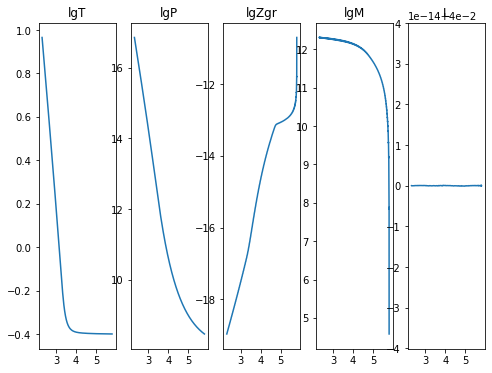

2020-12-06 05:25:00,009 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:25:01,010 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616042
2020-12-06 05:25:01,012 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894936
2020-12-06 05:25:01,012 __main__ 0/1 INFO :: lgP iterate: 16.850329433878454
2020-12-06 05:25:01,013 __main__ 0/1 INFO :: lgM iterate: 12.27841443771269
2020-12-06 05:25:01,014 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183327
2020-12-06 05:25:01,015 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:25:01,016 __main__ 0/1 INFO :: L iterate: 0.04


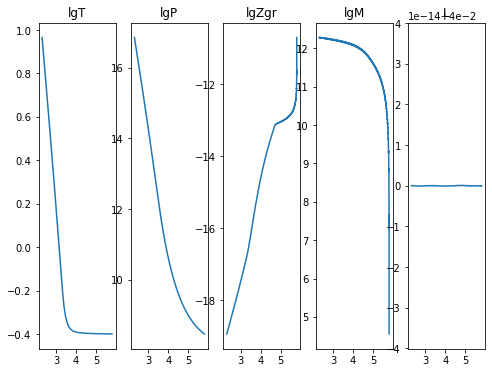

2020-12-06 05:25:04,610 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:25:05,672 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619258
2020-12-06 05:25:05,673 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234045
2020-12-06 05:25:05,674 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:25:05,675 __main__ 0/1 INFO :: lgM iterate: 12.306662613109133
2020-12-06 05:25:05,676 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-12-06 05:25:05,677 __main__ 0/1 INFO :: m iterate: 1.6114013841939112e-05
2020-12-06 05:25:05,678 __main__ 0/1 INFO :: L iterate: 0.04


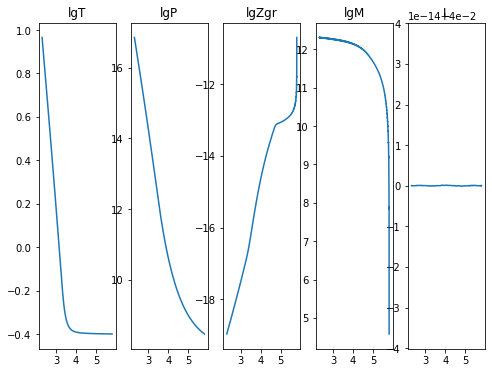

2020-12-06 05:25:09,324 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:25:10,310 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462179
2020-12-06 05:25:10,311 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894931
2020-12-06 05:25:10,312 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:25:10,313 __main__ 0/1 INFO :: lgM iterate: 12.278414437712659
2020-12-06 05:25:10,313 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-12-06 05:25:10,314 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-12-06 05:25:10,315 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


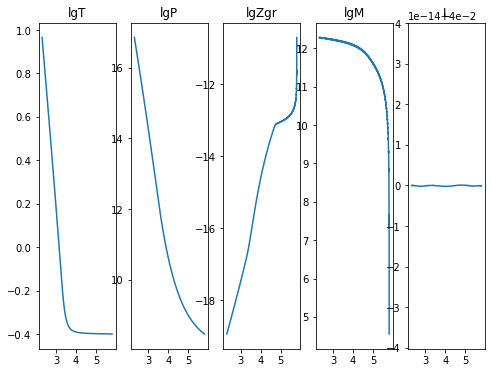

2020-12-06 05:25:13,852 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:25:14,871 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621665
2020-12-06 05:25:14,872 __main__ 0/1 INFO :: lgT iterate: 0.965671625123402
2020-12-06 05:25:14,873 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:25:14,874 __main__ 0/1 INFO :: lgM iterate: 12.306662613109264
2020-12-06 05:25:14,875 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150635
2020-12-06 05:25:14,875 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:25:14,876 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


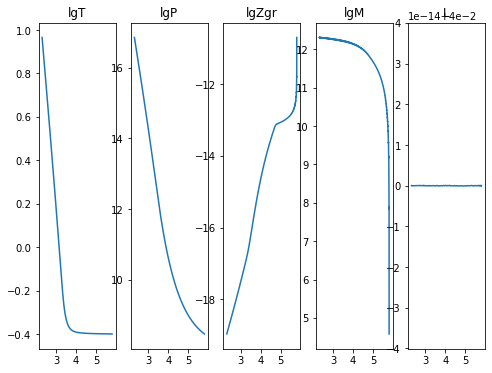

2020-12-06 05:25:18,539 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:25:19,525 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462125
2020-12-06 05:25:19,526 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894941
2020-12-06 05:25:19,527 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:25:19,527 __main__ 0/1 INFO :: lgM iterate: 12.278414437712597
2020-12-06 05:25:19,528 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183274
2020-12-06 05:25:19,529 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-12-06 05:25:19,530 __main__ 0/1 INFO :: L iterate: 0.04


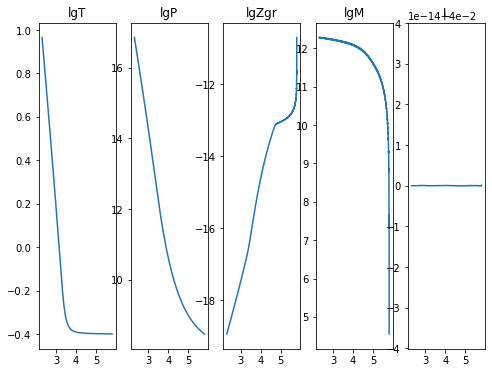

2020-12-06 05:25:23,102 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:25:24,181 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622064
2020-12-06 05:25:24,182 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234021
2020-12-06 05:25:24,183 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:25:24,184 __main__ 0/1 INFO :: lgM iterate: 12.306662613109088
2020-12-06 05:25:24,185 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063392
2020-12-06 05:25:24,186 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:25:24,187 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


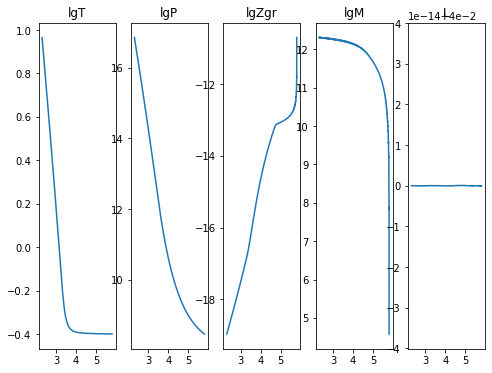

2020-12-06 05:25:27,836 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:25:28,933 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622504
2020-12-06 05:25:28,934 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:25:28,935 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:25:28,936 __main__ 0/1 INFO :: lgM iterate: 12.278414437712556
2020-12-06 05:25:28,936 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183246
2020-12-06 05:25:28,937 __main__ 0/1 INFO :: m iterate: 1.6098110155571277e-05
2020-12-06 05:25:28,938 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


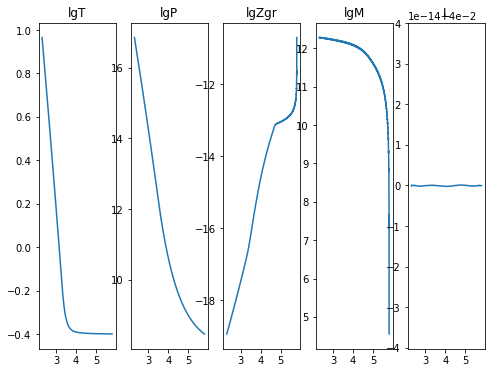

2020-12-06 05:25:32,599 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:25:33,560 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621363
2020-12-06 05:25:33,561 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-12-06 05:25:33,562 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:25:33,562 __main__ 0/1 INFO :: lgM iterate: 12.30666261310914
2020-12-06 05:25:33,563 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506342
2020-12-06 05:25:33,564 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:25:33,565 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


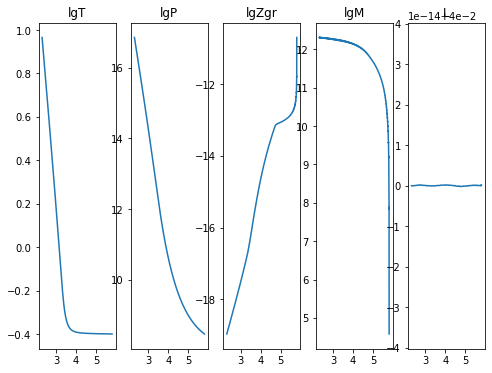

2020-12-06 05:25:37,302 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:25:38,373 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619626
2020-12-06 05:25:38,374 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-12-06 05:25:38,376 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:25:38,377 __main__ 0/1 INFO :: lgM iterate: 12.278414437712716
2020-12-06 05:25:38,378 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118335
2020-12-06 05:25:38,379 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:25:38,380 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


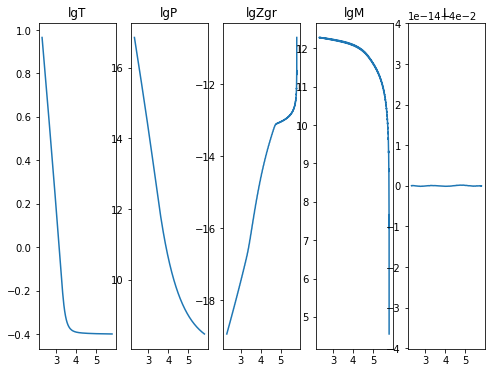

2020-12-06 05:25:42,051 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:25:43,093 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461781
2020-12-06 05:25:43,094 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:25:43,095 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:25:43,096 __main__ 0/1 INFO :: lgM iterate: 12.306662613109205
2020-12-06 05:25:43,097 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-12-06 05:25:43,098 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:25:43,098 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


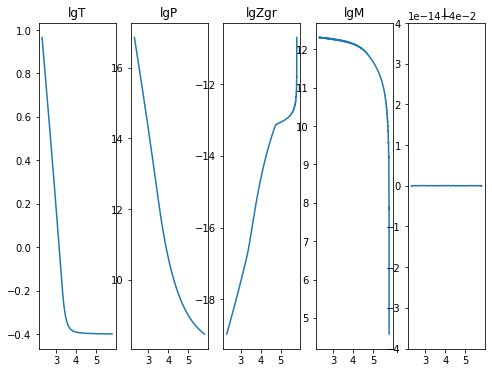

2020-12-06 05:25:47,429 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.2e+00/s
2020-12-06 05:25:48,781 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617224
2020-12-06 05:25:48,782 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894946
2020-12-06 05:25:48,785 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:25:48,786 __main__ 0/1 INFO :: lgM iterate: 12.27841443771263
2020-12-06 05:25:48,788 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118329
2020-12-06 05:25:48,790 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:25:48,791 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


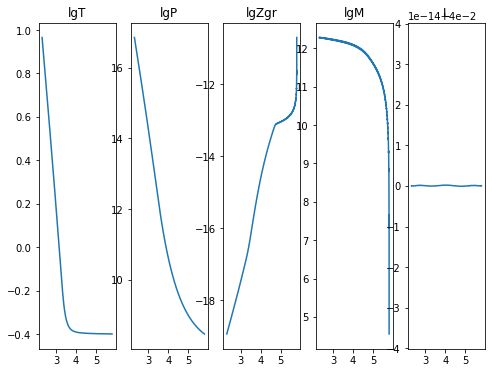

2020-12-06 05:25:53,413 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:25:54,635 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620006
2020-12-06 05:25:54,636 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:25:54,637 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:25:54,638 __main__ 0/1 INFO :: lgM iterate: 12.306662613109193
2020-12-06 05:25:54,640 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:25:54,641 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:25:54,642 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


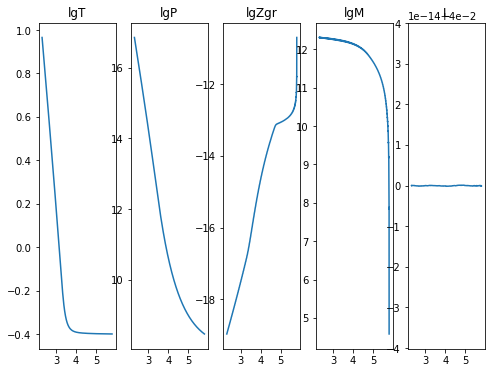

2020-12-06 05:25:58,623 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 2.0e+00/s
2020-12-06 05:25:59,779 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621987
2020-12-06 05:25:59,780 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:25:59,781 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:25:59,782 __main__ 0/1 INFO :: lgM iterate: 12.278414437712652
2020-12-06 05:25:59,783 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-12-06 05:25:59,784 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:25:59,785 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


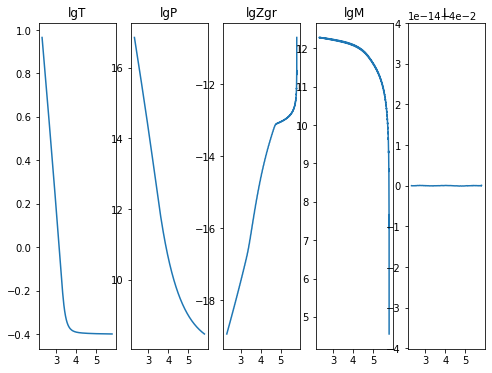

2020-12-06 05:26:03,458 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:26:04,450 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462425
2020-12-06 05:26:04,452 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:26:04,452 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:26:04,453 __main__ 0/1 INFO :: lgM iterate: 12.30666261310918
2020-12-06 05:26:04,454 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063453
2020-12-06 05:26:04,455 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:26:04,456 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


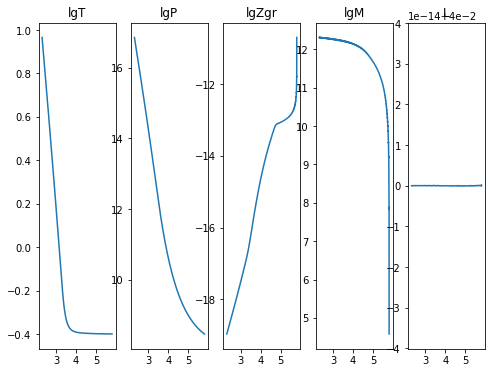

2020-12-06 05:26:08,079 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:26:09,153 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625684
2020-12-06 05:26:09,155 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:26:09,155 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:26:09,156 __main__ 0/1 INFO :: lgM iterate: 12.278414437712744
2020-12-06 05:26:09,157 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183366
2020-12-06 05:26:09,158 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:26:09,159 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


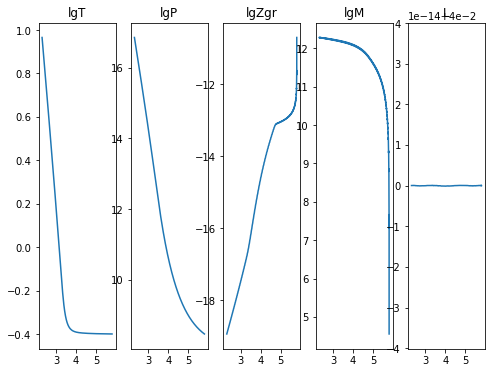

2020-12-06 05:26:12,785 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:26:13,859 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623738
2020-12-06 05:26:13,860 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234057
2020-12-06 05:26:13,860 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:26:13,861 __main__ 0/1 INFO :: lgM iterate: 12.3066626131091
2020-12-06 05:26:13,862 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-12-06 05:26:13,863 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:26:13,864 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


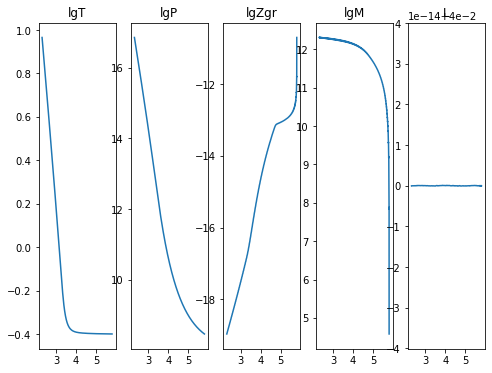

2020-12-06 05:26:17,523 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:26:18,514 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622402
2020-12-06 05:26:18,515 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894983
2020-12-06 05:26:18,516 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:26:18,516 __main__ 0/1 INFO :: lgM iterate: 12.278414437712645
2020-12-06 05:26:18,517 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-12-06 05:26:18,518 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:26:18,519 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


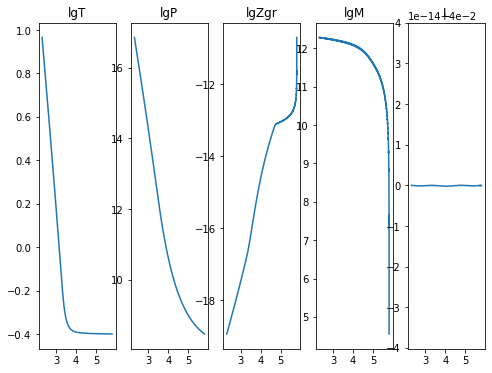

2020-12-06 05:26:22,139 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:26:23,178 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618853
2020-12-06 05:26:23,179 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234044
2020-12-06 05:26:23,180 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:26:23,181 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:26:23,182 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-12-06 05:26:23,183 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:26:23,184 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


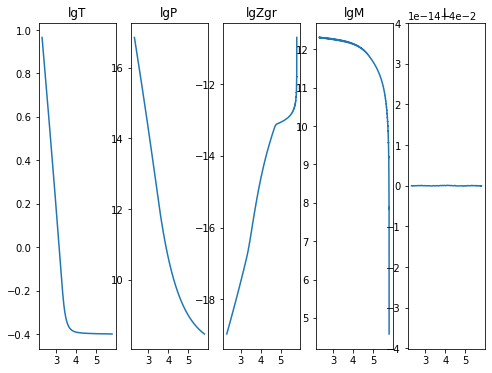

2020-12-06 05:26:26,792 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:26:27,842 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616953
2020-12-06 05:26:27,844 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894959
2020-12-06 05:26:27,844 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:26:27,861 __main__ 0/1 INFO :: lgM iterate: 12.278414437712545
2020-12-06 05:26:27,862 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118324
2020-12-06 05:26:27,863 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:26:27,863 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


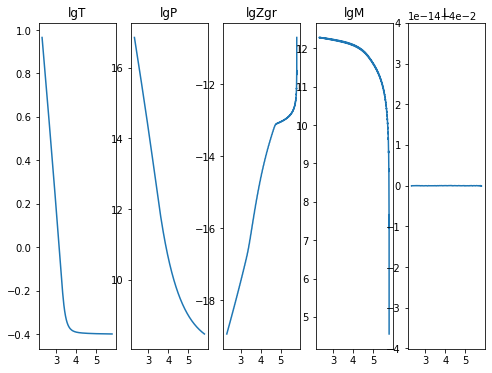

2020-12-06 05:26:31,466 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:26:32,501 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615438
2020-12-06 05:26:32,502 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-12-06 05:26:32,503 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:26:32,504 __main__ 0/1 INFO :: lgM iterate: 12.306662613109182
2020-12-06 05:26:32,505 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506345
2020-12-06 05:26:32,506 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-12-06 05:26:32,507 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


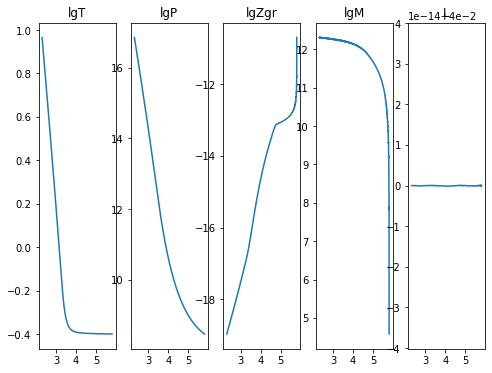

2020-12-06 05:26:36,216 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:26:37,256 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474612698
2020-12-06 05:26:37,257 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894969
2020-12-06 05:26:37,258 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:26:37,258 __main__ 0/1 INFO :: lgM iterate: 12.278414437712676
2020-12-06 05:26:37,259 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183324
2020-12-06 05:26:37,260 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:26:37,261 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


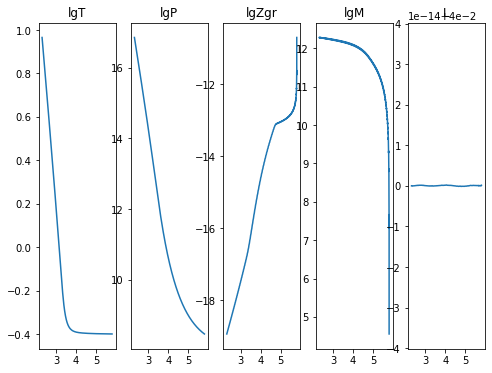

2020-12-06 05:26:40,836 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:26:41,846 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474612867
2020-12-06 05:26:41,847 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234031
2020-12-06 05:26:41,848 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:26:41,849 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:26:41,850 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:26:41,851 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:26:41,852 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


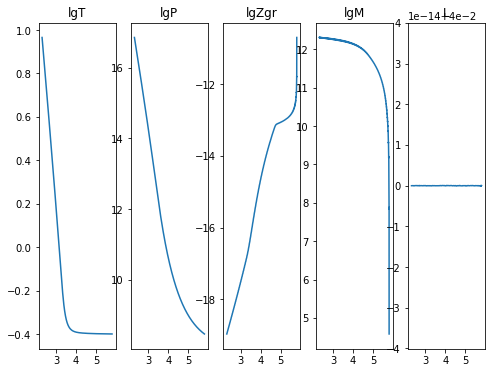

2020-12-06 05:26:45,456 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:26:46,450 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474613604
2020-12-06 05:26:46,451 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894967
2020-12-06 05:26:46,452 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:26:46,452 __main__ 0/1 INFO :: lgM iterate: 12.278414437712732
2020-12-06 05:26:46,453 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183363
2020-12-06 05:26:46,454 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:26:46,455 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


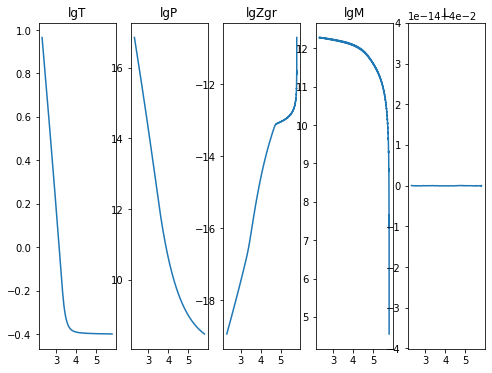

2020-12-06 05:26:50,047 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:26:51,054 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617155
2020-12-06 05:26:51,055 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234031
2020-12-06 05:26:51,056 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:26:51,057 __main__ 0/1 INFO :: lgM iterate: 12.306662613109228
2020-12-06 05:26:51,058 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506348
2020-12-06 05:26:51,059 __main__ 0/1 INFO :: m iterate: 1.61140138423832e-05
2020-12-06 05:26:51,059 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


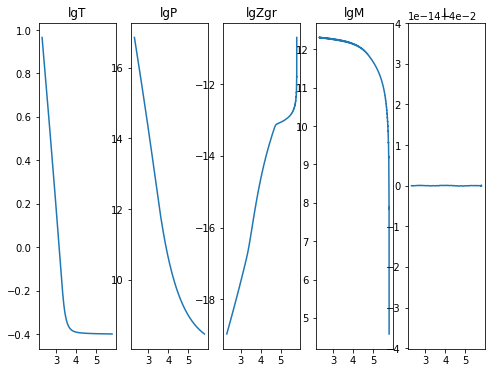

2020-12-06 05:26:54,712 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:26:55,740 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461996
2020-12-06 05:26:55,741 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894953
2020-12-06 05:26:55,742 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:26:55,742 __main__ 0/1 INFO :: lgM iterate: 12.278414437712573
2020-12-06 05:26:55,743 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183256
2020-12-06 05:26:55,744 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:26:55,745 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


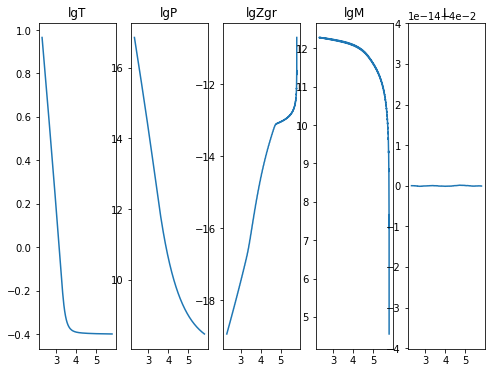

2020-12-06 05:26:59,331 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:27:00,362 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617503
2020-12-06 05:27:00,363 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:27:00,364 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:27:00,364 __main__ 0/1 INFO :: lgM iterate: 12.30666261310915
2020-12-06 05:27:00,365 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506343
2020-12-06 05:27:00,366 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:27:00,366 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


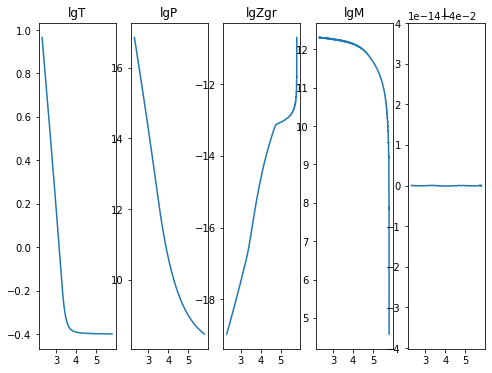

2020-12-06 05:27:03,949 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:27:04,946 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615398
2020-12-06 05:27:04,947 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:27:04,948 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:27:04,948 __main__ 0/1 INFO :: lgM iterate: 12.278414437712744
2020-12-06 05:27:04,949 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183373
2020-12-06 05:27:04,950 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-12-06 05:27:04,950 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


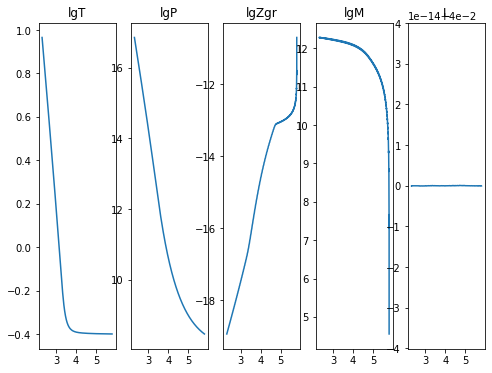

2020-12-06 05:27:08,531 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:09,565 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614572
2020-12-06 05:27:09,566 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:27:09,567 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:27:09,567 __main__ 0/1 INFO :: lgM iterate: 12.306662613109214
2020-12-06 05:27:09,568 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-12-06 05:27:09,569 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:27:09,570 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


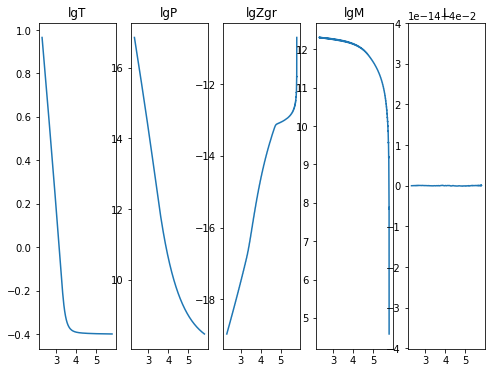

2020-12-06 05:27:13,221 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:14,268 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746139
2020-12-06 05:27:14,269 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894968
2020-12-06 05:27:14,270 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:27:14,271 __main__ 0/1 INFO :: lgM iterate: 12.278414437712687
2020-12-06 05:27:14,272 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-12-06 05:27:14,273 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:27:14,273 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


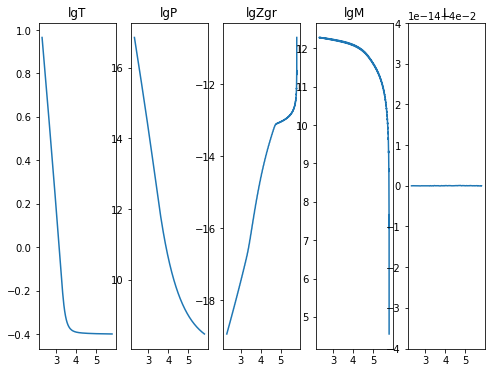

2020-12-06 05:27:17,817 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:27:18,889 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614792
2020-12-06 05:27:18,890 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:27:18,891 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:27:18,892 __main__ 0/1 INFO :: lgM iterate: 12.306662613109173
2020-12-06 05:27:18,893 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-12-06 05:27:18,894 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:27:18,895 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


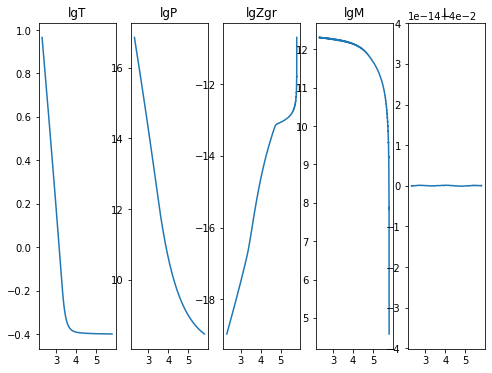

2020-12-06 05:27:22,495 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:23,515 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615765
2020-12-06 05:27:23,521 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894976
2020-12-06 05:27:23,521 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:27:23,522 __main__ 0/1 INFO :: lgM iterate: 12.278414437712605
2020-12-06 05:27:23,522 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183278
2020-12-06 05:27:23,523 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:27:23,524 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


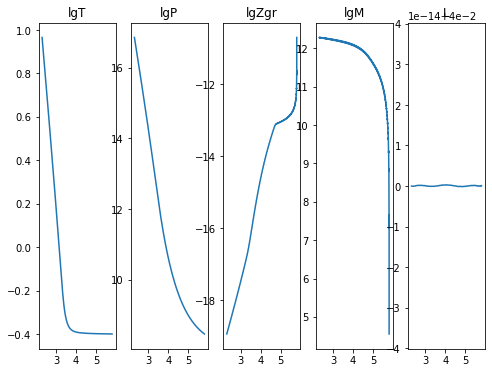

2020-12-06 05:27:27,262 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:28,269 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614803
2020-12-06 05:27:28,271 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-12-06 05:27:28,271 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:27:28,273 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:27:28,273 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:27:28,274 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:27:28,275 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


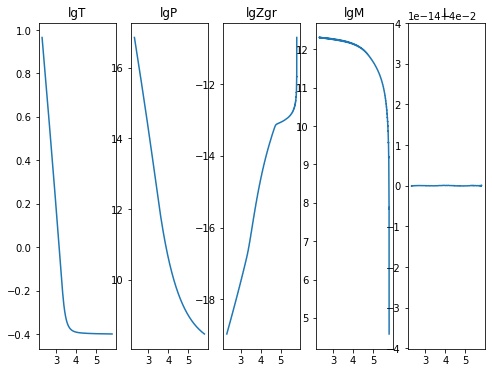

2020-12-06 05:27:31,974 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:33,118 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474614546
2020-12-06 05:27:33,119 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894944
2020-12-06 05:27:33,120 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:27:33,121 __main__ 0/1 INFO :: lgM iterate: 12.278414437712708
2020-12-06 05:27:33,122 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183345
2020-12-06 05:27:33,123 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:27:33,124 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


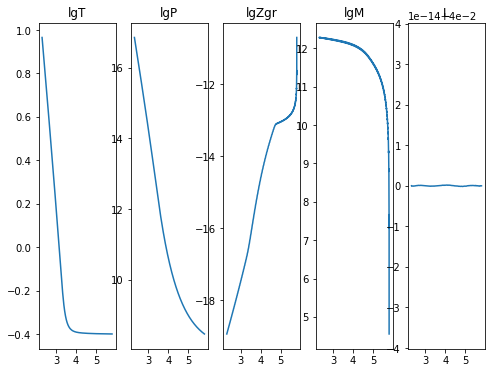

2020-12-06 05:27:36,810 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:27:37,913 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461757
2020-12-06 05:27:37,914 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234042
2020-12-06 05:27:37,915 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:27:37,916 __main__ 0/1 INFO :: lgM iterate: 12.306662613109225
2020-12-06 05:27:37,917 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063478
2020-12-06 05:27:37,918 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:27:37,919 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


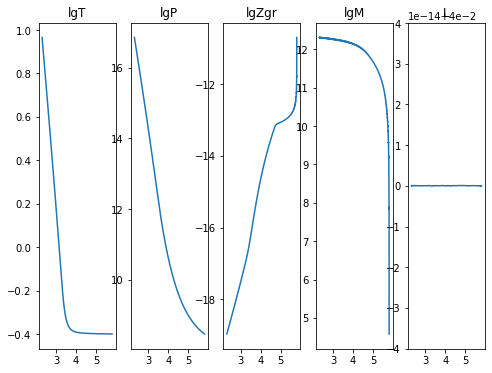

2020-12-06 05:27:41,616 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:27:42,658 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620252
2020-12-06 05:27:42,659 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894945
2020-12-06 05:27:42,659 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:27:42,660 __main__ 0/1 INFO :: lgM iterate: 12.278414437712636
2020-12-06 05:27:42,661 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-12-06 05:27:42,662 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:27:42,662 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


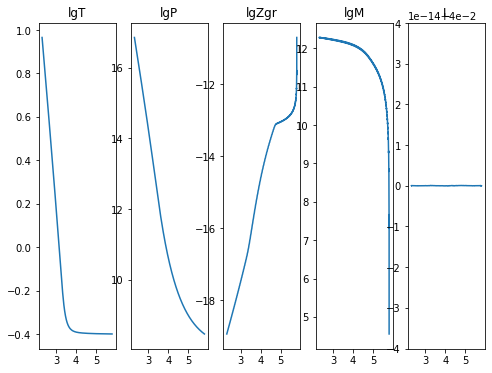

2020-12-06 05:27:46,353 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:47,426 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620568
2020-12-06 05:27:47,427 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234031
2020-12-06 05:27:47,428 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:27:47,429 __main__ 0/1 INFO :: lgM iterate: 12.306662613109244
2020-12-06 05:27:47,429 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063495
2020-12-06 05:27:47,430 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:27:47,431 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


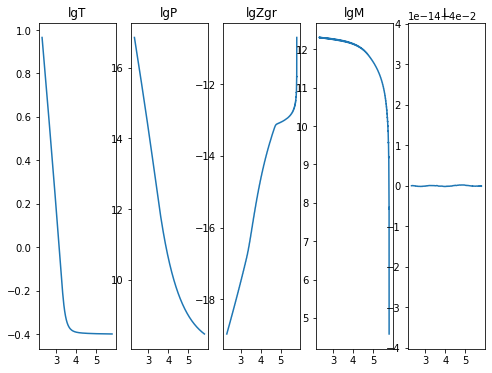

2020-12-06 05:27:51,128 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:52,103 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746214
2020-12-06 05:27:52,104 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:27:52,105 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:27:52,105 __main__ 0/1 INFO :: lgM iterate: 12.278414437712577
2020-12-06 05:27:52,106 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183267
2020-12-06 05:27:52,107 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:27:52,108 __main__ 0/1 INFO :: L iterate: 0.04


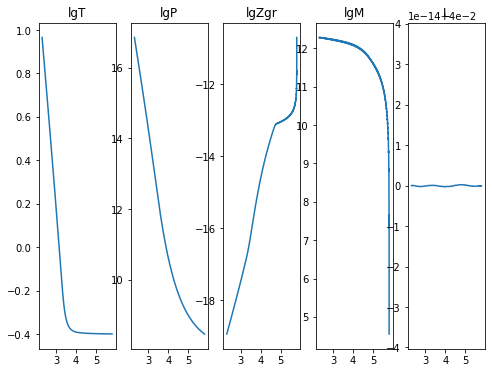

2020-12-06 05:27:55,675 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:27:56,652 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621278
2020-12-06 05:27:56,654 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:27:56,654 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:27:56,655 __main__ 0/1 INFO :: lgM iterate: 12.306662613109165
2020-12-06 05:27:56,656 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063435
2020-12-06 05:27:56,657 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:27:56,657 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


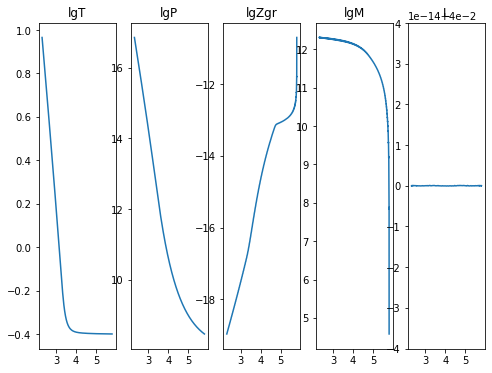

2020-12-06 05:28:00,250 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:28:01,264 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619189
2020-12-06 05:28:01,265 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-12-06 05:28:01,266 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:28:01,267 __main__ 0/1 INFO :: lgM iterate: 12.278414437712684
2020-12-06 05:28:01,268 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183327
2020-12-06 05:28:01,269 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:28:01,269 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


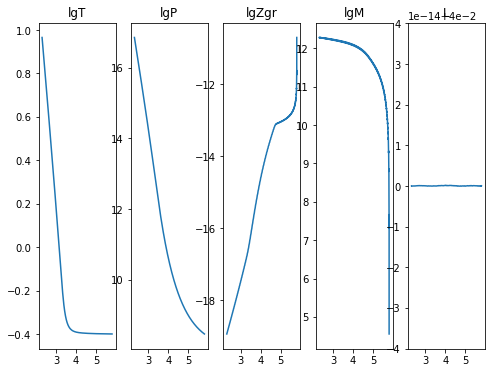

2020-12-06 05:28:04,862 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:28:05,882 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618405
2020-12-06 05:28:05,883 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234044
2020-12-06 05:28:05,885 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:28:05,886 __main__ 0/1 INFO :: lgM iterate: 12.306662613109193
2020-12-06 05:28:05,886 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:28:05,888 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:28:05,889 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


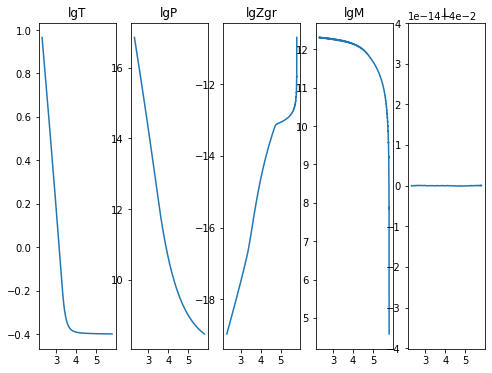

2020-12-06 05:28:09,675 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:10,621 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618443
2020-12-06 05:28:10,622 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894931
2020-12-06 05:28:10,623 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:28:10,624 __main__ 0/1 INFO :: lgM iterate: 12.278414437712797
2020-12-06 05:28:10,625 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183405
2020-12-06 05:28:10,626 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:28:10,627 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


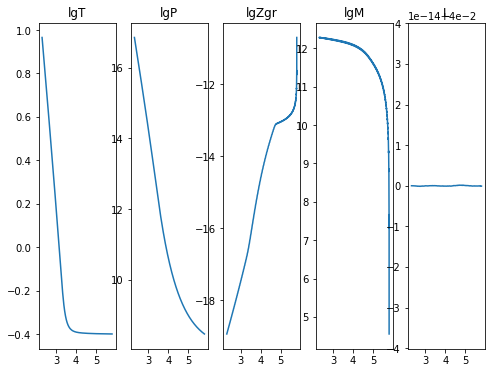

2020-12-06 05:28:14,237 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:28:15,246 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618871
2020-12-06 05:28:15,247 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:28:15,248 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:28:15,248 __main__ 0/1 INFO :: lgM iterate: 12.306662613109165
2020-12-06 05:28:15,249 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063435
2020-12-06 05:28:15,250 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:28:15,250 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


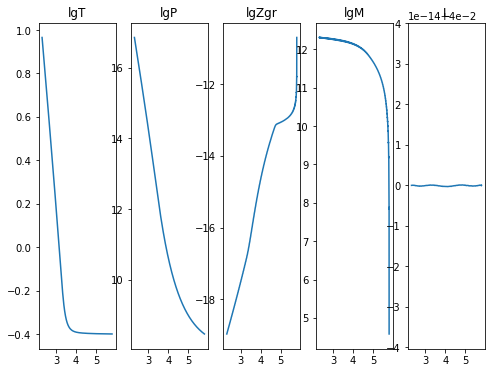

2020-12-06 05:28:18,883 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:28:19,886 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620528
2020-12-06 05:28:19,887 __main__ 0/1 INFO :: lgT iterate: 0.965684908089493
2020-12-06 05:28:19,888 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:28:19,889 __main__ 0/1 INFO :: lgM iterate: 12.278414437712652
2020-12-06 05:28:19,889 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-12-06 05:28:19,890 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-12-06 05:28:19,891 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


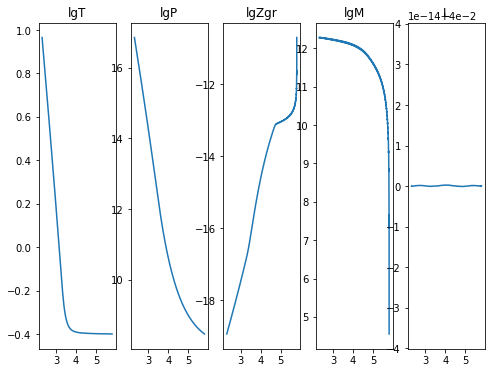

2020-12-06 05:28:23,478 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:24,483 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461825
2020-12-06 05:28:24,484 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234025
2020-12-06 05:28:24,485 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:28:24,506 __main__ 0/1 INFO :: lgM iterate: 12.30666261310903
2020-12-06 05:28:24,510 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063343
2020-12-06 05:28:24,518 __main__ 0/1 INFO :: m iterate: 1.6114013841939112e-05
2020-12-06 05:28:24,526 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


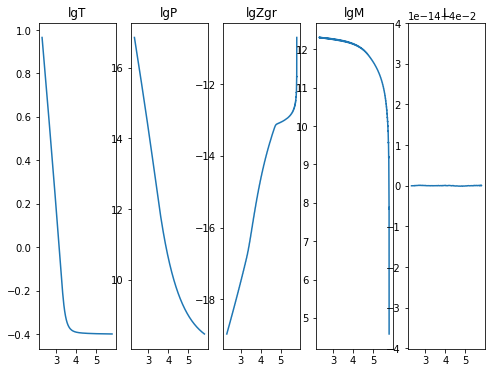

2020-12-06 05:28:28,232 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:29,244 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461526
2020-12-06 05:28:29,246 __main__ 0/1 INFO :: lgT iterate: 0.965684908089495
2020-12-06 05:28:29,246 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:28:29,247 __main__ 0/1 INFO :: lgM iterate: 12.278414437712668
2020-12-06 05:28:29,248 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:28:29,250 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:28:29,250 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


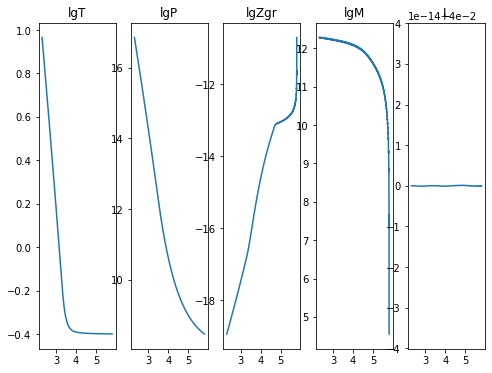

2020-12-06 05:28:32,880 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:28:33,922 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619389
2020-12-06 05:28:33,923 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-12-06 05:28:33,924 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:28:33,925 __main__ 0/1 INFO :: lgM iterate: 12.306662613109129
2020-12-06 05:28:33,926 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063414
2020-12-06 05:28:33,928 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:28:33,929 __main__ 0/1 INFO :: L iterate: 0.04


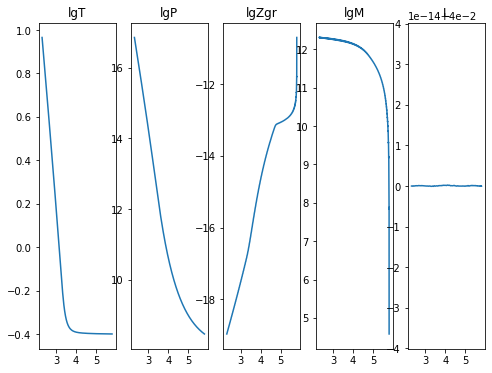

2020-12-06 05:28:37,551 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:38,587 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621778
2020-12-06 05:28:38,588 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894946
2020-12-06 05:28:38,589 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:28:38,591 __main__ 0/1 INFO :: lgM iterate: 12.278414437712609
2020-12-06 05:28:38,592 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-12-06 05:28:38,593 __main__ 0/1 INFO :: m iterate: 1.6098110160900347e-05
2020-12-06 05:28:38,594 __main__ 0/1 INFO :: L iterate: 0.04


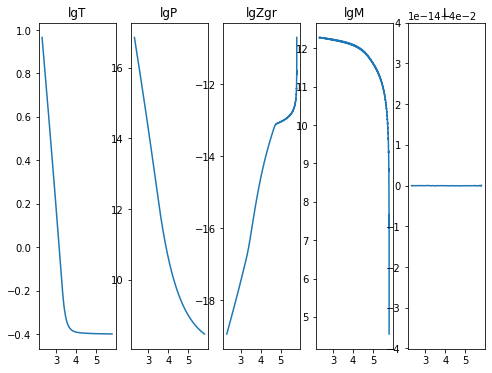

2020-12-06 05:28:42,205 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:43,217 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619417
2020-12-06 05:28:43,218 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234034
2020-12-06 05:28:43,219 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:28:43,220 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:28:43,220 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506346
2020-12-06 05:28:43,222 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:28:43,223 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


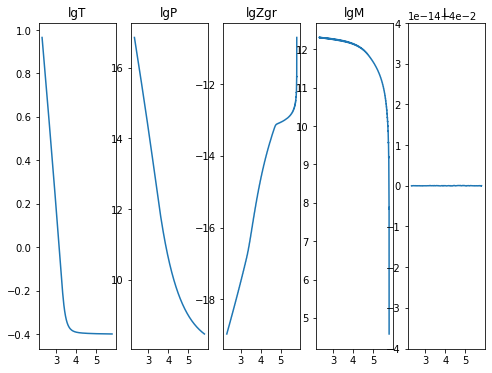

2020-12-06 05:28:46,901 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:47,872 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619167
2020-12-06 05:28:47,874 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:28:47,874 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-12-06 05:28:47,875 __main__ 0/1 INFO :: lgM iterate: 12.278414437712666
2020-12-06 05:28:47,876 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:28:47,877 __main__ 0/1 INFO :: m iterate: 1.6098110156015366e-05
2020-12-06 05:28:47,877 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


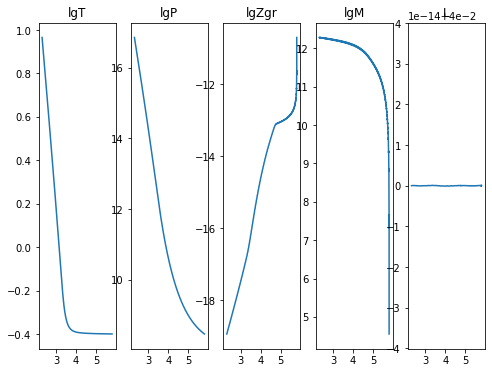

2020-12-06 05:28:51,504 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:28:52,535 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462125
2020-12-06 05:28:52,536 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:28:52,537 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:28:52,537 __main__ 0/1 INFO :: lgM iterate: 12.306662613109243
2020-12-06 05:28:52,538 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063485
2020-12-06 05:28:52,539 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:28:52,540 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


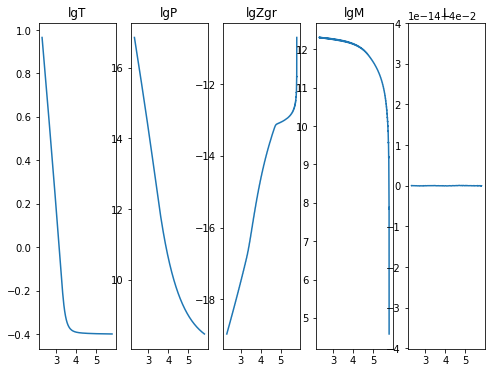

2020-12-06 05:28:56,189 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:28:57,262 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622852
2020-12-06 05:28:57,263 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894911
2020-12-06 05:28:57,264 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:28:57,265 __main__ 0/1 INFO :: lgM iterate: 12.278414437712744
2020-12-06 05:28:57,266 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118337
2020-12-06 05:28:57,267 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:28:57,267 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


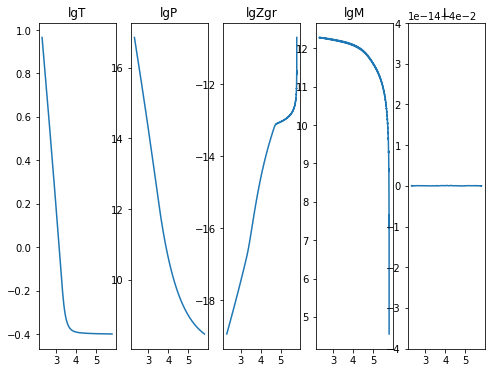

2020-12-06 05:29:00,918 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:29:01,939 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621902
2020-12-06 05:29:01,940 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234049
2020-12-06 05:29:01,940 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:29:01,941 __main__ 0/1 INFO :: lgM iterate: 12.30666261310915
2020-12-06 05:29:01,942 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-12-06 05:29:01,942 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:29:01,943 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


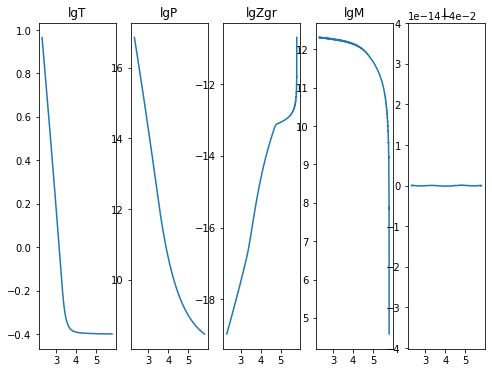

2020-12-06 05:29:05,686 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:29:06,706 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619502
2020-12-06 05:29:06,707 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894964
2020-12-06 05:29:06,708 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:29:06,709 __main__ 0/1 INFO :: lgM iterate: 12.278414437712595
2020-12-06 05:29:06,709 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183274
2020-12-06 05:29:06,710 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:29:06,711 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


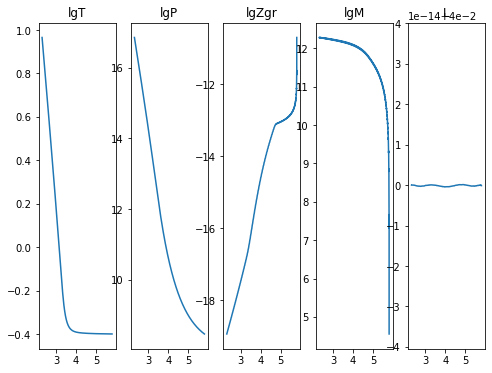

2020-12-06 05:29:10,324 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:11,404 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621385
2020-12-06 05:29:11,405 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:29:11,406 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:29:11,406 __main__ 0/1 INFO :: lgM iterate: 12.306662613109065
2020-12-06 05:29:11,407 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506337
2020-12-06 05:29:11,408 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:29:11,409 __main__ 0/1 INFO :: L iterate: 0.04


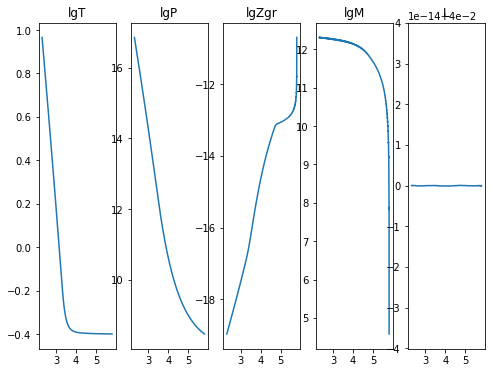

2020-12-06 05:29:15,008 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:16,027 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622277
2020-12-06 05:29:16,028 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894941
2020-12-06 05:29:16,028 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:29:16,029 __main__ 0/1 INFO :: lgM iterate: 12.278414437712698
2020-12-06 05:29:16,030 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-12-06 05:29:16,031 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:29:16,032 __main__ 0/1 INFO :: L iterate: 0.04


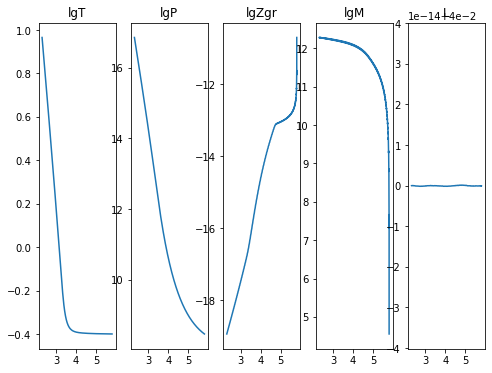

2020-12-06 05:29:19,646 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:20,717 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618025
2020-12-06 05:29:20,719 __main__ 0/1 INFO :: lgT iterate: 0.965671625123404
2020-12-06 05:29:20,721 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:29:20,722 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:29:20,723 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-12-06 05:29:20,724 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:29:20,724 __main__ 0/1 INFO :: L iterate: 0.04


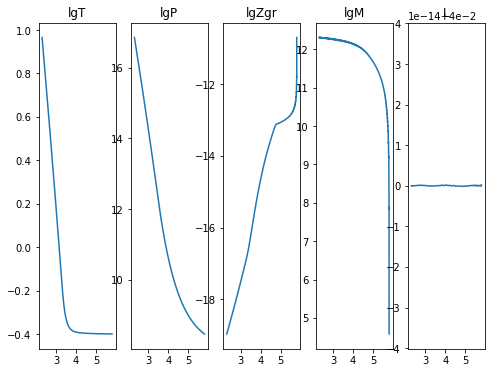

2020-12-06 05:29:24,516 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:29:25,546 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615627
2020-12-06 05:29:25,547 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-12-06 05:29:25,548 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:29:25,549 __main__ 0/1 INFO :: lgM iterate: 12.278414437712634
2020-12-06 05:29:25,549 __main__ 0/1 INFO :: lgZgr iterate: -18.9447523311833
2020-12-06 05:29:25,551 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:29:25,551 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


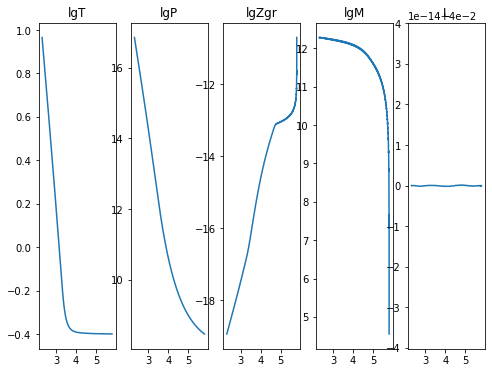

2020-12-06 05:29:29,215 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:30,239 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620936
2020-12-06 05:29:30,240 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-12-06 05:29:30,241 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:29:30,241 __main__ 0/1 INFO :: lgM iterate: 12.306662613109289
2020-12-06 05:29:30,242 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506352
2020-12-06 05:29:30,243 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:29:30,244 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


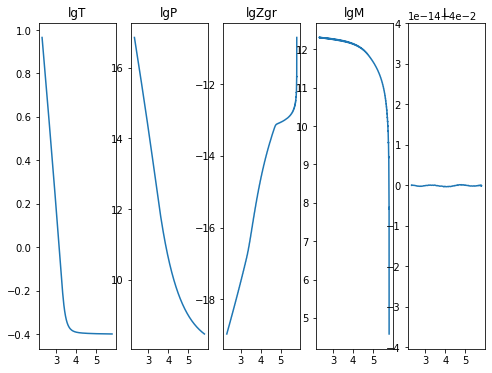

2020-12-06 05:29:33,941 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:34,987 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625675
2020-12-06 05:29:34,988 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894955
2020-12-06 05:29:34,989 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:29:34,990 __main__ 0/1 INFO :: lgM iterate: 12.278414437712705
2020-12-06 05:29:34,991 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183345
2020-12-06 05:29:34,992 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:29:34,992 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


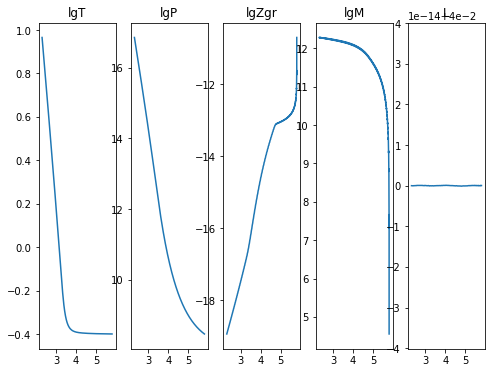

2020-12-06 05:29:38,583 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:39,599 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625637
2020-12-06 05:29:39,600 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-12-06 05:29:39,601 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:29:39,602 __main__ 0/1 INFO :: lgM iterate: 12.306662613109268
2020-12-06 05:29:39,603 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506351
2020-12-06 05:29:39,604 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-12-06 05:29:39,604 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


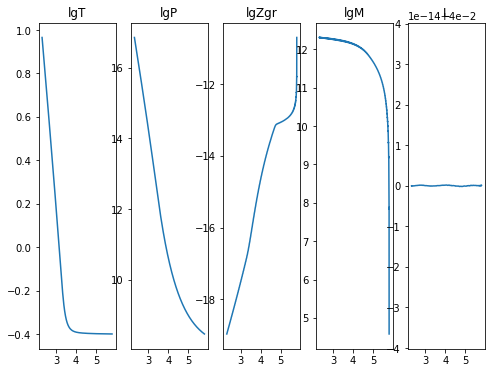

2020-12-06 05:29:43,251 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:29:44,277 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625246
2020-12-06 05:29:44,278 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:29:44,278 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:29:44,279 __main__ 0/1 INFO :: lgM iterate: 12.278414437712694
2020-12-06 05:29:44,280 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183338
2020-12-06 05:29:44,281 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:29:44,282 __main__ 0/1 INFO :: L iterate: 0.04000000000000005


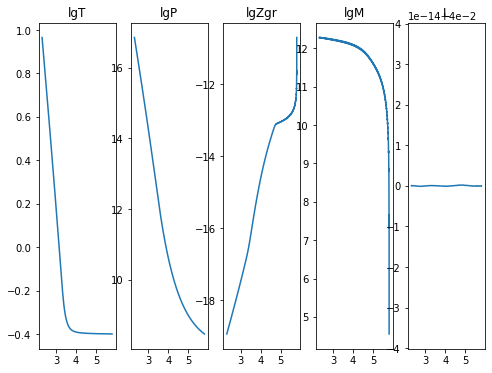

2020-12-06 05:29:47,857 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:48,846 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474628215
2020-12-06 05:29:48,848 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-12-06 05:29:48,848 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:29:48,849 __main__ 0/1 INFO :: lgM iterate: 12.30666261310918
2020-12-06 05:29:48,850 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506345
2020-12-06 05:29:48,851 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:29:48,852 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


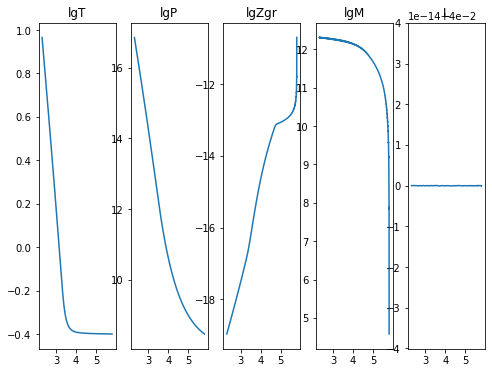

2020-12-06 05:29:52,439 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:53,445 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474629496
2020-12-06 05:29:53,446 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:29:53,447 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:29:53,448 __main__ 0/1 INFO :: lgM iterate: 12.278414437712726
2020-12-06 05:29:53,449 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118336
2020-12-06 05:29:53,450 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:29:53,450 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


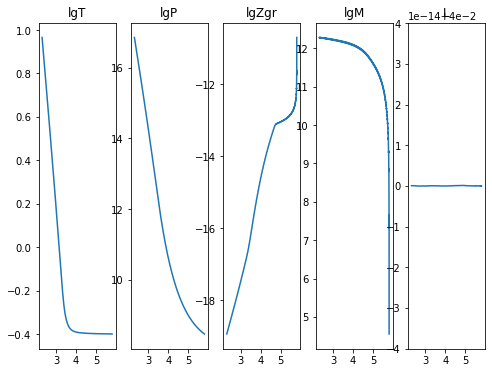

2020-12-06 05:29:57,029 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:29:58,049 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624564
2020-12-06 05:29:58,050 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:29:58,051 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:29:58,052 __main__ 0/1 INFO :: lgM iterate: 12.30666261310915
2020-12-06 05:29:58,054 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-12-06 05:29:58,055 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-12-06 05:29:58,056 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


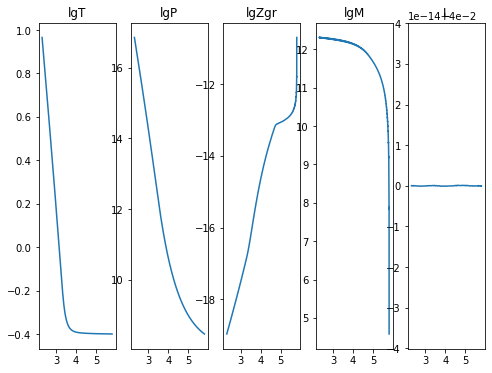

2020-12-06 05:30:01,685 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:30:02,670 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462086
2020-12-06 05:30:02,672 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894969
2020-12-06 05:30:02,672 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:30:02,673 __main__ 0/1 INFO :: lgM iterate: 12.278414437712689
2020-12-06 05:30:02,674 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-12-06 05:30:02,676 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:30:02,677 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


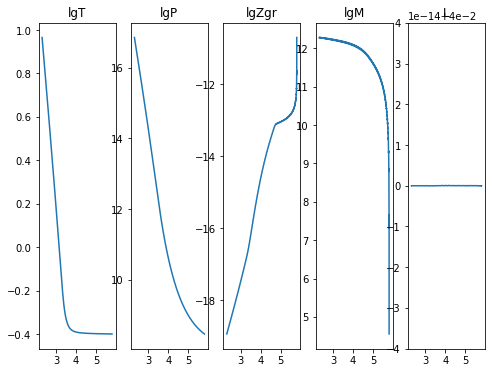

2020-12-06 05:30:06,282 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:07,343 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620628
2020-12-06 05:30:07,344 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234052
2020-12-06 05:30:07,345 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:30:07,346 __main__ 0/1 INFO :: lgM iterate: 12.306662613109195
2020-12-06 05:30:07,347 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506345
2020-12-06 05:30:07,348 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:30:07,348 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


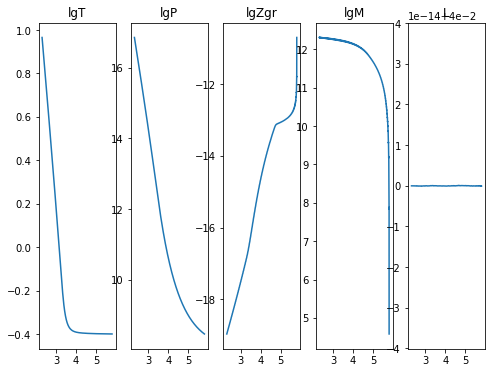

2020-12-06 05:30:10,964 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:11,957 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462044
2020-12-06 05:30:11,958 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894951
2020-12-06 05:30:11,959 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:30:11,960 __main__ 0/1 INFO :: lgM iterate: 12.278414437712552
2020-12-06 05:30:11,960 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118324
2020-12-06 05:30:11,961 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:30:11,962 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


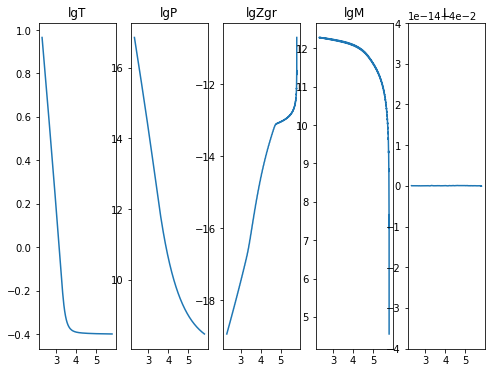

2020-12-06 05:30:15,513 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:30:16,504 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618951
2020-12-06 05:30:16,506 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234024
2020-12-06 05:30:16,506 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:30:16,507 __main__ 0/1 INFO :: lgM iterate: 12.30666261310921
2020-12-06 05:30:16,508 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-12-06 05:30:16,510 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:30:16,511 __main__ 0/1 INFO :: L iterate: 0.04


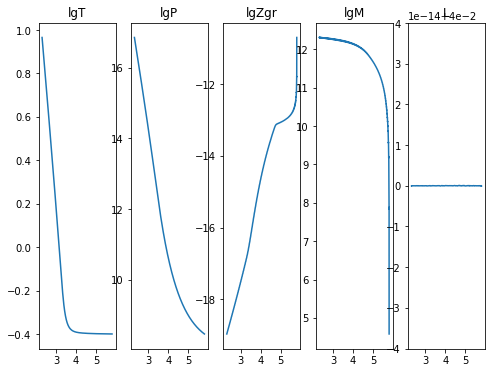

2020-12-06 05:30:20,176 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:21,159 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617934
2020-12-06 05:30:21,160 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:30:21,161 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:30:21,162 __main__ 0/1 INFO :: lgM iterate: 12.27841443771262
2020-12-06 05:30:21,162 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183285
2020-12-06 05:30:21,163 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-12-06 05:30:21,164 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


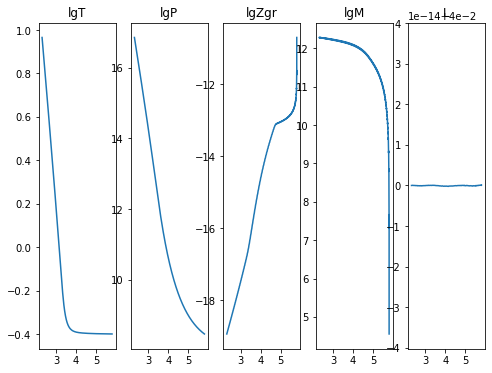

2020-12-06 05:30:24,734 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:25,699 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617672
2020-12-06 05:30:25,701 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234047
2020-12-06 05:30:25,701 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:30:25,702 __main__ 0/1 INFO :: lgM iterate: 12.306662613109207
2020-12-06 05:30:25,703 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-12-06 05:30:25,704 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-12-06 05:30:25,705 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


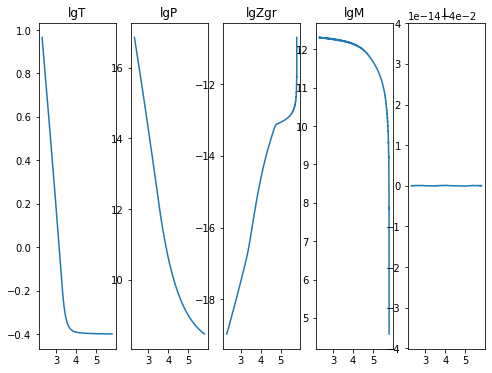

2020-12-06 05:30:29,318 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:30,348 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616067
2020-12-06 05:30:30,349 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894978
2020-12-06 05:30:30,350 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-12-06 05:30:30,351 __main__ 0/1 INFO :: lgM iterate: 12.278414437712751
2020-12-06 05:30:30,351 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183377
2020-12-06 05:30:30,352 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:30:30,353 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


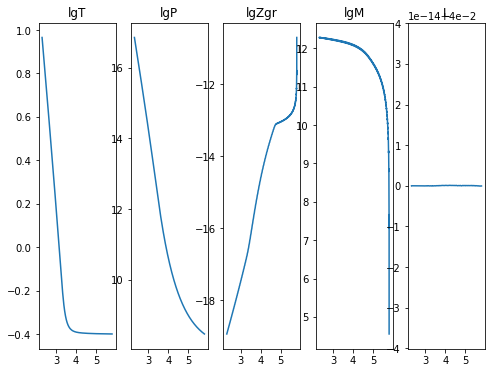

2020-12-06 05:30:33,937 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:34,978 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619058
2020-12-06 05:30:34,980 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:30:34,980 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:30:34,981 __main__ 0/1 INFO :: lgM iterate: 12.306662613109207
2020-12-06 05:30:34,982 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-12-06 05:30:34,983 __main__ 0/1 INFO :: m iterate: 1.6114013841939112e-05
2020-12-06 05:30:34,984 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


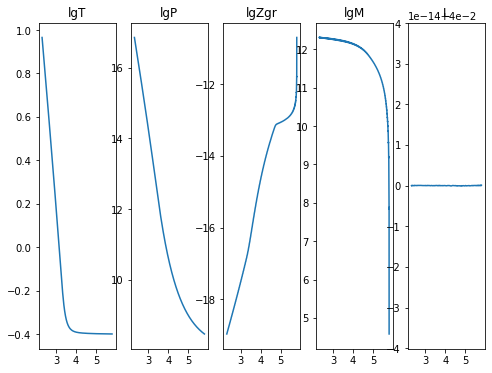

2020-12-06 05:30:38,661 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:39,663 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623385
2020-12-06 05:30:39,665 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894943
2020-12-06 05:30:39,665 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:30:39,666 __main__ 0/1 INFO :: lgM iterate: 12.278414437712744
2020-12-06 05:30:39,667 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183366
2020-12-06 05:30:39,668 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-12-06 05:30:39,669 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


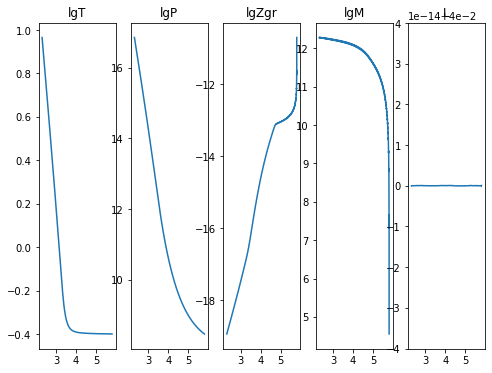

2020-12-06 05:30:43,259 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:30:44,271 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622424
2020-12-06 05:30:44,272 __main__ 0/1 INFO :: lgT iterate: 0.965671625123404
2020-12-06 05:30:44,273 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:30:44,273 __main__ 0/1 INFO :: lgM iterate: 12.30666261310905
2020-12-06 05:30:44,274 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063357
2020-12-06 05:30:44,275 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:30:44,276 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


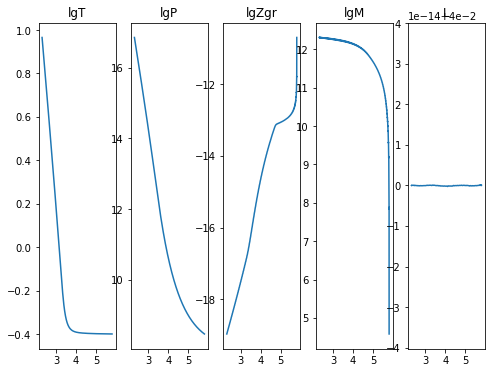

2020-12-06 05:30:47,878 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:48,879 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620066
2020-12-06 05:30:48,881 __main__ 0/1 INFO :: lgT iterate: 0.965684908089498
2020-12-06 05:30:48,882 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:30:48,883 __main__ 0/1 INFO :: lgM iterate: 12.278414437712645
2020-12-06 05:30:48,884 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-12-06 05:30:48,885 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:30:48,885 __main__ 0/1 INFO :: L iterate: 0.04


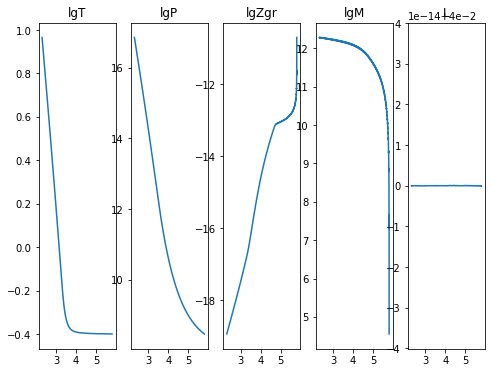

2020-12-06 05:30:52,469 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:53,410 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618996
2020-12-06 05:30:53,411 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234031
2020-12-06 05:30:53,412 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:30:53,412 __main__ 0/1 INFO :: lgM iterate: 12.30666261310918
2020-12-06 05:30:53,413 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063446
2020-12-06 05:30:53,414 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-12-06 05:30:53,415 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


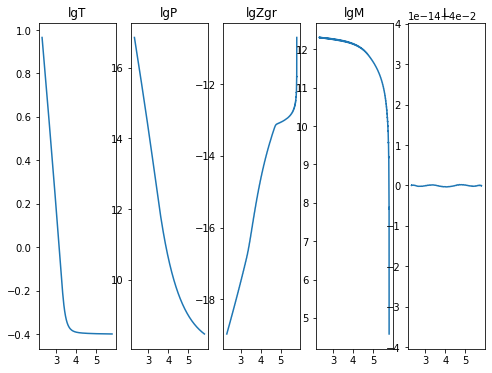

2020-12-06 05:30:57,200 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:30:58,272 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618154
2020-12-06 05:30:58,273 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894973
2020-12-06 05:30:58,274 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:30:58,274 __main__ 0/1 INFO :: lgM iterate: 12.278414437712694
2020-12-06 05:30:58,275 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183334
2020-12-06 05:30:58,276 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:30:58,277 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


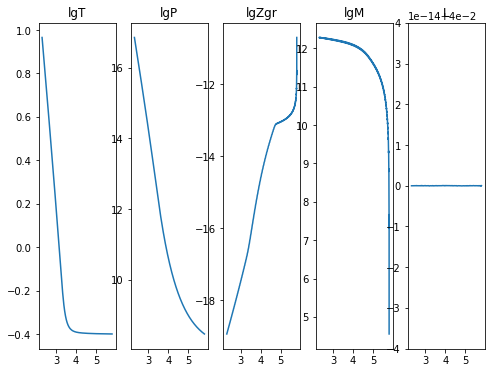

2020-12-06 05:31:01,993 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:31:03,082 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622808
2020-12-06 05:31:03,083 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-12-06 05:31:03,084 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:31:03,085 __main__ 0/1 INFO :: lgM iterate: 12.306662613109147
2020-12-06 05:31:03,085 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-12-06 05:31:03,086 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:31:03,087 __main__ 0/1 INFO :: L iterate: 0.04


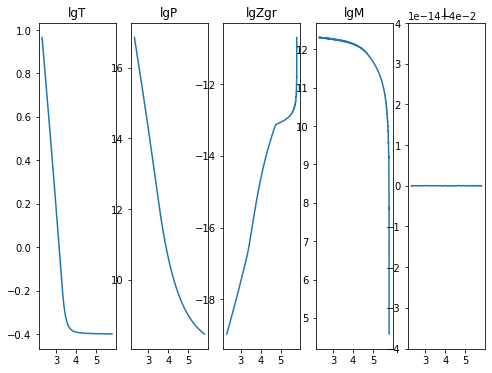

2020-12-06 05:31:06,812 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:07,961 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625921
2020-12-06 05:31:07,962 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894951
2020-12-06 05:31:07,963 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:31:07,964 __main__ 0/1 INFO :: lgM iterate: 12.278414437712684
2020-12-06 05:31:07,965 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118333
2020-12-06 05:31:07,966 __main__ 0/1 INFO :: m iterate: 1.6098110156015366e-05
2020-12-06 05:31:07,967 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


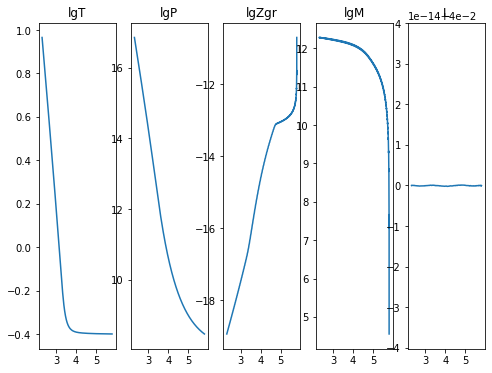

2020-12-06 05:31:11,660 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:31:12,750 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621036
2020-12-06 05:31:12,751 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-12-06 05:31:12,752 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:31:12,753 __main__ 0/1 INFO :: lgM iterate: 12.306662613109156
2020-12-06 05:31:12,754 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-12-06 05:31:12,755 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:31:12,756 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


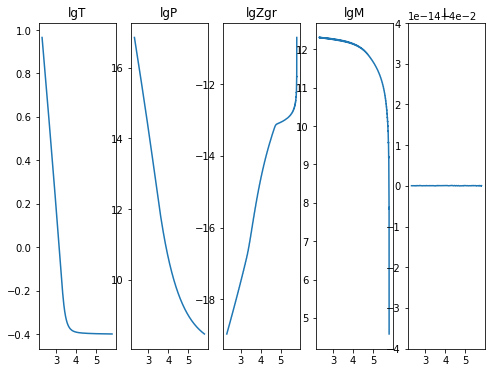

2020-12-06 05:31:16,519 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:17,631 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619555
2020-12-06 05:31:17,632 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:31:17,633 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:31:17,635 __main__ 0/1 INFO :: lgM iterate: 12.278414437712696
2020-12-06 05:31:17,636 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118334
2020-12-06 05:31:17,637 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:31:17,637 __main__ 0/1 INFO :: L iterate: 0.04


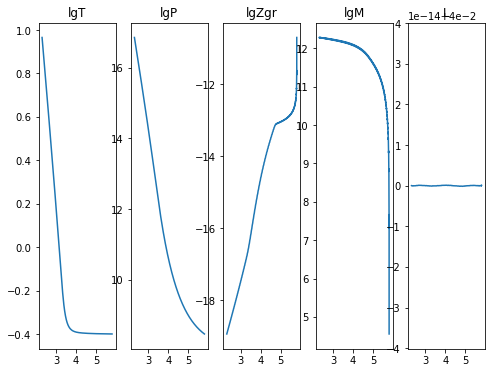

2020-12-06 05:31:21,346 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:22,419 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619222
2020-12-06 05:31:22,420 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234044
2020-12-06 05:31:22,421 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:31:22,421 __main__ 0/1 INFO :: lgM iterate: 12.306662613109177
2020-12-06 05:31:22,422 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063446
2020-12-06 05:31:22,423 __main__ 0/1 INFO :: m iterate: 1.6114013841050934e-05
2020-12-06 05:31:22,424 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


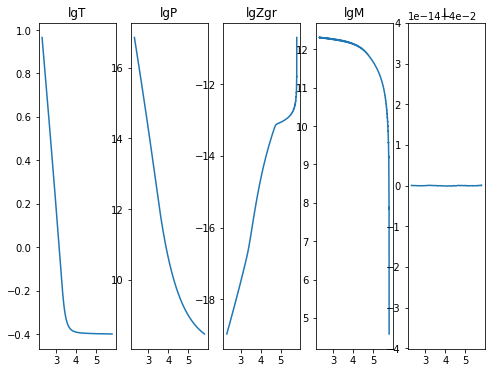

2020-12-06 05:31:26,295 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:31:27,324 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461779
2020-12-06 05:31:27,325 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:31:27,326 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:31:27,327 __main__ 0/1 INFO :: lgM iterate: 12.27841443771274
2020-12-06 05:31:27,328 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183363
2020-12-06 05:31:27,329 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:31:27,330 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


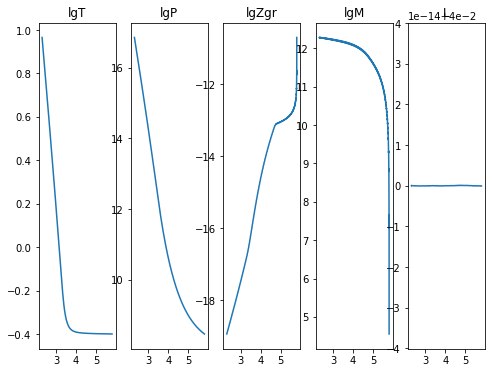

2020-12-06 05:31:30,941 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:32,116 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616682
2020-12-06 05:31:32,117 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234023
2020-12-06 05:31:32,118 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:31:32,119 __main__ 0/1 INFO :: lgM iterate: 12.306662613109227
2020-12-06 05:31:32,119 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063478
2020-12-06 05:31:32,121 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:31:32,122 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


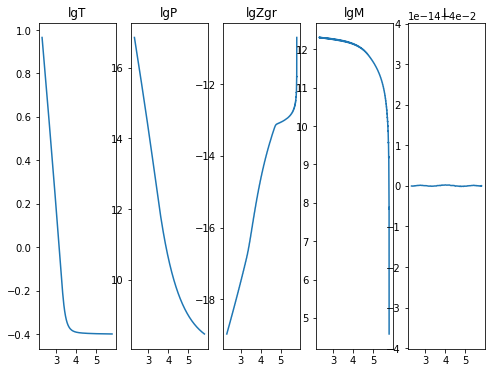

2020-12-06 05:31:35,828 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:31:36,858 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461641
2020-12-06 05:31:36,859 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:31:36,860 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:31:36,860 __main__ 0/1 INFO :: lgM iterate: 12.27841443771262
2020-12-06 05:31:36,861 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183285
2020-12-06 05:31:36,862 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:31:36,863 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


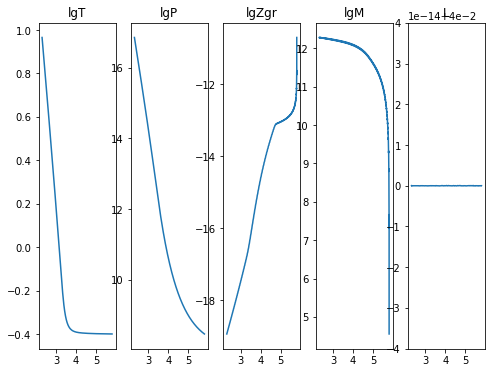

2020-12-06 05:31:40,429 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:41,433 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616318
2020-12-06 05:31:41,434 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234049
2020-12-06 05:31:41,435 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:31:41,436 __main__ 0/1 INFO :: lgM iterate: 12.306662613109157
2020-12-06 05:31:41,437 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063435
2020-12-06 05:31:41,438 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:31:41,439 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


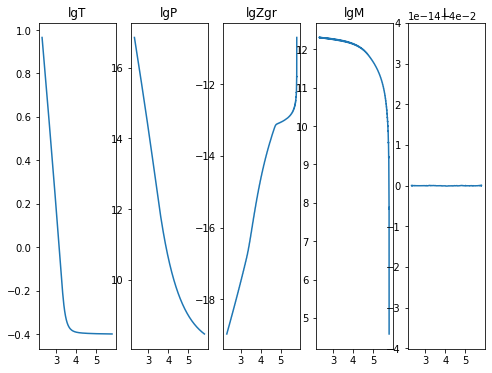

2020-12-06 05:31:45,057 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:46,031 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461368
2020-12-06 05:31:46,032 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:31:46,033 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:31:46,034 __main__ 0/1 INFO :: lgM iterate: 12.27841443771262
2020-12-06 05:31:46,034 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-12-06 05:31:46,035 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:31:46,036 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


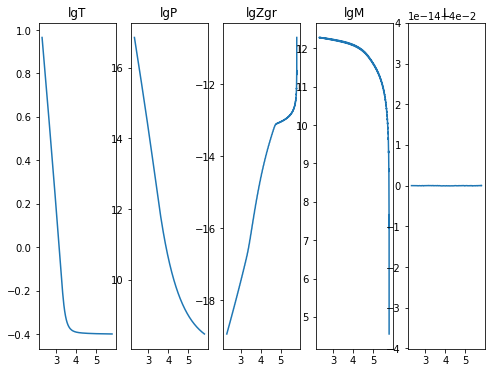

2020-12-06 05:31:49,621 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:50,592 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616087
2020-12-06 05:31:50,593 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-12-06 05:31:50,594 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:31:50,595 __main__ 0/1 INFO :: lgM iterate: 12.306662613109214
2020-12-06 05:31:50,596 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-12-06 05:31:50,597 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:31:50,598 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


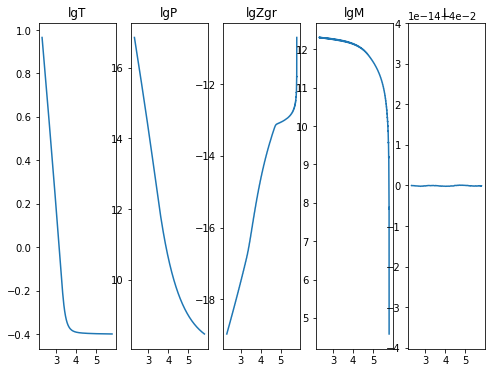

2020-12-06 05:31:54,224 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:55,208 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618363
2020-12-06 05:31:55,210 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894954
2020-12-06 05:31:55,210 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:31:55,211 __main__ 0/1 INFO :: lgM iterate: 12.278414437712648
2020-12-06 05:31:55,212 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-12-06 05:31:55,213 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:31:55,214 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


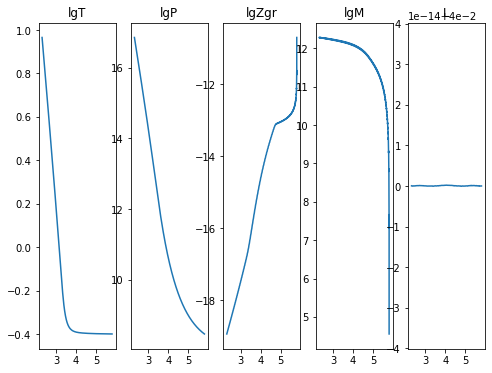

2020-12-06 05:31:58,800 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:31:59,751 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620728
2020-12-06 05:31:59,752 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-12-06 05:31:59,753 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:31:59,754 __main__ 0/1 INFO :: lgM iterate: 12.306662613109255
2020-12-06 05:31:59,755 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063495
2020-12-06 05:31:59,756 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:31:59,757 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


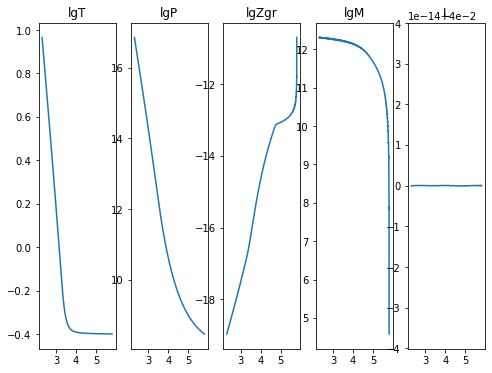

2020-12-06 05:32:03,395 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:04,387 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624629
2020-12-06 05:32:04,388 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894975
2020-12-06 05:32:04,389 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:32:04,390 __main__ 0/1 INFO :: lgM iterate: 12.278414437712662
2020-12-06 05:32:04,391 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:32:04,392 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:32:04,393 __main__ 0/1 INFO :: L iterate: 0.04


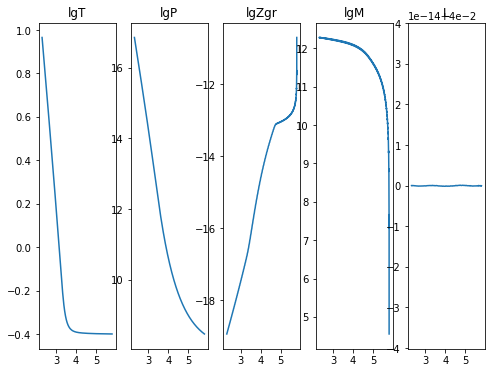

2020-12-06 05:32:07,989 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:08,974 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462374
2020-12-06 05:32:08,975 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234038
2020-12-06 05:32:08,976 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-12-06 05:32:08,976 __main__ 0/1 INFO :: lgM iterate: 12.306662613109205
2020-12-06 05:32:08,977 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:32:08,978 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:32:08,979 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


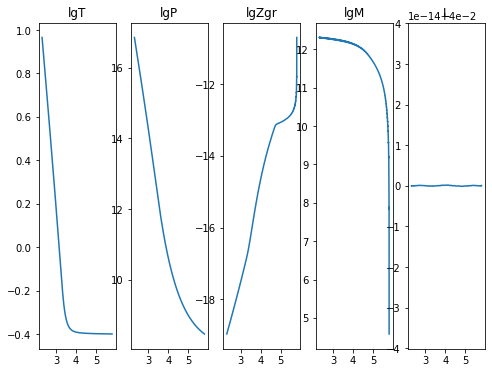

2020-12-06 05:32:12,681 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:13,703 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621403
2020-12-06 05:32:13,704 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894939
2020-12-06 05:32:13,705 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:32:13,706 __main__ 0/1 INFO :: lgM iterate: 12.278414437712772
2020-12-06 05:32:13,706 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118339
2020-12-06 05:32:13,707 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:32:13,708 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


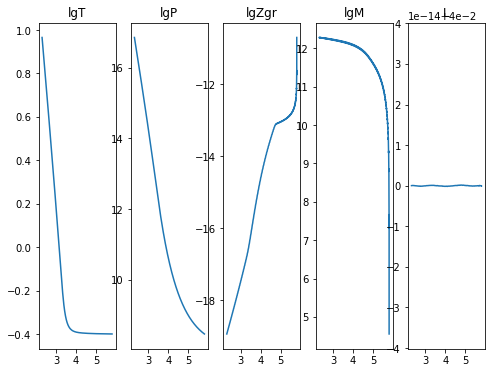

2020-12-06 05:32:17,294 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:18,260 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620776
2020-12-06 05:32:18,261 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:32:18,262 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:32:18,263 __main__ 0/1 INFO :: lgM iterate: 12.306662613109237
2020-12-06 05:32:18,265 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506349
2020-12-06 05:32:18,266 __main__ 0/1 INFO :: m iterate: 1.6114013836165952e-05
2020-12-06 05:32:18,266 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


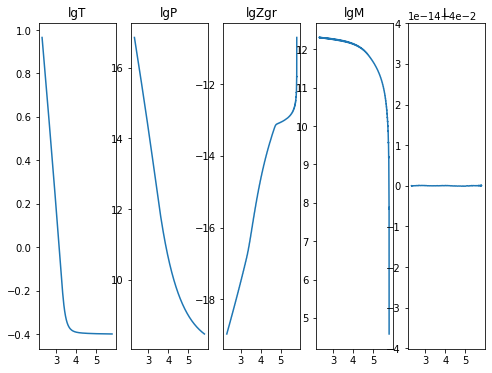

2020-12-06 05:32:21,882 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:32:22,866 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620001
2020-12-06 05:32:22,867 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894943
2020-12-06 05:32:22,868 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:32:22,868 __main__ 0/1 INFO :: lgM iterate: 12.278414437712698
2020-12-06 05:32:22,869 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183345
2020-12-06 05:32:22,870 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-12-06 05:32:22,871 __main__ 0/1 INFO :: L iterate: 0.04


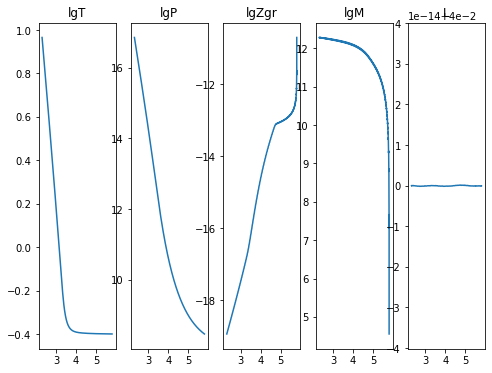

2020-12-06 05:32:26,531 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:27,489 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618814
2020-12-06 05:32:27,490 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234028
2020-12-06 05:32:27,491 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-12-06 05:32:27,491 __main__ 0/1 INFO :: lgM iterate: 12.306662613109125
2020-12-06 05:32:27,492 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063407
2020-12-06 05:32:27,493 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:32:27,494 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


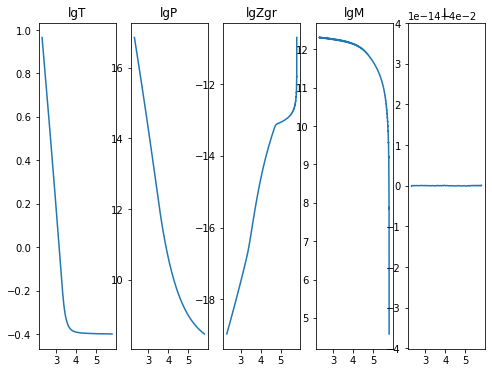

2020-12-06 05:32:31,205 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:32,184 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619076
2020-12-06 05:32:32,185 __main__ 0/1 INFO :: lgT iterate: 0.965684908089496
2020-12-06 05:32:32,186 __main__ 0/1 INFO :: lgP iterate: 16.85032943387845
2020-12-06 05:32:32,187 __main__ 0/1 INFO :: lgM iterate: 12.278414437712671
2020-12-06 05:32:32,188 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:32:32,189 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-12-06 05:32:32,190 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


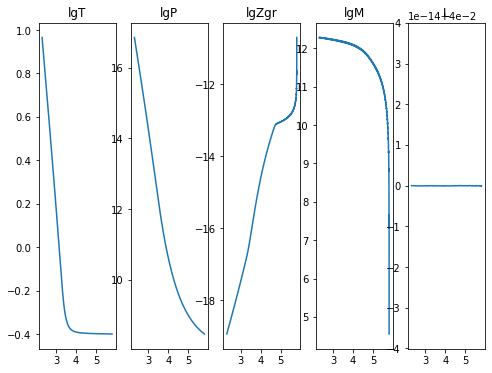

2020-12-06 05:32:35,834 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:36,858 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617577
2020-12-06 05:32:36,859 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234035
2020-12-06 05:32:36,860 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:32:36,861 __main__ 0/1 INFO :: lgM iterate: 12.3066626131091
2020-12-06 05:32:36,862 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063396
2020-12-06 05:32:36,863 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:32:36,863 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


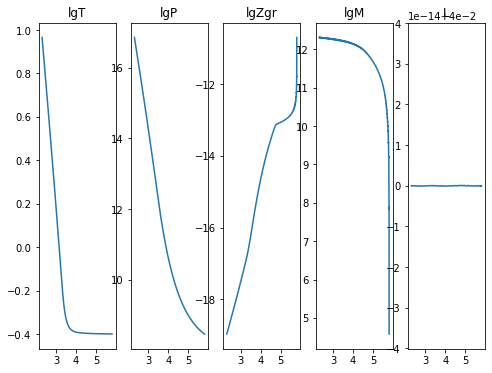

2020-12-06 05:32:40,500 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:41,502 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615891
2020-12-06 05:32:41,503 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894967
2020-12-06 05:32:41,504 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:32:41,505 __main__ 0/1 INFO :: lgM iterate: 12.278414437712666
2020-12-06 05:32:41,506 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:32:41,507 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:32:41,507 __main__ 0/1 INFO :: L iterate: 0.03999999999999996


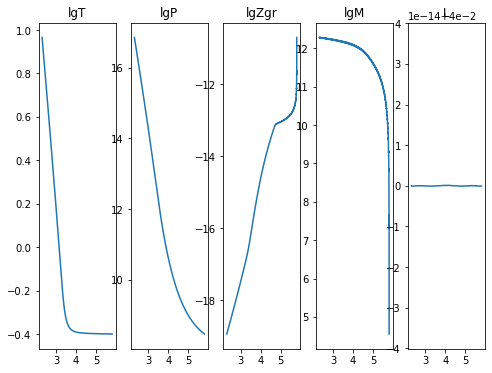

2020-12-06 05:32:45,108 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:46,211 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617965
2020-12-06 05:32:46,212 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:32:46,213 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:32:46,214 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:32:46,214 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063456
2020-12-06 05:32:46,215 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:32:46,216 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


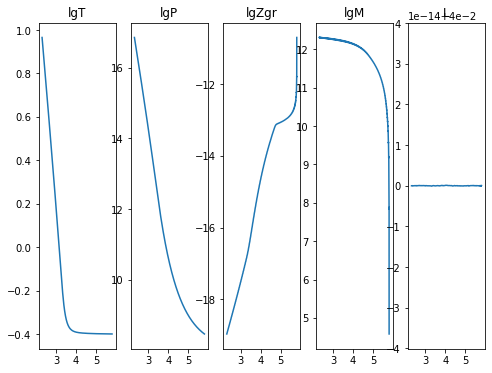

2020-12-06 05:32:49,979 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:51,070 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619167
2020-12-06 05:32:51,071 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894937
2020-12-06 05:32:51,072 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:32:51,072 __main__ 0/1 INFO :: lgM iterate: 12.27841443771275
2020-12-06 05:32:51,073 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183373
2020-12-06 05:32:51,074 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:32:51,075 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


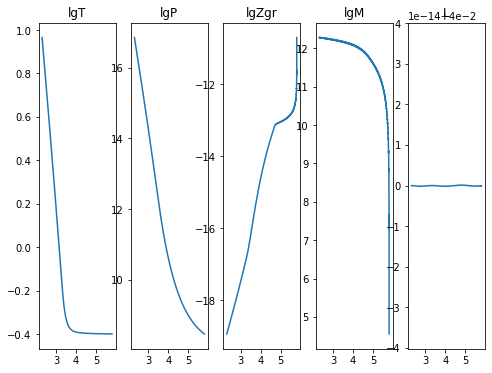

2020-12-06 05:32:54,716 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:32:55,710 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621884
2020-12-06 05:32:55,711 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234025
2020-12-06 05:32:55,712 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:32:55,713 __main__ 0/1 INFO :: lgM iterate: 12.306662613109088
2020-12-06 05:32:55,714 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063382
2020-12-06 05:32:55,715 __main__ 0/1 INFO :: m iterate: 1.6114013841495023e-05
2020-12-06 05:32:55,716 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


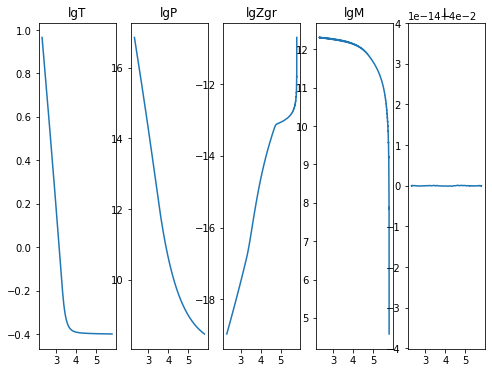

2020-12-06 05:32:59,353 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:00,444 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624502
2020-12-06 05:33:00,445 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894938
2020-12-06 05:33:00,446 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:33:00,447 __main__ 0/1 INFO :: lgM iterate: 12.278414437712664
2020-12-06 05:33:00,447 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-12-06 05:33:00,448 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:33:00,449 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


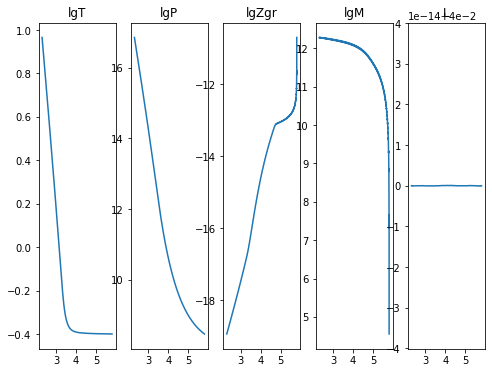

2020-12-06 05:33:04,136 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:33:05,189 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462147
2020-12-06 05:33:05,190 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:33:05,191 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-12-06 05:33:05,192 __main__ 0/1 INFO :: lgM iterate: 12.30666261310915
2020-12-06 05:33:05,192 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063424
2020-12-06 05:33:05,193 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:33:05,194 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


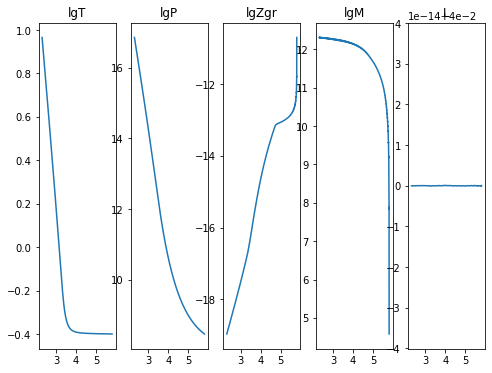

2020-12-06 05:33:08,971 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:09,986 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618214
2020-12-06 05:33:09,987 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894985
2020-12-06 05:33:09,988 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:33:09,989 __main__ 0/1 INFO :: lgM iterate: 12.27841443771266
2020-12-06 05:33:09,989 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183317
2020-12-06 05:33:09,990 __main__ 0/1 INFO :: m iterate: 1.6098110161344437e-05
2020-12-06 05:33:09,991 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


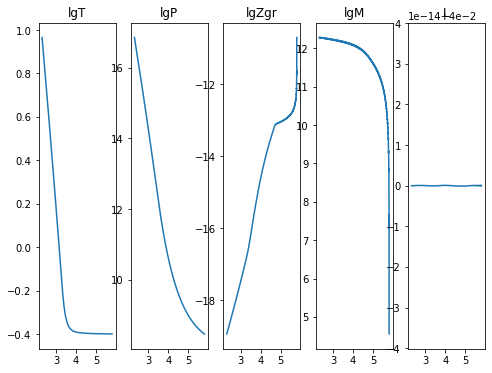

2020-12-06 05:33:13,719 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:33:14,777 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619961
2020-12-06 05:33:14,778 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-12-06 05:33:14,779 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:33:14,779 __main__ 0/1 INFO :: lgM iterate: 12.306662613109149
2020-12-06 05:33:14,780 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-12-06 05:33:14,781 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:33:14,782 __main__ 0/1 INFO :: L iterate: 0.04


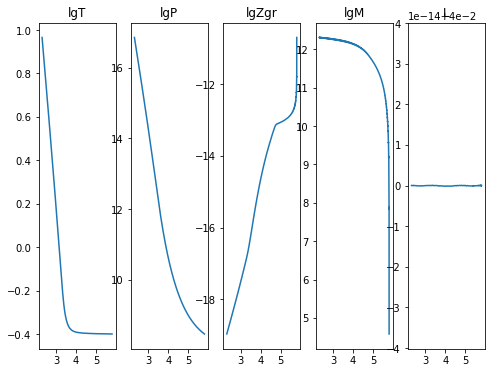

2020-12-06 05:33:18,500 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:19,530 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621673
2020-12-06 05:33:19,531 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894957
2020-12-06 05:33:19,532 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:33:19,533 __main__ 0/1 INFO :: lgM iterate: 12.278414437712751
2020-12-06 05:33:19,533 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183373
2020-12-06 05:33:19,534 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:33:19,535 __main__ 0/1 INFO :: L iterate: 0.04


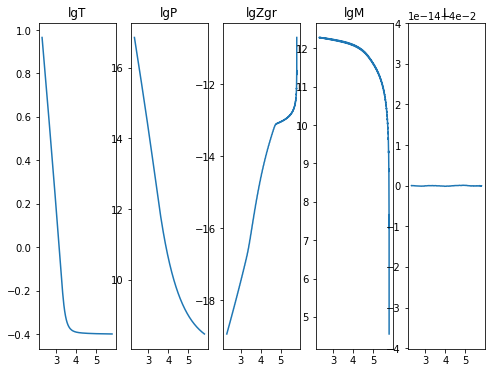

2020-12-06 05:33:23,229 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:33:24,328 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622717
2020-12-06 05:33:24,329 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234047
2020-12-06 05:33:24,330 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:33:24,331 __main__ 0/1 INFO :: lgM iterate: 12.306662613109143
2020-12-06 05:33:24,332 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063428
2020-12-06 05:33:24,333 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:33:24,334 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


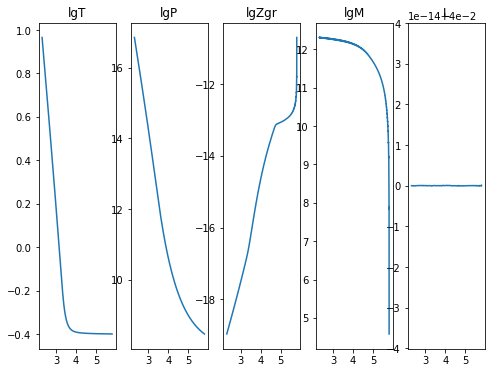

2020-12-06 05:33:28,165 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:29,200 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623463
2020-12-06 05:33:29,201 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:33:29,202 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:33:29,203 __main__ 0/1 INFO :: lgM iterate: 12.278414437712701
2020-12-06 05:33:29,204 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183334
2020-12-06 05:33:29,205 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-12-06 05:33:29,206 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


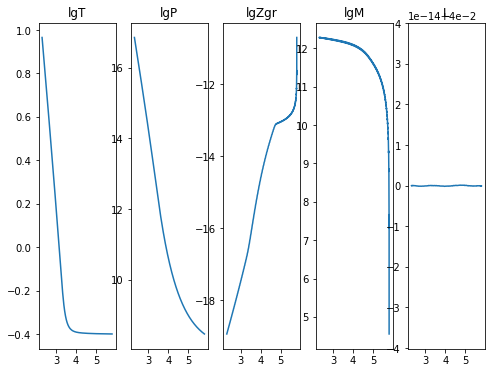

2020-12-06 05:33:32,856 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:33,859 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620381
2020-12-06 05:33:33,860 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:33:33,861 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:33:33,861 __main__ 0/1 INFO :: lgM iterate: 12.306662613109063
2020-12-06 05:33:33,862 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506337
2020-12-06 05:33:33,863 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:33:33,864 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


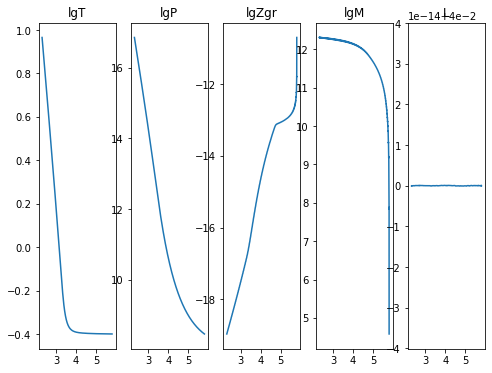

2020-12-06 05:33:37,455 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:38,437 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461758
2020-12-06 05:33:38,438 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:33:38,439 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:33:38,440 __main__ 0/1 INFO :: lgM iterate: 12.278414437712689
2020-12-06 05:33:38,441 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183324
2020-12-06 05:33:38,442 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:33:38,443 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


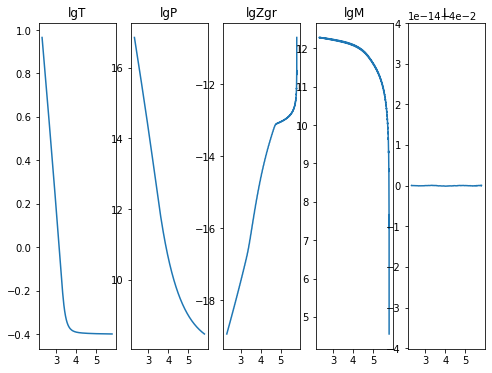

2020-12-06 05:33:42,031 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:33:43,052 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619693
2020-12-06 05:33:43,053 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234034
2020-12-06 05:33:43,054 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:33:43,054 __main__ 0/1 INFO :: lgM iterate: 12.306662613109204
2020-12-06 05:33:43,055 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-12-06 05:33:43,057 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:33:43,058 __main__ 0/1 INFO :: L iterate: 0.04


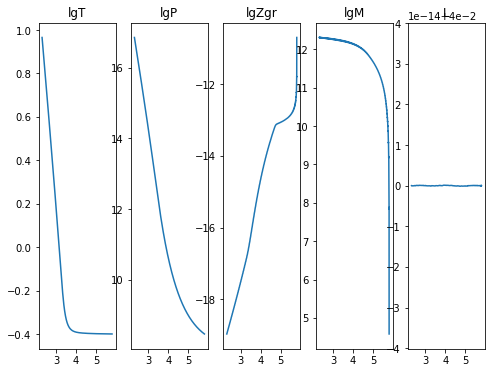

2020-12-06 05:33:46,717 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:47,760 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621156
2020-12-06 05:33:47,762 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-12-06 05:33:47,762 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:33:47,763 __main__ 0/1 INFO :: lgM iterate: 12.278414437712655
2020-12-06 05:33:47,764 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-12-06 05:33:47,765 __main__ 0/1 INFO :: m iterate: 1.6098110160900347e-05
2020-12-06 05:33:47,766 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


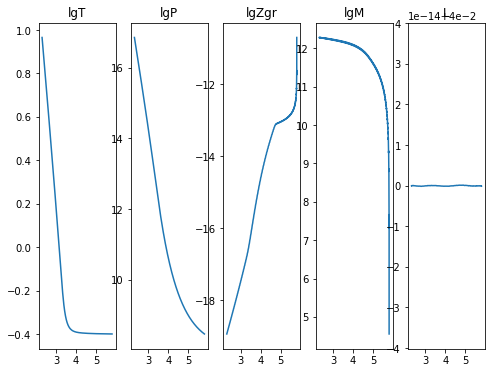

2020-12-06 05:33:51,441 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:52,445 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620075
2020-12-06 05:33:52,446 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:33:52,447 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:33:52,447 __main__ 0/1 INFO :: lgM iterate: 12.306662613109111
2020-12-06 05:33:52,448 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150634
2020-12-06 05:33:52,449 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:33:52,449 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


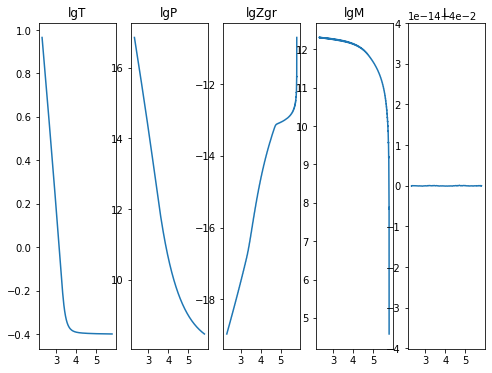

2020-12-06 05:33:56,079 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:33:57,063 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617848
2020-12-06 05:33:57,064 __main__ 0/1 INFO :: lgT iterate: 0.965684908089496
2020-12-06 05:33:57,065 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:33:57,066 __main__ 0/1 INFO :: lgM iterate: 12.278414437712629
2020-12-06 05:33:57,066 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118329
2020-12-06 05:33:57,067 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:33:57,068 __main__ 0/1 INFO :: L iterate: 0.04


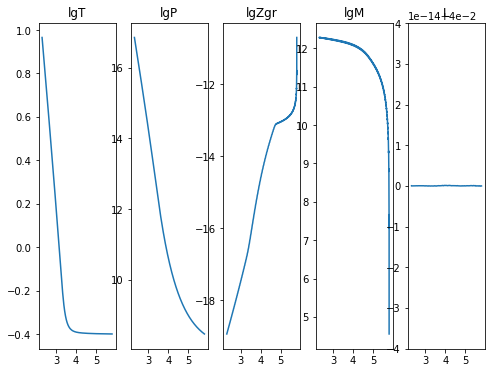

2020-12-06 05:34:00,666 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:01,693 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461673
2020-12-06 05:34:01,694 __main__ 0/1 INFO :: lgT iterate: 0.965671625123404
2020-12-06 05:34:01,695 __main__ 0/1 INFO :: lgP iterate: 16.85129947116727
2020-12-06 05:34:01,696 __main__ 0/1 INFO :: lgM iterate: 12.306662613109147
2020-12-06 05:34:01,696 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063424
2020-12-06 05:34:01,697 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:34:01,698 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


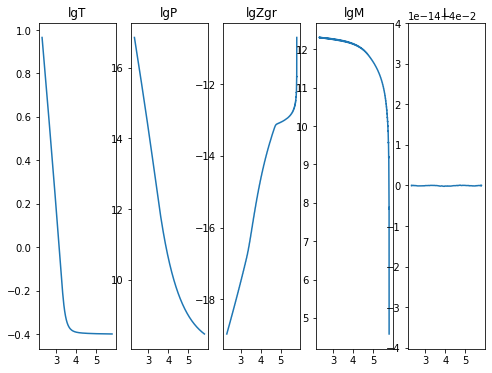

2020-12-06 05:34:05,417 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:06,388 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617348
2020-12-06 05:34:06,390 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:34:06,390 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:34:06,391 __main__ 0/1 INFO :: lgM iterate: 12.27841443771279
2020-12-06 05:34:06,392 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183395
2020-12-06 05:34:06,394 __main__ 0/1 INFO :: m iterate: 1.6098110155571277e-05
2020-12-06 05:34:06,395 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


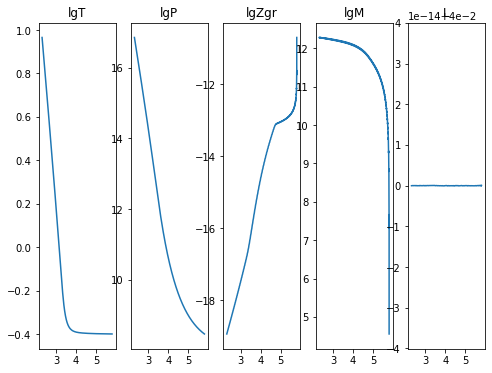

2020-12-06 05:34:10,001 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:10,998 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621431
2020-12-06 05:34:10,999 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234057
2020-12-06 05:34:11,000 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:34:11,001 __main__ 0/1 INFO :: lgM iterate: 12.306662613109257
2020-12-06 05:34:11,002 __main__ 0/1 INFO :: lgZgr iterate: -18.9645814150635
2020-12-06 05:34:11,003 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:34:11,003 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


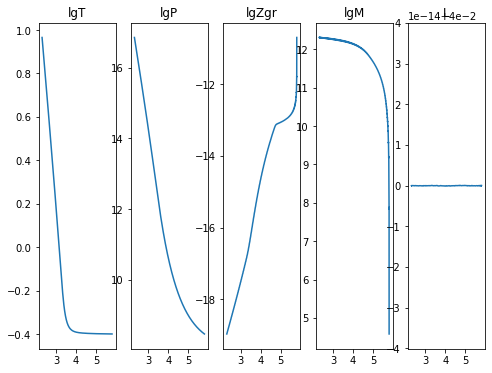

2020-12-06 05:34:14,641 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:15,824 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622988
2020-12-06 05:34:15,825 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894961
2020-12-06 05:34:15,826 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:34:15,827 __main__ 0/1 INFO :: lgM iterate: 12.278414437712721
2020-12-06 05:34:15,828 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118336
2020-12-06 05:34:15,828 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:34:15,829 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


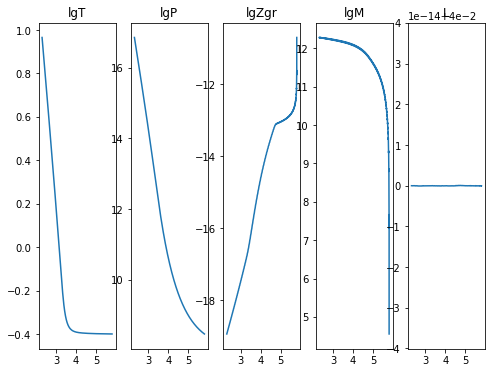

2020-12-06 05:34:19,633 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:20,633 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622013
2020-12-06 05:34:20,634 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234029
2020-12-06 05:34:20,635 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:34:20,636 __main__ 0/1 INFO :: lgM iterate: 12.306662613109252
2020-12-06 05:34:20,636 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063492
2020-12-06 05:34:20,637 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:34:20,638 __main__ 0/1 INFO :: L iterate: 0.04


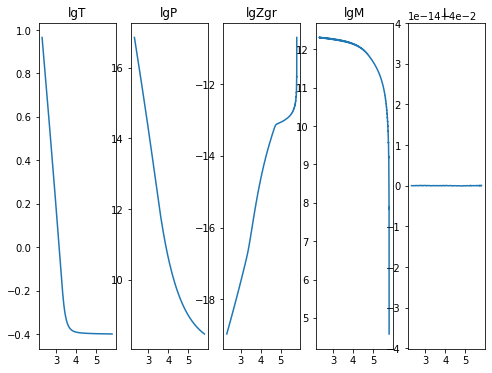

2020-12-06 05:34:24,427 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:25,454 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462204
2020-12-06 05:34:25,455 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894927
2020-12-06 05:34:25,456 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:34:25,457 __main__ 0/1 INFO :: lgM iterate: 12.278414437712733
2020-12-06 05:34:25,458 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183363
2020-12-06 05:34:25,459 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:34:25,459 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


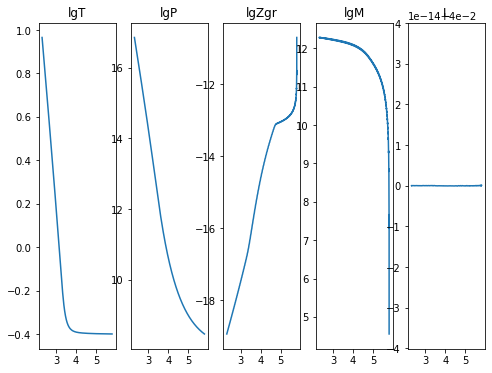

2020-12-06 05:34:29,334 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:34:30,381 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621647
2020-12-06 05:34:30,382 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234047
2020-12-06 05:34:30,382 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:34:30,383 __main__ 0/1 INFO :: lgM iterate: 12.306662613109161
2020-12-06 05:34:30,384 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-12-06 05:34:30,384 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:34:30,385 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


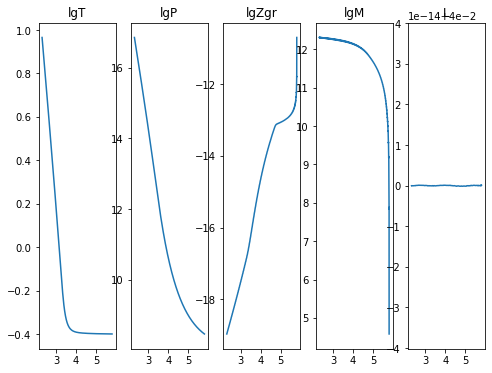

2020-12-06 05:34:34,145 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:34:35,205 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462095
2020-12-06 05:34:35,206 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894989
2020-12-06 05:34:35,206 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:34:35,207 __main__ 0/1 INFO :: lgM iterate: 12.278414437712648
2020-12-06 05:34:35,208 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183306
2020-12-06 05:34:35,209 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:34:35,209 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


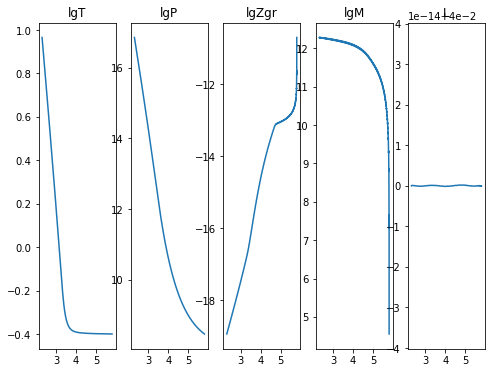

2020-12-06 05:34:38,858 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:39,859 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622697
2020-12-06 05:34:39,860 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234058
2020-12-06 05:34:39,861 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:34:39,862 __main__ 0/1 INFO :: lgM iterate: 12.306662613109307
2020-12-06 05:34:39,863 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063535
2020-12-06 05:34:39,864 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:34:39,864 __main__ 0/1 INFO :: L iterate: 0.039999999999999966


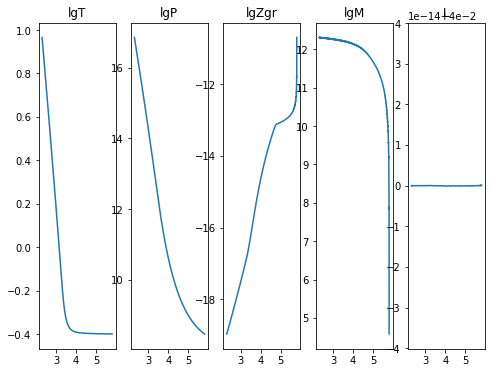

2020-12-06 05:34:43,570 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:44,567 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623352
2020-12-06 05:34:44,568 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-12-06 05:34:44,569 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:34:44,570 __main__ 0/1 INFO :: lgM iterate: 12.278414437712666
2020-12-06 05:34:44,571 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118332
2020-12-06 05:34:44,572 __main__ 0/1 INFO :: m iterate: 1.609811016001217e-05
2020-12-06 05:34:44,573 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


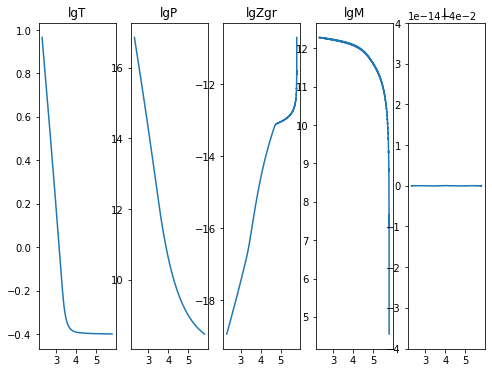

2020-12-06 05:34:48,184 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:34:49,190 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625377
2020-12-06 05:34:49,191 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234038
2020-12-06 05:34:49,192 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:34:49,192 __main__ 0/1 INFO :: lgM iterate: 12.306662613109168
2020-12-06 05:34:49,193 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063442
2020-12-06 05:34:49,194 __main__ 0/1 INFO :: m iterate: 1.6114013841939112e-05
2020-12-06 05:34:49,195 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


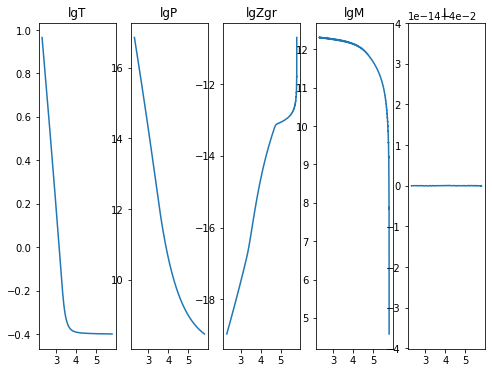

2020-12-06 05:34:52,795 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:34:53,801 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462762
2020-12-06 05:34:53,802 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:34:53,803 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:34:53,804 __main__ 0/1 INFO :: lgM iterate: 12.278414437712755
2020-12-06 05:34:53,805 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118337
2020-12-06 05:34:53,806 __main__ 0/1 INFO :: m iterate: 1.6098110163564883e-05
2020-12-06 05:34:53,807 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


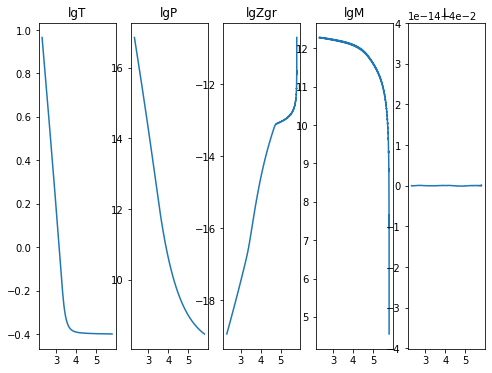

2020-12-06 05:34:57,447 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:34:58,465 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474628308
2020-12-06 05:34:58,467 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-12-06 05:34:58,467 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:34:58,468 __main__ 0/1 INFO :: lgM iterate: 12.306662613109241
2020-12-06 05:34:58,469 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506349
2020-12-06 05:34:58,470 __main__ 0/1 INFO :: m iterate: 1.6114013836165952e-05
2020-12-06 05:34:58,471 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


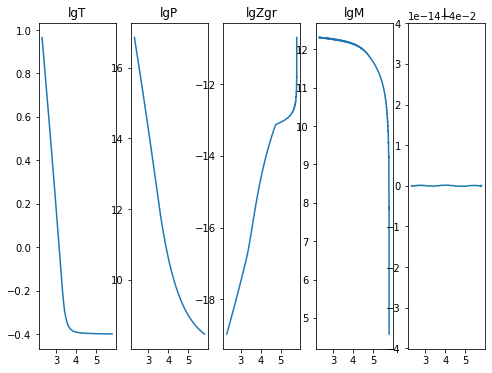

2020-12-06 05:35:02,117 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:03,112 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474629705
2020-12-06 05:35:03,113 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894943
2020-12-06 05:35:03,114 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:35:03,115 __main__ 0/1 INFO :: lgM iterate: 12.278414437712627
2020-12-06 05:35:03,115 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-12-06 05:35:03,116 __main__ 0/1 INFO :: m iterate: 1.6098110156459455e-05
2020-12-06 05:35:03,117 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


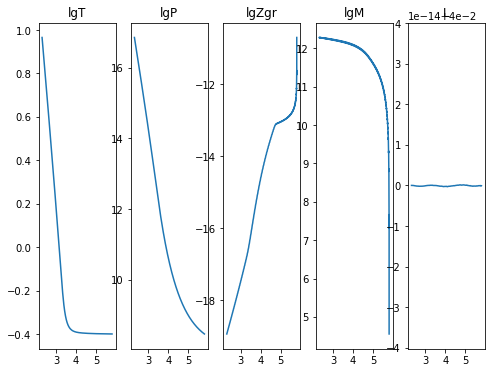

2020-12-06 05:35:06,775 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:07,838 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474627953
2020-12-06 05:35:07,839 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:35:07,840 __main__ 0/1 INFO :: lgP iterate: 16.851299471167284
2020-12-06 05:35:07,841 __main__ 0/1 INFO :: lgM iterate: 12.306662613109268
2020-12-06 05:35:07,842 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063506
2020-12-06 05:35:07,843 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:35:07,844 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


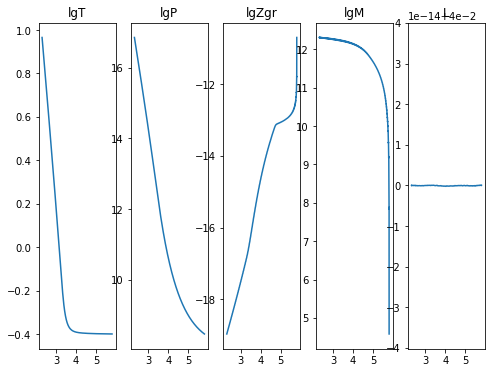

2020-12-06 05:35:11,474 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:12,466 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474626332
2020-12-06 05:35:12,467 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894978
2020-12-06 05:35:12,467 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:35:12,468 __main__ 0/1 INFO :: lgM iterate: 12.278414437712591
2020-12-06 05:35:12,469 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183267
2020-12-06 05:35:12,470 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:35:12,471 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


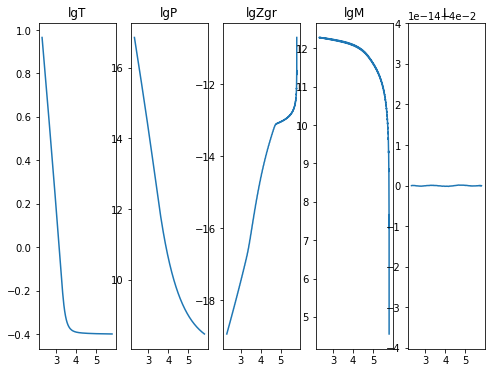

2020-12-06 05:35:16,069 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:17,074 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474624456
2020-12-06 05:35:17,075 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234045
2020-12-06 05:35:17,076 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:35:17,077 __main__ 0/1 INFO :: lgM iterate: 12.3066626131091
2020-12-06 05:35:17,078 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063392
2020-12-06 05:35:17,079 __main__ 0/1 INFO :: m iterate: 1.6114013841939112e-05
2020-12-06 05:35:17,079 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


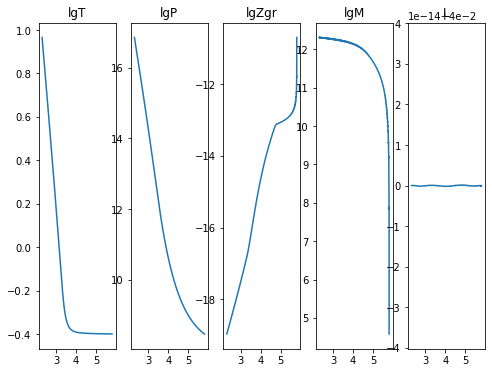

2020-12-06 05:35:20,795 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:21,782 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621474
2020-12-06 05:35:21,783 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894938
2020-12-06 05:35:21,784 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:35:21,785 __main__ 0/1 INFO :: lgM iterate: 12.278414437712703
2020-12-06 05:35:21,786 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183345
2020-12-06 05:35:21,787 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:35:21,787 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


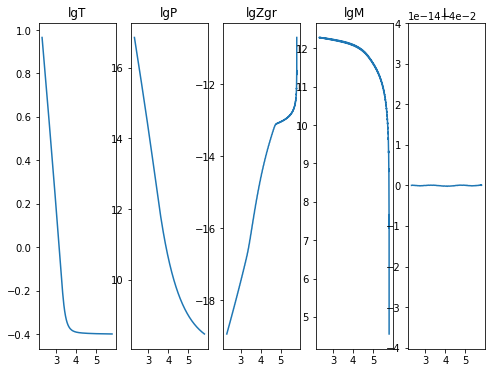

2020-12-06 05:35:25,548 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:35:26,585 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621927
2020-12-06 05:35:26,586 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-12-06 05:35:26,587 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:35:26,587 __main__ 0/1 INFO :: lgM iterate: 12.30666261310918
2020-12-06 05:35:26,588 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063453
2020-12-06 05:35:26,589 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-12-06 05:35:26,590 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


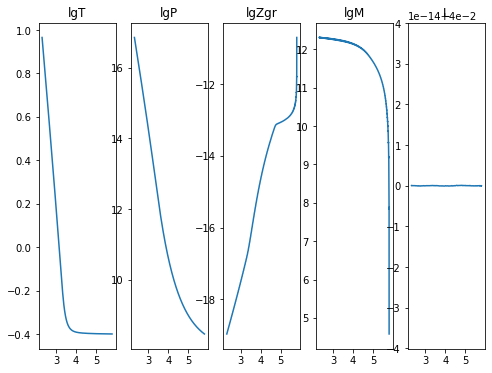

2020-12-06 05:35:30,249 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:35:31,237 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621587
2020-12-06 05:35:31,238 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-12-06 05:35:31,239 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:35:31,240 __main__ 0/1 INFO :: lgM iterate: 12.27841443771256
2020-12-06 05:35:31,241 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183246
2020-12-06 05:35:31,242 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:35:31,242 __main__ 0/1 INFO :: L iterate: 0.03999999999999997


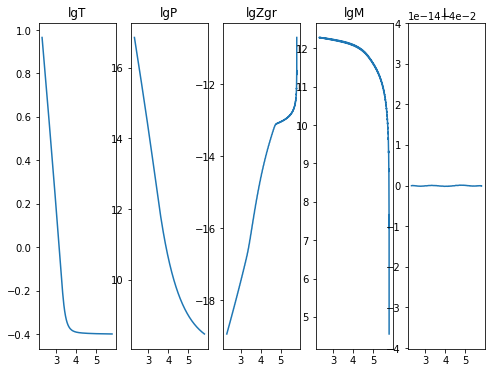

2020-12-06 05:35:35,523 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:35:36,478 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474619786
2020-12-06 05:35:36,480 __main__ 0/1 INFO :: lgT iterate: 0.965671625123405
2020-12-06 05:35:36,480 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:35:36,482 __main__ 0/1 INFO :: lgM iterate: 12.306662613109257
2020-12-06 05:35:36,483 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063506
2020-12-06 05:35:36,484 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:35:36,485 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


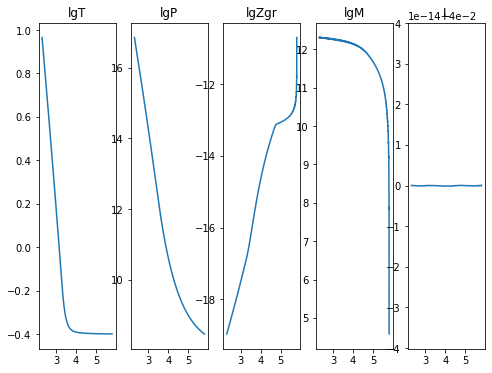

2020-12-06 05:35:40,350 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:35:41,341 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618665
2020-12-06 05:35:41,342 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894948
2020-12-06 05:35:41,343 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:35:41,343 __main__ 0/1 INFO :: lgM iterate: 12.278414437712735
2020-12-06 05:35:41,344 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183366
2020-12-06 05:35:41,345 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:35:41,346 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


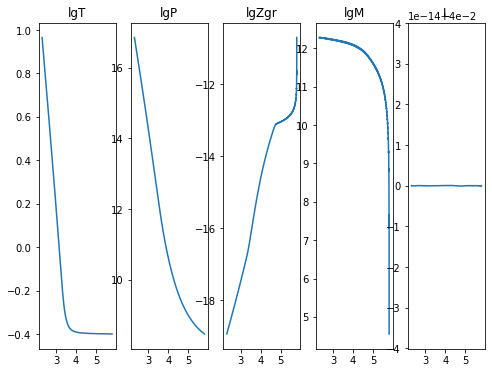

2020-12-06 05:35:45,750 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:35:46,924 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461971
2020-12-06 05:35:46,925 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:35:46,926 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:35:46,927 __main__ 0/1 INFO :: lgM iterate: 12.30666261310906
2020-12-06 05:35:46,928 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063364
2020-12-06 05:35:46,929 __main__ 0/1 INFO :: m iterate: 1.6114013840606844e-05
2020-12-06 05:35:46,930 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


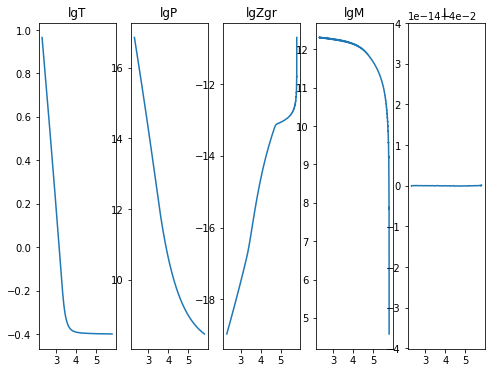

2020-12-06 05:35:50,918 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:51,960 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622217
2020-12-06 05:35:51,961 __main__ 0/1 INFO :: lgT iterate: 0.965684908089494
2020-12-06 05:35:51,962 __main__ 0/1 INFO :: lgP iterate: 16.850329433878443
2020-12-06 05:35:51,962 __main__ 0/1 INFO :: lgM iterate: 12.278414437712655
2020-12-06 05:35:51,963 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118331
2020-12-06 05:35:51,964 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:35:51,965 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


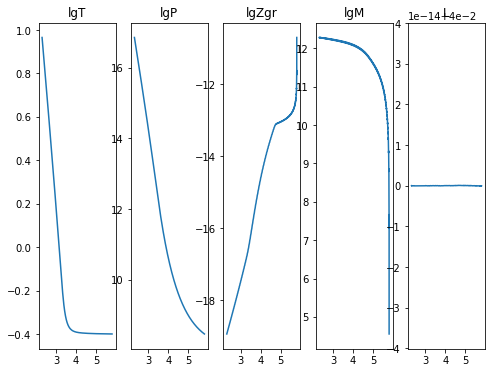

2020-12-06 05:35:56,052 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:35:57,057 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625248
2020-12-06 05:35:57,059 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234041
2020-12-06 05:35:57,059 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:35:57,060 __main__ 0/1 INFO :: lgM iterate: 12.3066626131092
2020-12-06 05:35:57,061 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506346
2020-12-06 05:35:57,063 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:35:57,064 __main__ 0/1 INFO :: L iterate: 0.04


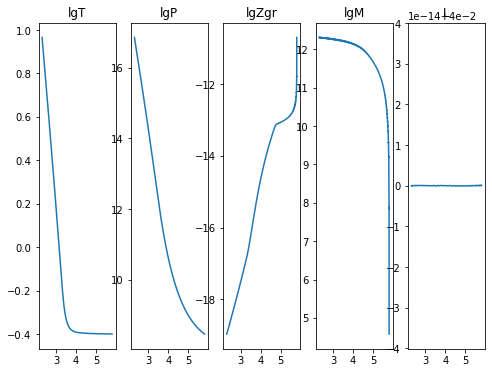

2020-12-06 05:36:01,238 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:02,284 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474627846
2020-12-06 05:36:02,285 __main__ 0/1 INFO :: lgT iterate: 0.965684908089495
2020-12-06 05:36:02,286 __main__ 0/1 INFO :: lgP iterate: 16.850329433878457
2020-12-06 05:36:02,287 __main__ 0/1 INFO :: lgM iterate: 12.278414437712641
2020-12-06 05:36:02,288 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183295
2020-12-06 05:36:02,288 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-12-06 05:36:02,289 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


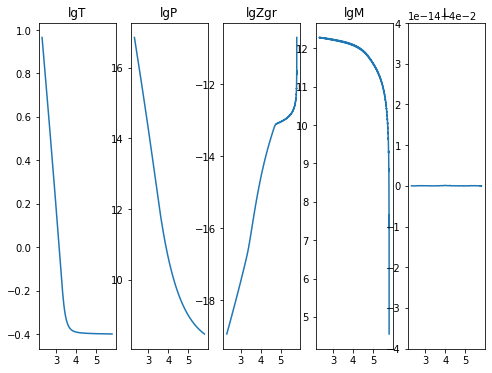

2020-12-06 05:36:05,987 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:07,199 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462534
2020-12-06 05:36:07,200 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234021
2020-12-06 05:36:07,201 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:36:07,201 __main__ 0/1 INFO :: lgM iterate: 12.306662613109221
2020-12-06 05:36:07,202 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506347
2020-12-06 05:36:07,203 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:36:07,204 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


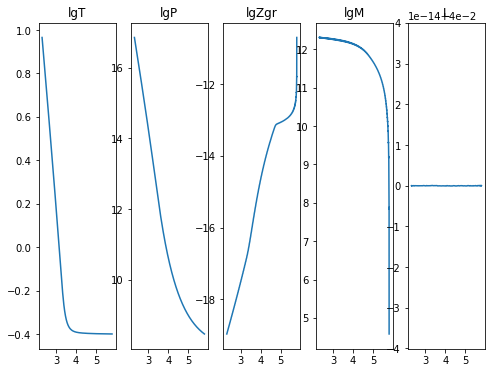

2020-12-06 05:36:10,960 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:11,948 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622548
2020-12-06 05:36:11,949 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894958
2020-12-06 05:36:11,949 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:36:11,950 __main__ 0/1 INFO :: lgM iterate: 12.27841443771264
2020-12-06 05:36:11,951 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183302
2020-12-06 05:36:11,951 __main__ 0/1 INFO :: m iterate: 1.6098110156015366e-05
2020-12-06 05:36:11,952 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


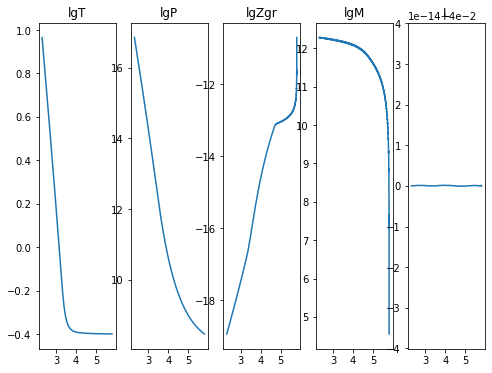

2020-12-06 05:36:15,556 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:16,574 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618518
2020-12-06 05:36:16,575 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-12-06 05:36:16,576 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:36:16,577 __main__ 0/1 INFO :: lgM iterate: 12.306662613109093
2020-12-06 05:36:16,577 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506339
2020-12-06 05:36:16,578 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:36:16,579 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


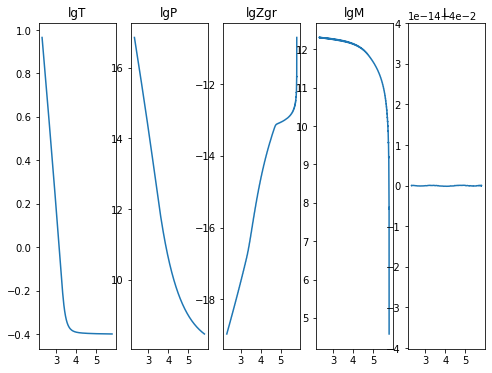

2020-12-06 05:36:20,336 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:36:21,325 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474615485
2020-12-06 05:36:21,326 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894955
2020-12-06 05:36:21,327 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:36:21,327 __main__ 0/1 INFO :: lgM iterate: 12.278414437712584
2020-12-06 05:36:21,328 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183263
2020-12-06 05:36:21,329 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:36:21,329 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


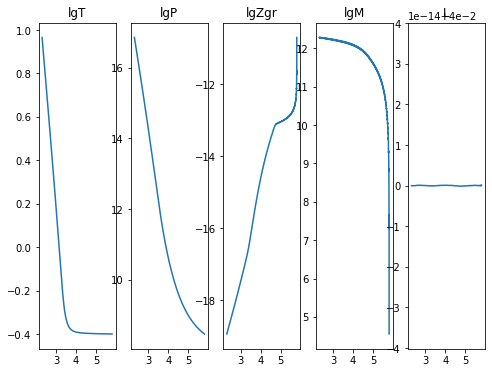

2020-12-06 05:36:25,558 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:36:26,618 __main__ 0/1 INFO :: Perturbation norm: 1.672075147461963
2020-12-06 05:36:26,619 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-12-06 05:36:26,620 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:36:26,621 __main__ 0/1 INFO :: lgM iterate: 12.306662613109317
2020-12-06 05:36:26,621 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506354
2020-12-06 05:36:26,622 __main__ 0/1 INFO :: m iterate: 1.6114013840162755e-05
2020-12-06 05:36:26,623 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


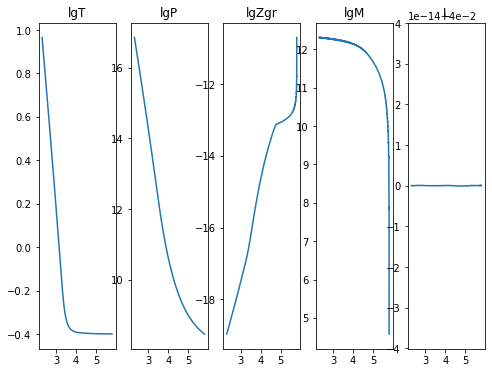

2020-12-06 05:36:30,502 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:36:31,520 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622766
2020-12-06 05:36:31,521 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:36:31,522 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:36:31,523 __main__ 0/1 INFO :: lgM iterate: 12.27841443771273
2020-12-06 05:36:31,524 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118336
2020-12-06 05:36:31,525 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:36:31,526 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


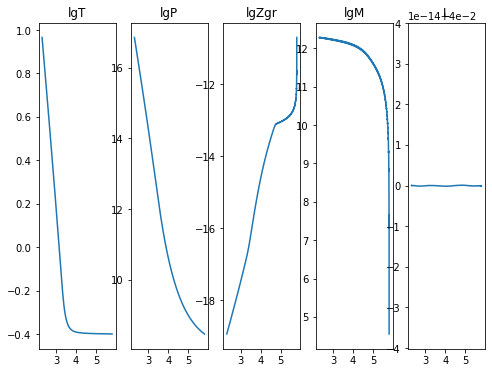

2020-12-06 05:36:35,172 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:36,176 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462325
2020-12-06 05:36:36,177 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234048
2020-12-06 05:36:36,178 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:36:36,179 __main__ 0/1 INFO :: lgM iterate: 12.306662613109136
2020-12-06 05:36:36,180 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506342
2020-12-06 05:36:36,181 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:36:36,181 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


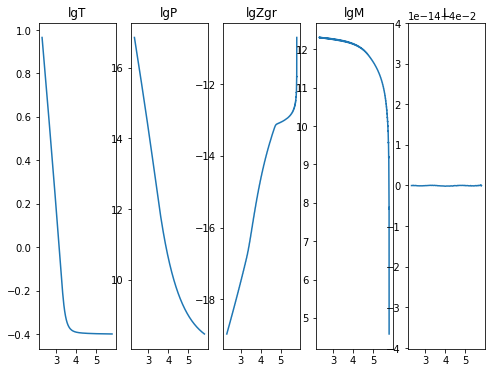

2020-12-06 05:36:39,853 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.7e+00/s
2020-12-06 05:36:40,833 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623754
2020-12-06 05:36:40,834 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894944
2020-12-06 05:36:40,835 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:36:40,836 __main__ 0/1 INFO :: lgM iterate: 12.278414437712659
2020-12-06 05:36:40,836 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118332
2020-12-06 05:36:40,837 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:36:40,838 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


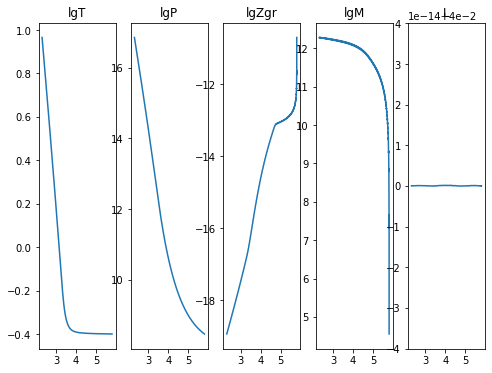

2020-12-06 05:36:44,501 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:36:45,490 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623712
2020-12-06 05:36:45,492 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234061
2020-12-06 05:36:45,492 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:36:45,493 __main__ 0/1 INFO :: lgM iterate: 12.306662613109246
2020-12-06 05:36:45,494 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063495
2020-12-06 05:36:45,495 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:36:45,496 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


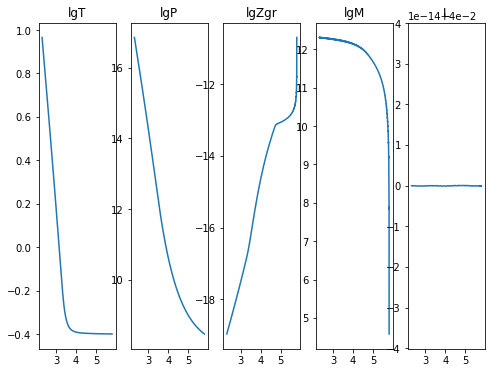

2020-12-06 05:36:49,128 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:50,120 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462234
2020-12-06 05:36:50,121 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:36:50,122 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:36:50,122 __main__ 0/1 INFO :: lgM iterate: 12.278414437712657
2020-12-06 05:36:50,123 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183313
2020-12-06 05:36:50,124 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:36:50,125 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


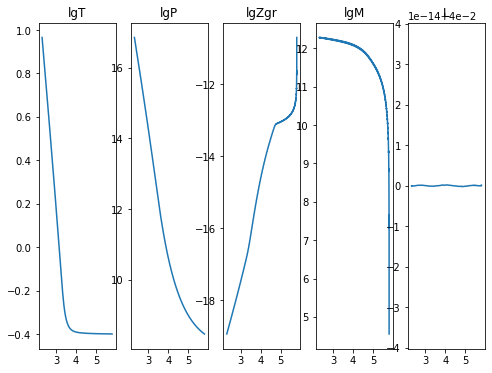

2020-12-06 05:36:53,730 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:36:54,752 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618627
2020-12-06 05:36:54,753 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234032
2020-12-06 05:36:54,754 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:36:54,755 __main__ 0/1 INFO :: lgM iterate: 12.306662613109173
2020-12-06 05:36:54,755 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063446
2020-12-06 05:36:54,756 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:36:54,757 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


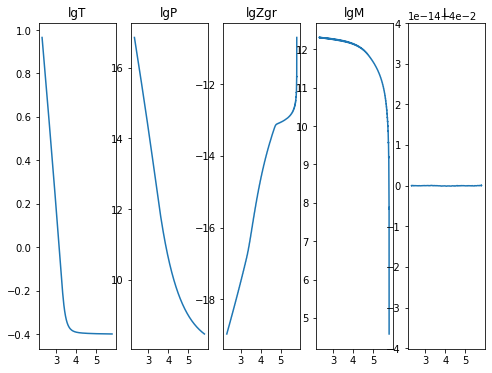

2020-12-06 05:36:58,470 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:36:59,453 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616737
2020-12-06 05:36:59,454 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894949
2020-12-06 05:36:59,455 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:36:59,456 __main__ 0/1 INFO :: lgM iterate: 12.278414437712616
2020-12-06 05:36:59,456 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118328
2020-12-06 05:36:59,457 __main__ 0/1 INFO :: m iterate: 1.6098110158235812e-05
2020-12-06 05:36:59,458 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


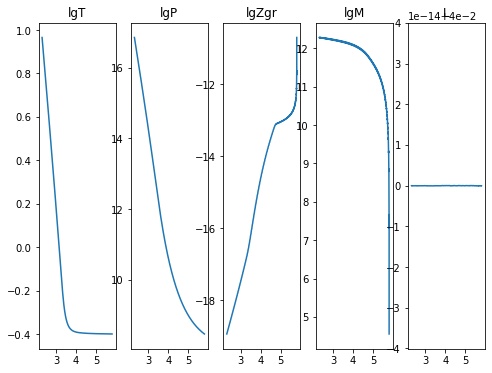

2020-12-06 05:37:03,070 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:04,047 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616327
2020-12-06 05:37:04,048 __main__ 0/1 INFO :: lgT iterate: 0.965671625123406
2020-12-06 05:37:04,049 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:37:04,049 __main__ 0/1 INFO :: lgM iterate: 12.306662613109179
2020-12-06 05:37:04,050 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063446
2020-12-06 05:37:04,051 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:37:04,052 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


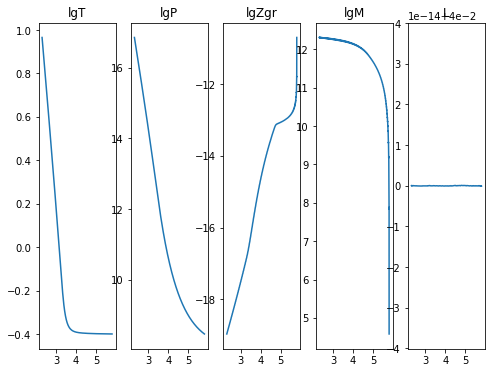

2020-12-06 05:37:07,645 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:08,614 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617264
2020-12-06 05:37:08,615 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894955
2020-12-06 05:37:08,616 __main__ 0/1 INFO :: lgP iterate: 16.85032943387845
2020-12-06 05:37:08,617 __main__ 0/1 INFO :: lgM iterate: 12.278414437712613
2020-12-06 05:37:08,617 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183278
2020-12-06 05:37:08,618 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:37:08,619 __main__ 0/1 INFO :: L iterate: 0.04


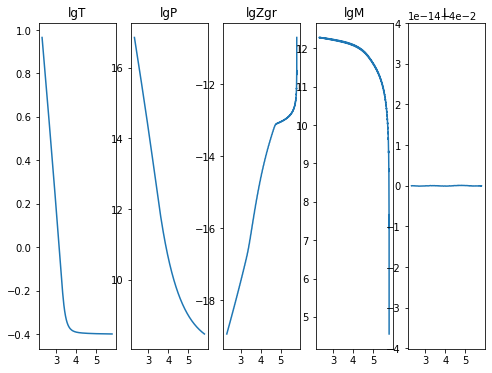

2020-12-06 05:37:12,232 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:13,215 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621087
2020-12-06 05:37:13,216 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234043
2020-12-06 05:37:13,217 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:37:13,218 __main__ 0/1 INFO :: lgM iterate: 12.306662613109204
2020-12-06 05:37:13,219 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-12-06 05:37:13,220 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:37:13,220 __main__ 0/1 INFO :: L iterate: 0.03999999999999999


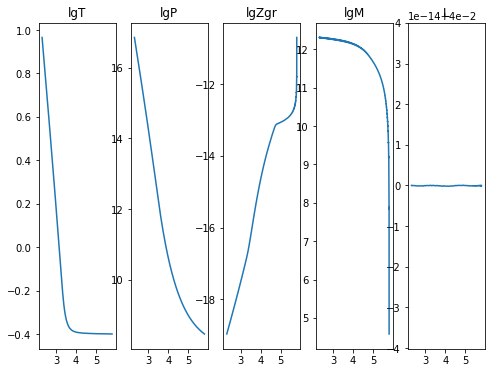

2020-12-06 05:37:16,935 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:17,902 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621074
2020-12-06 05:37:17,903 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894934
2020-12-06 05:37:17,904 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:37:17,905 __main__ 0/1 INFO :: lgM iterate: 12.278414437712636
2020-12-06 05:37:17,906 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183288
2020-12-06 05:37:17,907 __main__ 0/1 INFO :: m iterate: 1.6098110160456258e-05
2020-12-06 05:37:17,908 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


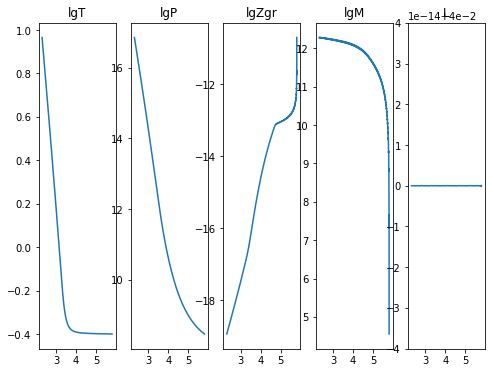

2020-12-06 05:37:21,564 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:22,553 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474617281
2020-12-06 05:37:22,554 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234042
2020-12-06 05:37:22,554 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:37:22,555 __main__ 0/1 INFO :: lgM iterate: 12.306662613109207
2020-12-06 05:37:22,556 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063464
2020-12-06 05:37:22,557 __main__ 0/1 INFO :: m iterate: 1.611401383705413e-05
2020-12-06 05:37:22,558 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


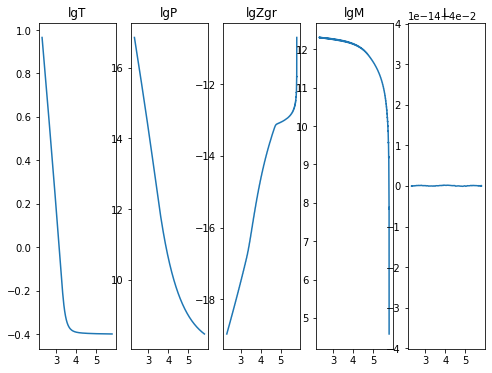

2020-12-06 05:37:26,431 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:37:27,422 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474616913
2020-12-06 05:37:27,424 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894943
2020-12-06 05:37:27,424 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:37:27,425 __main__ 0/1 INFO :: lgM iterate: 12.27841443771272
2020-12-06 05:37:27,426 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183352
2020-12-06 05:37:27,427 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:37:27,428 __main__ 0/1 INFO :: L iterate: 0.040000000000000036


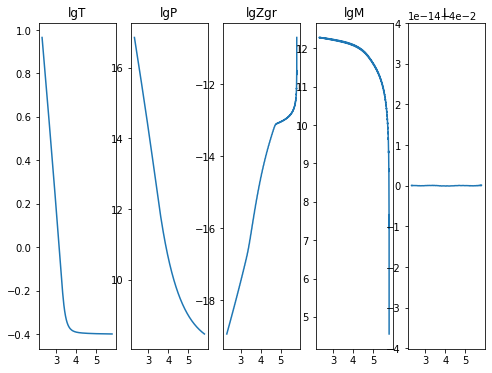

2020-12-06 05:37:31,017 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:32,003 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474622308
2020-12-06 05:37:32,004 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234037
2020-12-06 05:37:32,005 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:37:32,005 __main__ 0/1 INFO :: lgM iterate: 12.306662613109228
2020-12-06 05:37:32,006 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063478
2020-12-06 05:37:32,007 __main__ 0/1 INFO :: m iterate: 1.6114013835721863e-05
2020-12-06 05:37:32,008 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


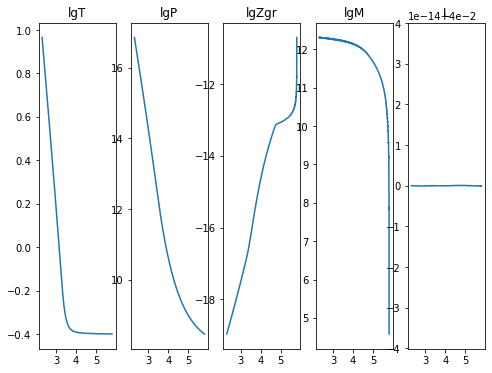

2020-12-06 05:37:35,754 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:36,708 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474626783
2020-12-06 05:37:36,709 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894941
2020-12-06 05:37:36,710 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:37:36,711 __main__ 0/1 INFO :: lgM iterate: 12.278414437712703
2020-12-06 05:37:36,712 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118334
2020-12-06 05:37:36,712 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:37:36,713 __main__ 0/1 INFO :: L iterate: 0.04


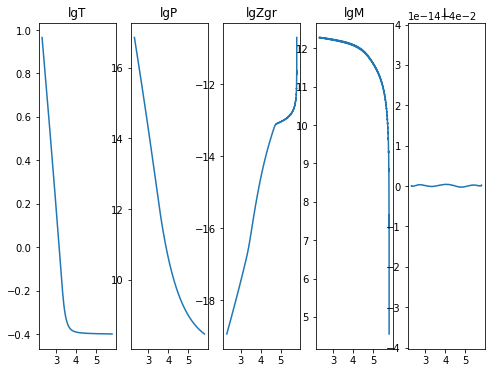

2020-12-06 05:37:40,347 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:37:41,364 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620608
2020-12-06 05:37:41,365 __main__ 0/1 INFO :: lgT iterate: 0.965671625123403
2020-12-06 05:37:41,366 __main__ 0/1 INFO :: lgP iterate: 16.851299471167266
2020-12-06 05:37:41,367 __main__ 0/1 INFO :: lgM iterate: 12.306662613109246
2020-12-06 05:37:41,368 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063492
2020-12-06 05:37:41,369 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:37:41,370 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


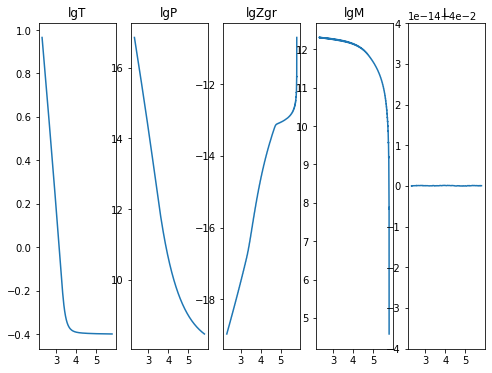

2020-12-06 05:37:44,996 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:37:45,914 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746153
2020-12-06 05:37:45,916 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894935
2020-12-06 05:37:45,916 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:37:45,917 __main__ 0/1 INFO :: lgM iterate: 12.278414437712616
2020-12-06 05:37:45,918 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183285
2020-12-06 05:37:45,919 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:37:45,920 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


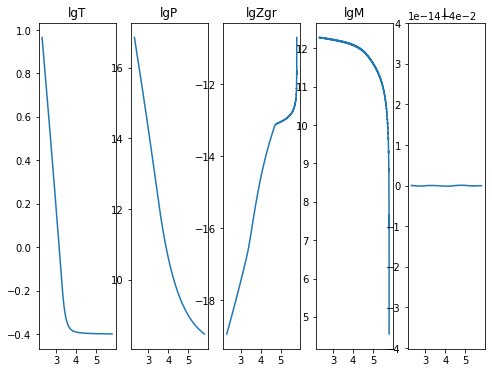

2020-12-06 05:37:50,905 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.7e+00/s
2020-12-06 05:37:52,042 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620577
2020-12-06 05:37:52,043 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234044
2020-12-06 05:37:52,044 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:37:52,045 __main__ 0/1 INFO :: lgM iterate: 12.306662613109095
2020-12-06 05:37:52,045 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506339
2020-12-06 05:37:52,046 __main__ 0/1 INFO :: m iterate: 1.6114013839718666e-05
2020-12-06 05:37:52,047 __main__ 0/1 INFO :: L iterate: 0.040000000000000015


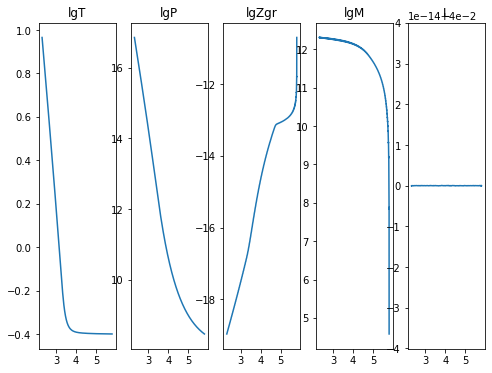

2020-12-06 05:37:56,830 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-12-06 05:37:58,132 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474623354
2020-12-06 05:37:58,133 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894956
2020-12-06 05:37:58,133 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:37:58,134 __main__ 0/1 INFO :: lgM iterate: 12.278414437712556
2020-12-06 05:37:58,135 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183242
2020-12-06 05:37:58,135 __main__ 0/1 INFO :: m iterate: 1.609811015912399e-05
2020-12-06 05:37:58,136 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


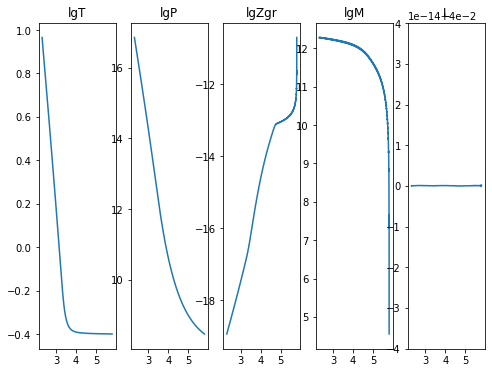

2020-12-06 05:38:02,329 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:38:03,348 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462698
2020-12-06 05:38:03,349 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234049
2020-12-06 05:38:03,350 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:38:03,351 __main__ 0/1 INFO :: lgM iterate: 12.306662613109081
2020-12-06 05:38:03,352 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063382
2020-12-06 05:38:03,353 __main__ 0/1 INFO :: m iterate: 1.61140138383864e-05
2020-12-06 05:38:03,354 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


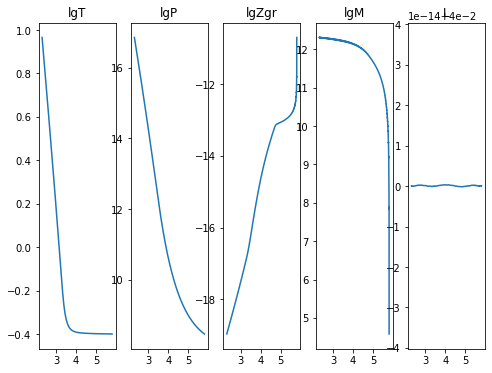

2020-12-06 05:38:07,134 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:38:08,150 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474629618
2020-12-06 05:38:08,151 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894961
2020-12-06 05:38:08,153 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:38:08,153 __main__ 0/1 INFO :: lgM iterate: 12.278414437712698
2020-12-06 05:38:08,154 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183338
2020-12-06 05:38:08,155 __main__ 0/1 INFO :: m iterate: 1.6098110157347634e-05
2020-12-06 05:38:08,156 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


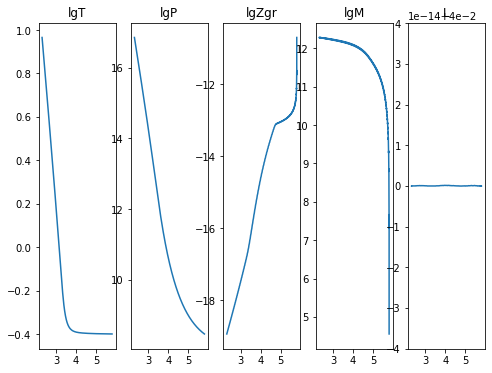

2020-12-06 05:38:11,877 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:38:12,906 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474627742
2020-12-06 05:38:12,907 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234054
2020-12-06 05:38:12,908 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:38:12,909 __main__ 0/1 INFO :: lgM iterate: 12.306662613109072
2020-12-06 05:38:12,909 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063375
2020-12-06 05:38:12,910 __main__ 0/1 INFO :: m iterate: 1.611401383794231e-05
2020-12-06 05:38:12,911 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


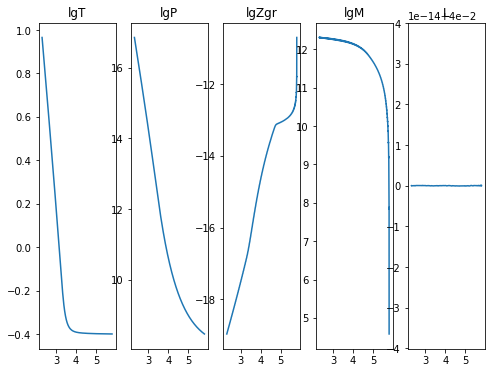

2020-12-06 05:38:16,764 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:38:17,763 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462697
2020-12-06 05:38:17,764 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894947
2020-12-06 05:38:17,765 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:38:17,766 __main__ 0/1 INFO :: lgM iterate: 12.2784144377127
2020-12-06 05:38:17,767 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118334
2020-12-06 05:38:17,768 __main__ 0/1 INFO :: m iterate: 1.6098110157791723e-05
2020-12-06 05:38:17,768 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


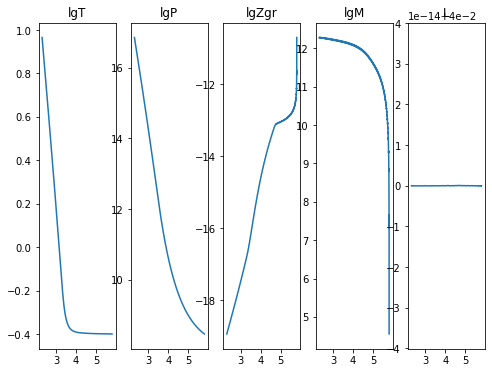

2020-12-06 05:38:21,419 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.5e+00/s
2020-12-06 05:38:22,441 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625826
2020-12-06 05:38:22,442 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234052
2020-12-06 05:38:22,443 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:38:22,444 __main__ 0/1 INFO :: lgM iterate: 12.306662613109168
2020-12-06 05:38:22,445 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063435
2020-12-06 05:38:22,446 __main__ 0/1 INFO :: m iterate: 1.611401383749822e-05
2020-12-06 05:38:22,447 __main__ 0/1 INFO :: L iterate: 0.04000000000000002


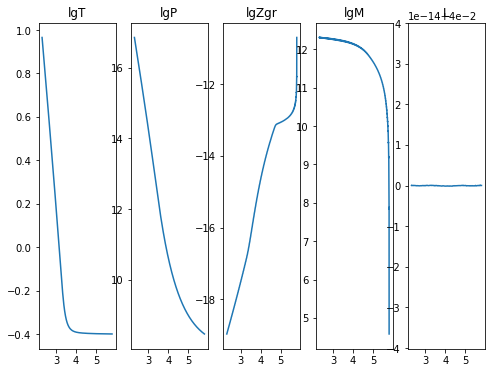

2020-12-06 05:38:26,240 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:38:27,312 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474625593
2020-12-06 05:38:27,313 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894963
2020-12-06 05:38:27,314 __main__ 0/1 INFO :: lgP iterate: 16.850329433878468
2020-12-06 05:38:27,315 __main__ 0/1 INFO :: lgM iterate: 12.278414437712758
2020-12-06 05:38:27,316 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118338
2020-12-06 05:38:27,317 __main__ 0/1 INFO :: m iterate: 1.60981101586799e-05
2020-12-06 05:38:27,318 __main__ 0/1 INFO :: L iterate: 0.03999999999999998


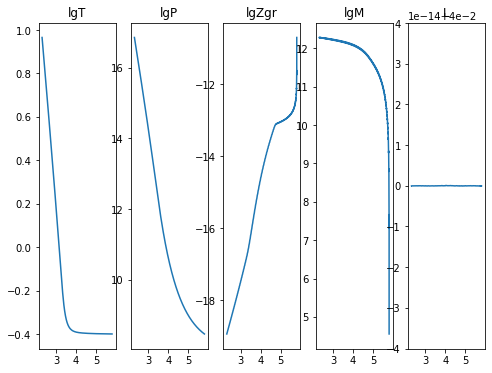

2020-12-06 05:38:31,031 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.6e+00/s
2020-12-06 05:38:32,241 __main__ 0/1 INFO :: Perturbation norm: 1.672075147462425
2020-12-06 05:38:32,242 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:38:32,243 __main__ 0/1 INFO :: lgP iterate: 16.851299471167277
2020-12-06 05:38:32,244 __main__ 0/1 INFO :: lgM iterate: 12.306662613109133
2020-12-06 05:38:32,244 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506341
2020-12-06 05:38:32,245 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:38:32,246 __main__ 0/1 INFO :: L iterate: 0.04


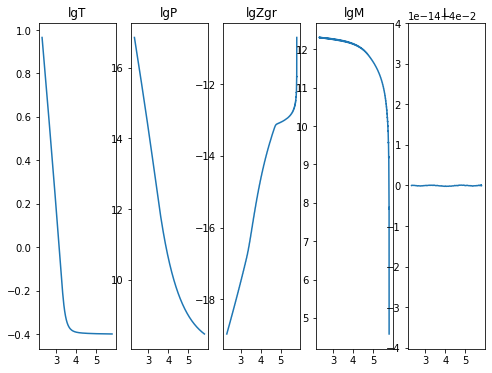

2020-12-06 05:38:36,441 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 1s, Remaining: 0s, Rate: 1.9e+00/s
2020-12-06 05:38:37,640 __main__ 0/1 INFO :: Perturbation norm: 1.67207514746232
2020-12-06 05:38:37,641 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894967
2020-12-06 05:38:37,642 __main__ 0/1 INFO :: lgP iterate: 16.85032943387846
2020-12-06 05:38:37,643 __main__ 0/1 INFO :: lgM iterate: 12.278414437712742
2020-12-06 05:38:37,644 __main__ 0/1 INFO :: lgZgr iterate: -18.94475233118337
2020-12-06 05:38:37,645 __main__ 0/1 INFO :: m iterate: 1.609811015956808e-05
2020-12-06 05:38:37,645 __main__ 0/1 INFO :: L iterate: 0.04000000000000003


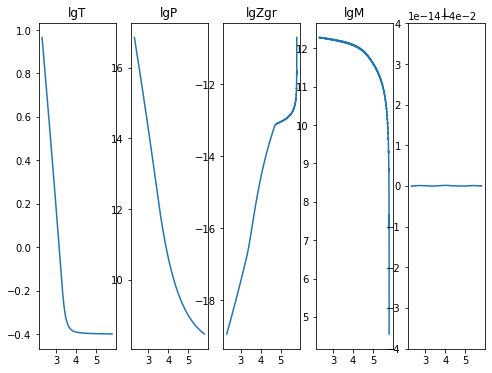

2020-12-06 05:38:41,552 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.3e+00/s
2020-12-06 05:38:42,924 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474621356
2020-12-06 05:38:42,925 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234039
2020-12-06 05:38:42,926 __main__ 0/1 INFO :: lgP iterate: 16.851299471167273
2020-12-06 05:38:42,927 __main__ 0/1 INFO :: lgM iterate: 12.306662613109125
2020-12-06 05:38:42,928 __main__ 0/1 INFO :: lgZgr iterate: -18.96458141506341
2020-12-06 05:38:42,929 __main__ 0/1 INFO :: m iterate: 1.6114013838830488e-05
2020-12-06 05:38:42,930 __main__ 0/1 INFO :: L iterate: 0.039999999999999994


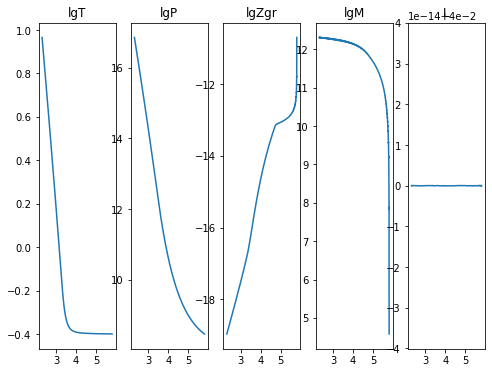

2020-12-06 05:38:46,854 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.0e+00/s
2020-12-06 05:38:48,041 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474620648
2020-12-06 05:38:48,042 __main__ 0/1 INFO :: lgT iterate: 0.9656849080894965
2020-12-06 05:38:48,043 __main__ 0/1 INFO :: lgP iterate: 16.850329433878464
2020-12-06 05:38:48,043 __main__ 0/1 INFO :: lgM iterate: 12.278414437712751
2020-12-06 05:38:48,044 __main__ 0/1 INFO :: lgZgr iterate: -18.944752331183366
2020-12-06 05:38:48,045 __main__ 0/1 INFO :: m iterate: 1.6098110156903545e-05
2020-12-06 05:38:48,046 __main__ 0/1 INFO :: L iterate: 0.04


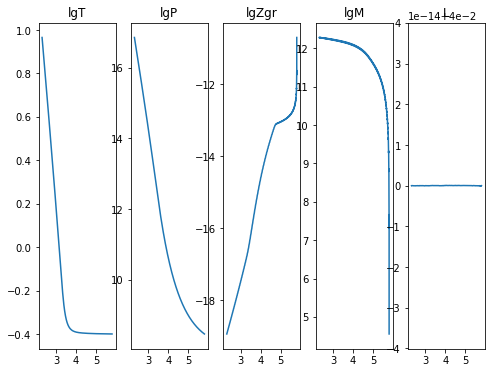

2020-12-06 05:38:52,865 pencil 0/1 INFO :: Building pencil matrix 1/1 (~100%) Elapsed: 0s, Remaining: 0s, Rate: 2.4e+00/s
2020-12-06 05:38:54,008 __main__ 0/1 INFO :: Perturbation norm: 1.6720751474618734
2020-12-06 05:38:54,009 __main__ 0/1 INFO :: lgT iterate: 0.9656716251234059
2020-12-06 05:38:54,010 __main__ 0/1 INFO :: lgP iterate: 16.85129947116728
2020-12-06 05:38:54,011 __main__ 0/1 INFO :: lgM iterate: 12.306662613109232
2020-12-06 05:38:54,011 __main__ 0/1 INFO :: lgZgr iterate: -18.964581415063485
2020-12-06 05:38:54,012 __main__ 0/1 INFO :: m iterate: 1.6114013839274577e-05
2020-12-06 05:38:54,013 __main__ 0/1 INFO :: L iterate: 0.04000000000000001


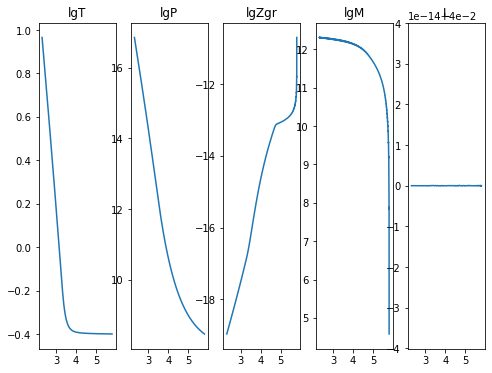

KeyboardInterrupt: 

In [19]:
# Iterations

i = 0

pert = solver.perturbations.data
pert.fill(1+tolerance)
start_time = time.time()
while np.sum(np.abs(pert)) > tolerance:
    solver.newton_iteration()
    lgT_list.append(np.copy(lgT1['g'])) # save
    lgP_list.append(np.copy(lgP1['g']))
    lgZgr_list.append(np.copy(lgZgr1['g'])) 
    lgM_list.append(np.copy(lgM1['g'])) 
    L_list.append(np.copy(L1['g']))
    m_list.append(np.copy(m['g']))
    logger.info('Perturbation norm: {}'.format(np.sum(np.abs(pert))))
    logger.info('lgT iterate: {}'.format(lgT1['g'][0]))
    logger.info('lgP iterate: {}'.format(lgP1['g'][0]))
    logger.info('lgM iterate: {}'.format(lgM1['g'][0]))
    logger.info('lgZgr iterate: {}'.format(lgZgr1['g'][0]))
    logger.info('m iterate: {}'.format(m1['g'][0]))
    logger.info('L iterate: {}'.format(L1['g'][0]))
    
    plt.figure(figsize=(8,6))
    plt.subplot(1,5,1)
    plt.plot(domain.grid(0),lgT1['g'])
    plt.title("lgT")
    plt.subplot(1,5,2)
    plt.plot(domain.grid(0), lgP1['g'])
    plt.title("lgP")
    plt.subplot(1,5,3)
    plt.plot(domain.grid(0),lgZgr1['g'])
    plt.title("lgZgr")
    plt.subplot(1,5,4)
    plt.plot(domain.grid(0), lgM1['g'])
    plt.title("lgM")
    plt.subplot(1,5,5)
    plt.plot(domain.grid(0), L1['g'])
    plt.title("L")
    plt.show()
    
end_time = time.time()

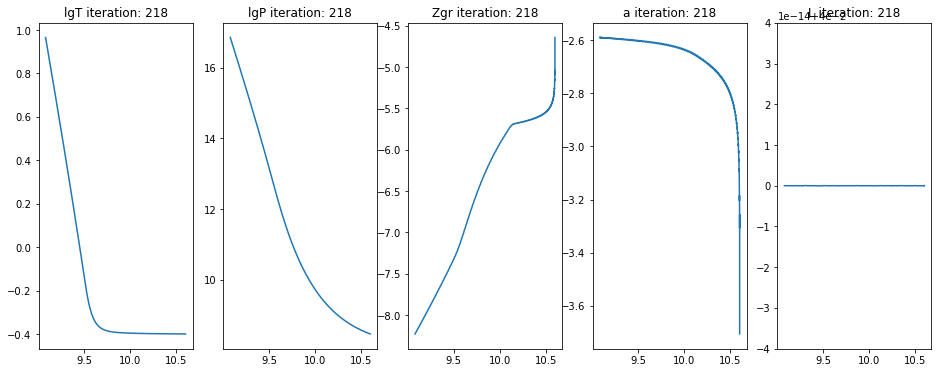

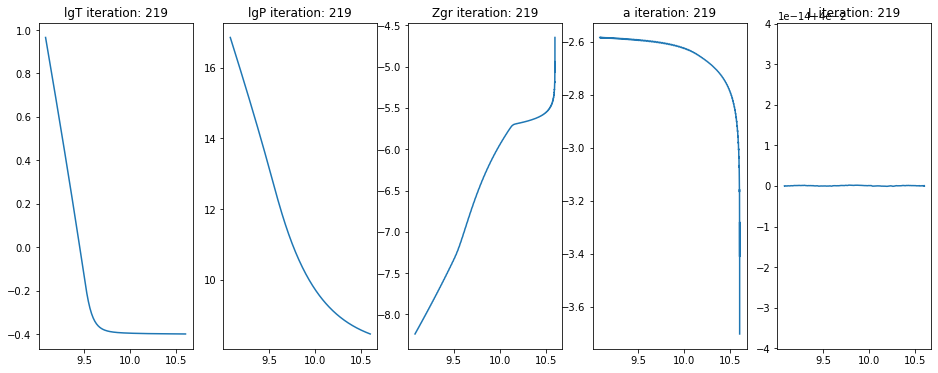

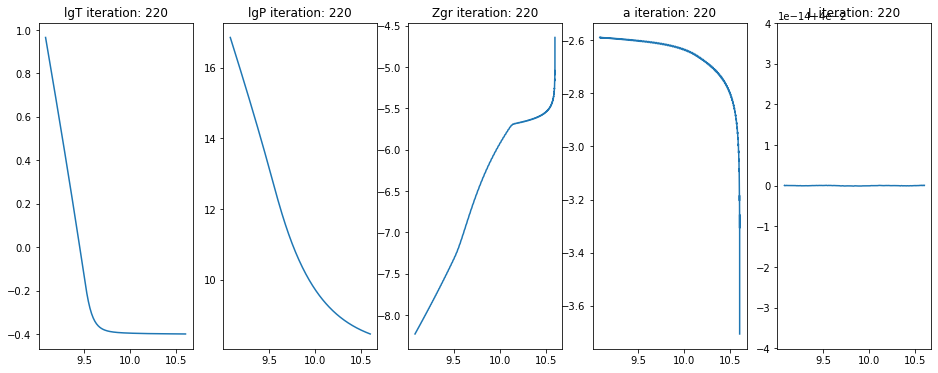

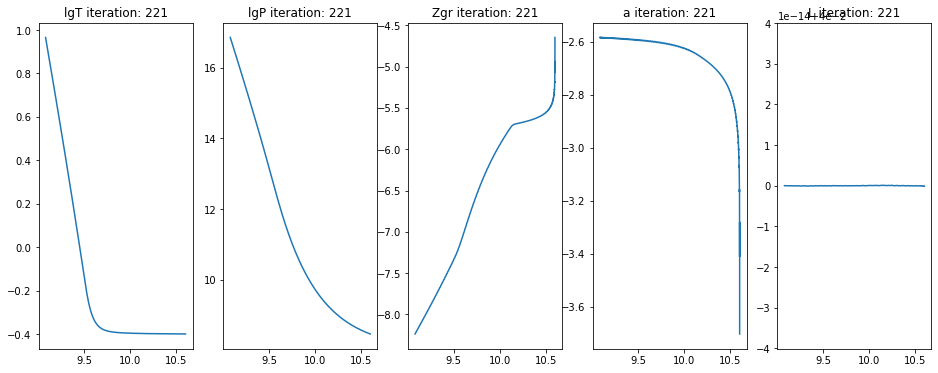

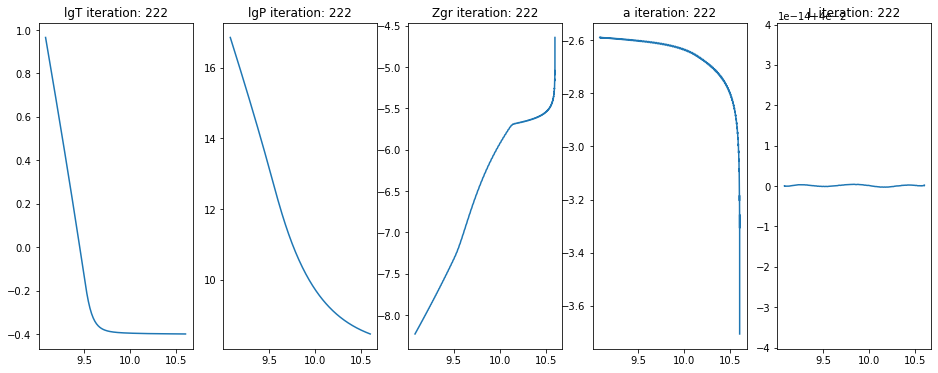

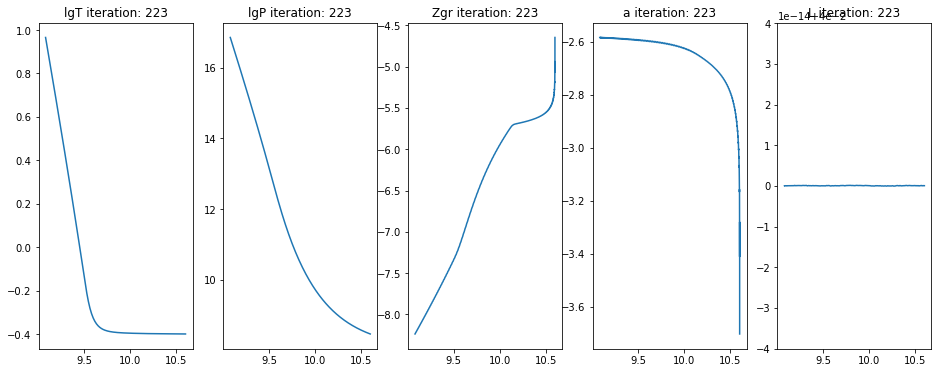

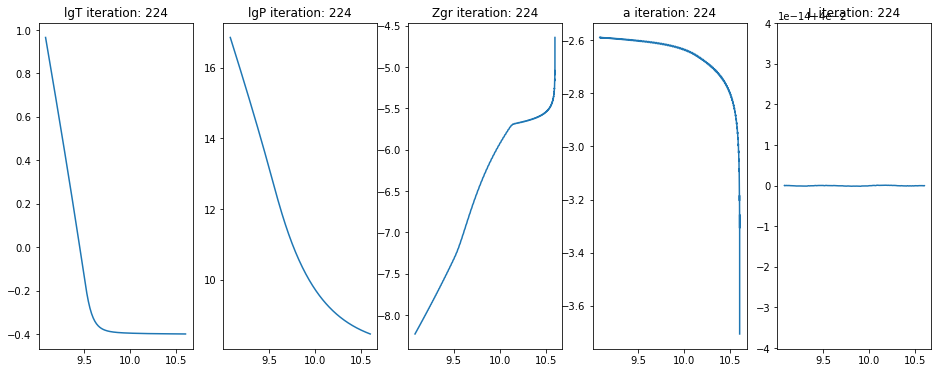

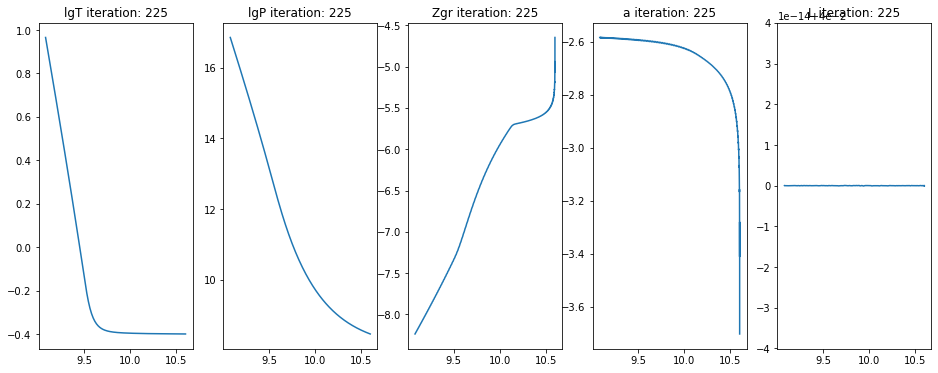

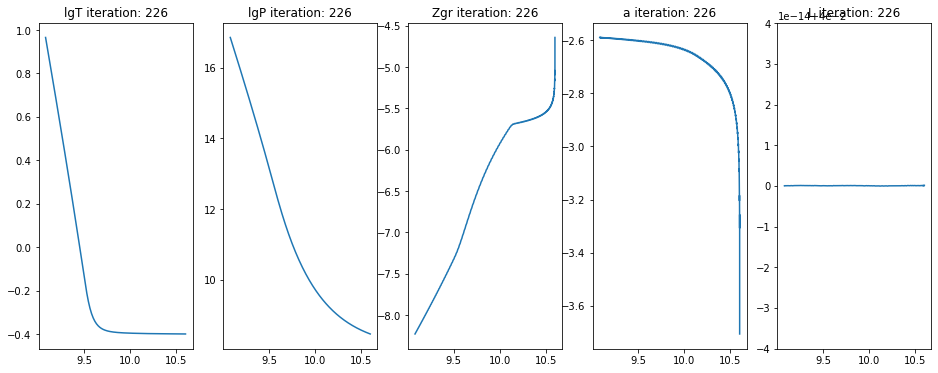

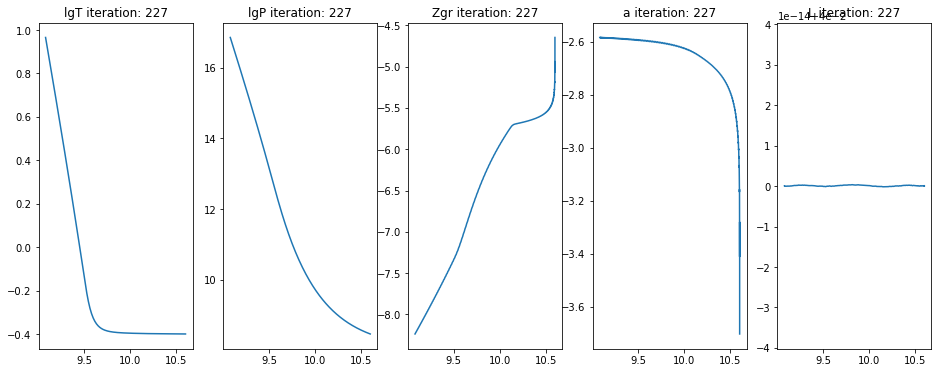

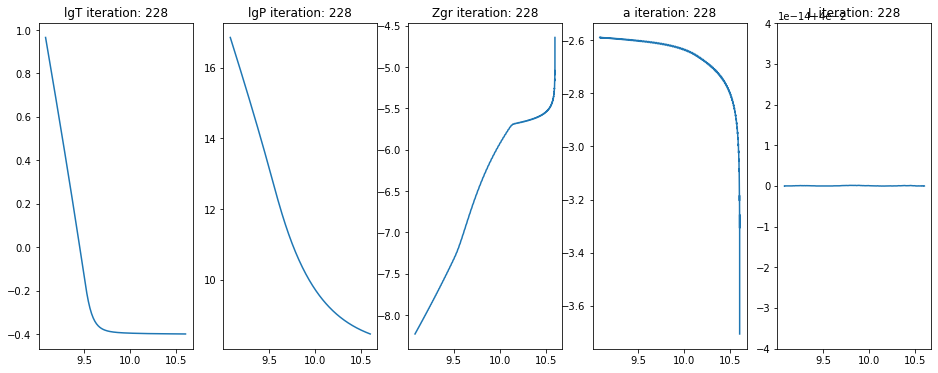

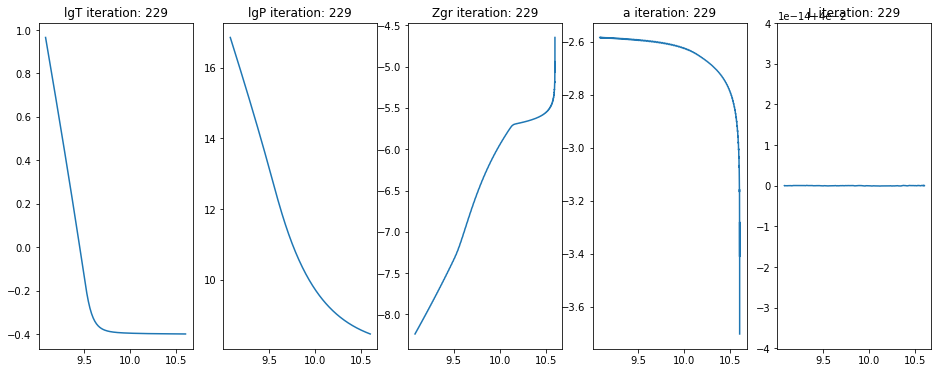

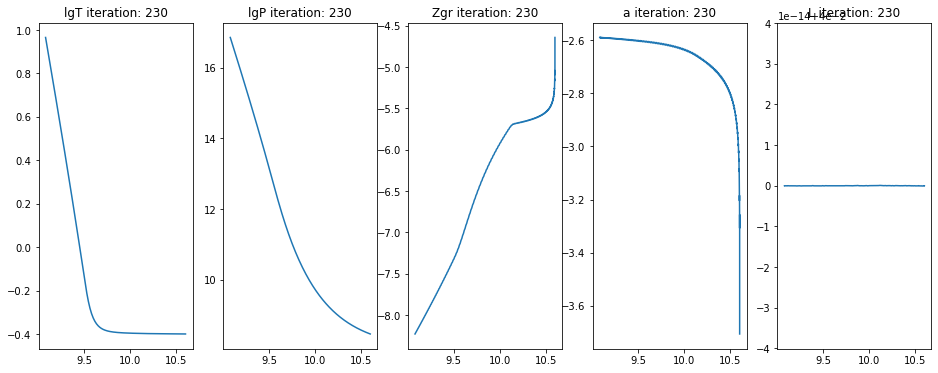

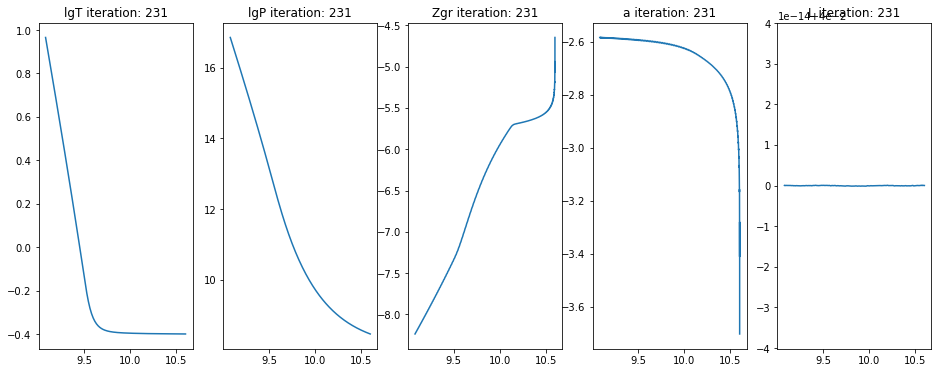

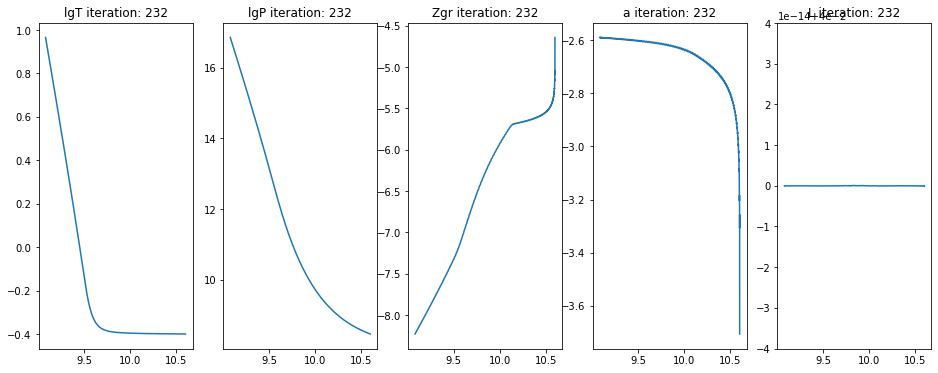

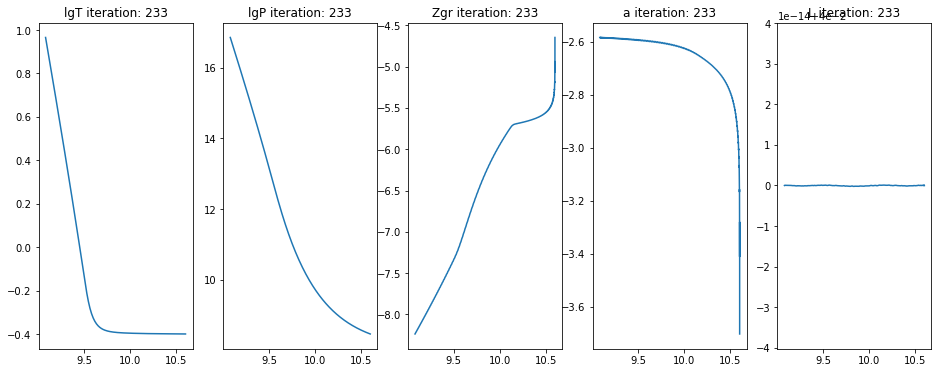

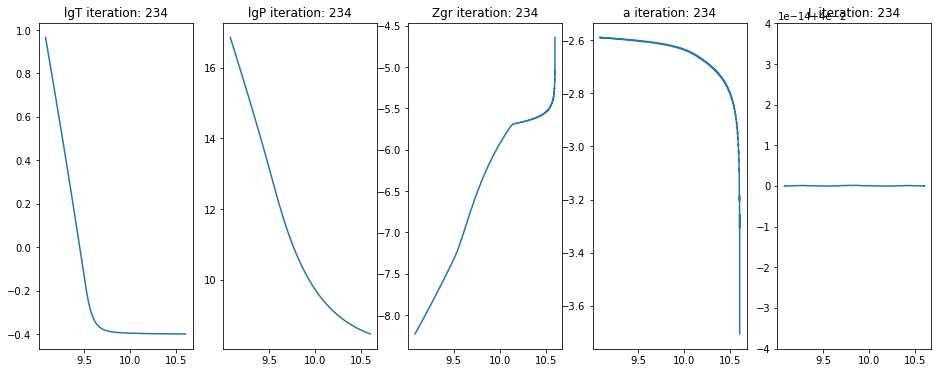

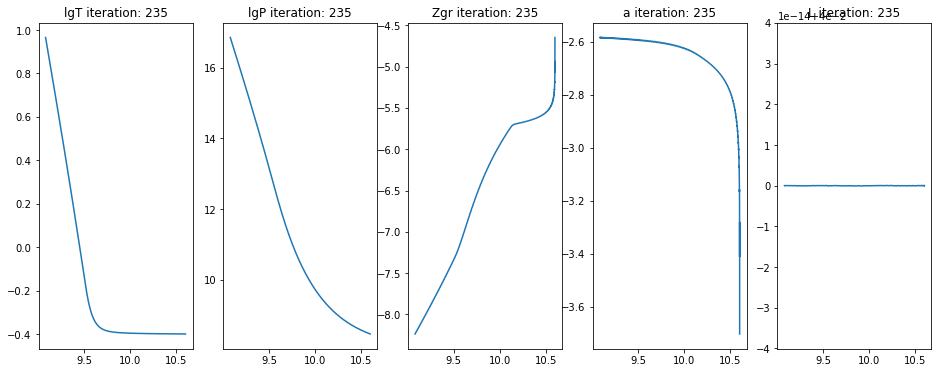

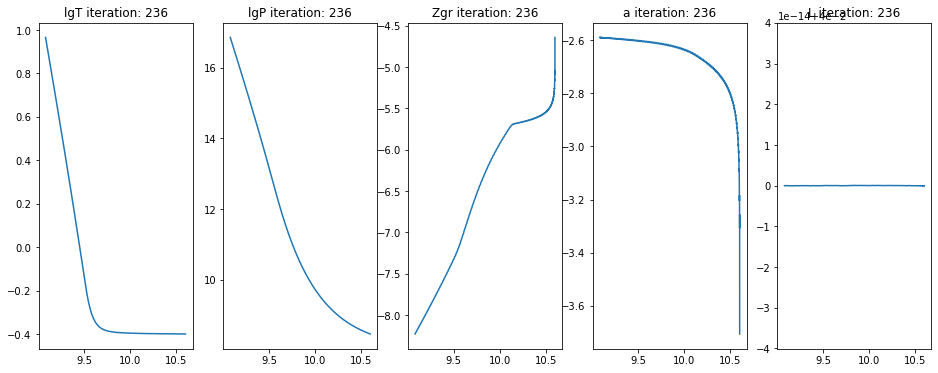

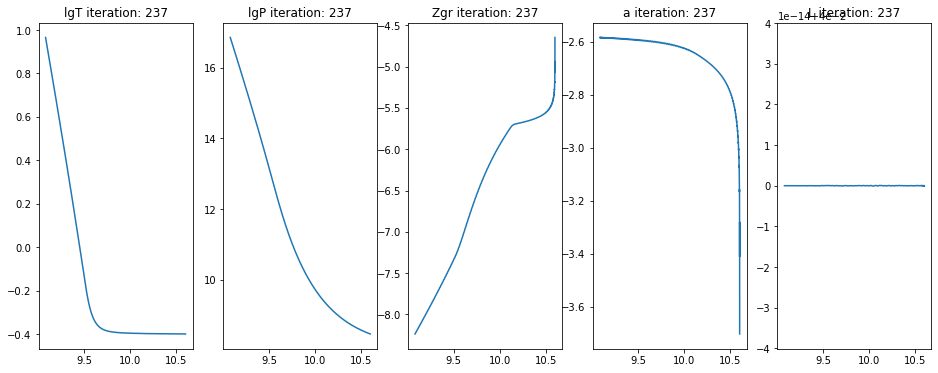

In [20]:
lower = 0 
if len(lgT_list) > 20:
    lower = len(lgT_list) - 20

R = np.log10(np.exp(domain.grid(0))*r_0)

for i in range(lower,len(lgT_list)):
        plt.figure(figsize=(16,6))
        
        plt.subplot(1,5,1)
        plt.plot(R,lgT_list[i])
        plt.title("lgT iteration: " + str(i))
        
        plt.subplot(1,5,2)
        plt.plot(R, lgP_list[i])
        plt.title("lgP iteration: " + str(i))
        
        plt.subplot(1,5,3)
        plt.plot(R, np.log10(np.exp(lgZgr_list[i])))
        plt.title("Zgr iteration: " + str(i))
        
        # Grain size 
        plt.subplot(1,5,4)
        plt.plot(R, np.log10((np.exp(lgM_list[i])*M_0/(4*np.pi))**(1/3)))
        plt.title("a iteration: " + str(i))
        
#         plt.subplot(1,5,5)
#         plt.plot(R, m_list[i])
#         plt.title("m iteration: " + str(i))

        plt.subplot(1,5,5)
        plt.plot(R, L_list[i])
        plt.title("L iteration: " + str(i))
        
        

In [21]:
lgP['g'] = lgP_list[-1]
lgT['g'] = lgT_list[-1]
lgZgr['g'] = lgZgr_list[-1]
lgM['g'] = lgM_list[-1]
m['g'] = m_list[-1]
L['g'] = L_list[-1]

Text(0.5, 1.0, 'Grad')

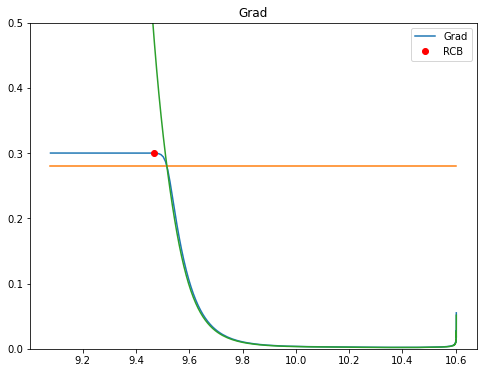

In [22]:
# Grad

Grad = grad.evaluate()
Grad.require_grid_space()
Grad_rad = grad_rad.evaluate()
Grad_rad.require_grid_space()

RCB = 0
epsilon = 0.0001
for i in range(0, len(Grad['g'] - 1)):
    if np.abs(Grad['g'][i] - Grad['g'][0]) >  epsilon:
        RCB = i
        break

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
plt.plot(R, grad_ad*np.ones(len(R)))
plt.plot(R, -Grad_rad['g'])
plt.plot(R[RCB], Grad['g'][RCB], 'ro', label = 'RCB')
plt.ylim(0, 0.5)
plt.legend()

plt.title('Grad')

Text(0.5, 1.0, 'Tstop')

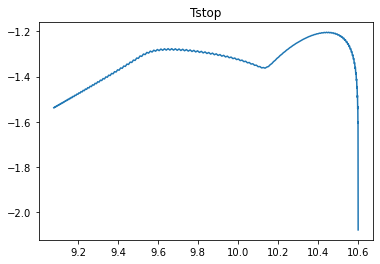

In [23]:
TStop = Tstop.evaluate()
TStop.require_grid_space()
plt.plot(R, np.log10(TStop['g']))
plt.title('Tstop')

Text(0.5, 1.0, 'Tgrow')

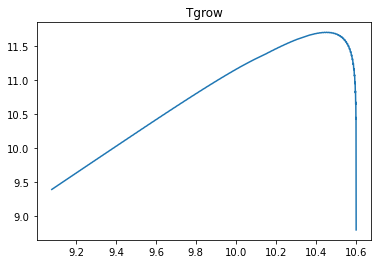

In [24]:
Tgrow = 1/Tgrow_inv
TGrow = Tgrow.evaluate()
TGrow.require_grid_space()
plt.plot(R, np.log10(TGrow['g']))
plt.title('Tgrow')

# New analysis section (Jan 30)


Trcb_set = 15.08614130715058 yr
Tbondi_set = 3030.6686665710745 yr
Tout_set = 32083.758385326724 yr


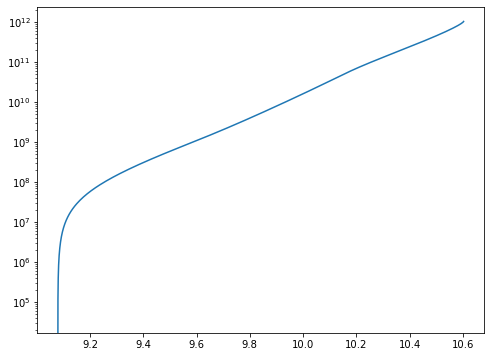

In [25]:
Bondi = r_Bondi # cm
# Bondi = 3.7e11 # cm
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']

Tsettl = np.ones(len(R))

for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')


Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))



Trcb_set = 15.08614130715058 yr
Tbondi_set = 32083.758385326724 yr
Tout_set = 32083.758385326724 yr


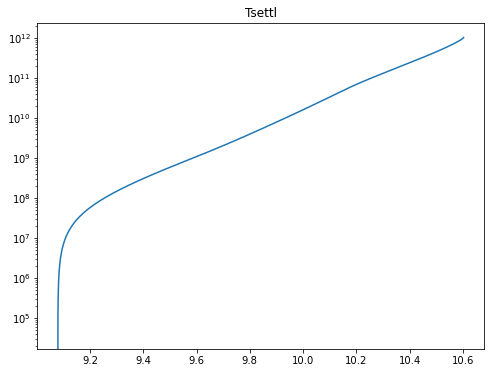

In [26]:
Bondi = 3.7e11 # cm
Bondi = 8.9442713e10
# Tsettl = r/vsettl 
def find_nearest_index(A, x):
    i = (np.abs(A - x)).argmin()
    return i

bondi = find_nearest_index(R, np.log10(Bondi))
Vsettl = v_set.evaluate()
Vsettl.require_grid_space()
Vset = Vsettl['g']


Tsettl = np.ones(len(R))


for i in range(0, len(R)):
    Tsettl[i] = np.trapz(1/Vset[0:i], S[0:i]) # Ormel integral definition 
    
# Tsettl = np.exp(r['g'])*r_0/Vset 
    
plt.figure(figsize=(8,6))
plt.plot(R, Tsettl)
plt.yscale('log')
plt.title('Tsettl')

Trcb_set = Tsettl[RCB]
Tbondi_set = Tsettl[bondi]
Tout_set = Tsettl[-1]

yr = 3.154e+7

print("Trcb_set = {} yr".format(Trcb_set/yr))
print("Tbondi_set = {} yr".format(Tbondi_set/yr))
print("Tout_set = {} yr".format(Tout_set/yr))

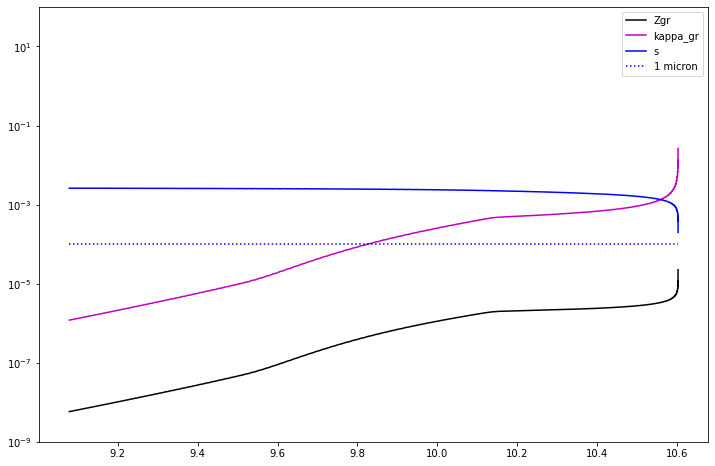

In [27]:
# Ormel profile
size = s.evaluate()
size.require_grid_space()
kappa_gr = Qk_geo.evaluate()
kappa_gr.require_grid_space()


plt.figure(figsize=(12,8))
plt.plot(R, np.exp(lgZgr['g']), 'k-', label='Zgr')
plt.plot(R, kappa_gr['g'], 'm-', label='kappa_gr')
plt.plot(R, size['g'], 'b-', label='s')
plt.plot(R, R/R*1e-4, 'b:', label='1 micron')
plt.yscale('log')
plt.ylim((1e-9, 1e2))
plt.legend()

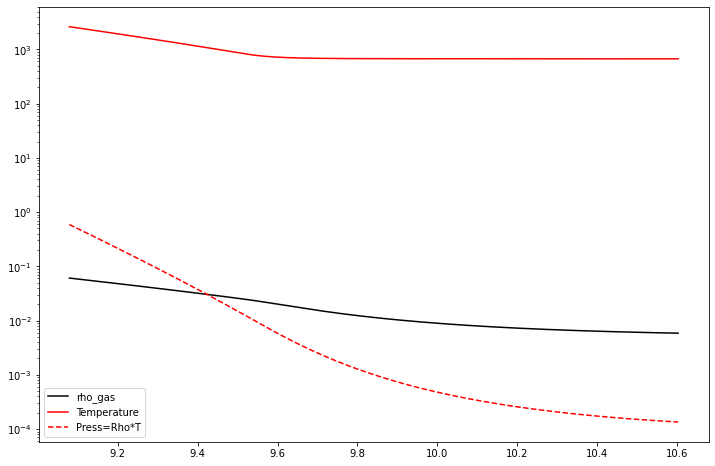

In [28]:
rho_gas = rho_g.evaluate()
rho_gas.require_grid_space()

lgt = lgT_list[-1]


plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g'])**(1/3), 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0, 'r-', label='Temperature') 
plt.plot(R, np.exp(lgt)*T_0 *rho_gas['g'] , 'r--', label='Press=Rho*T')
plt.yscale('log')
plt.legend()

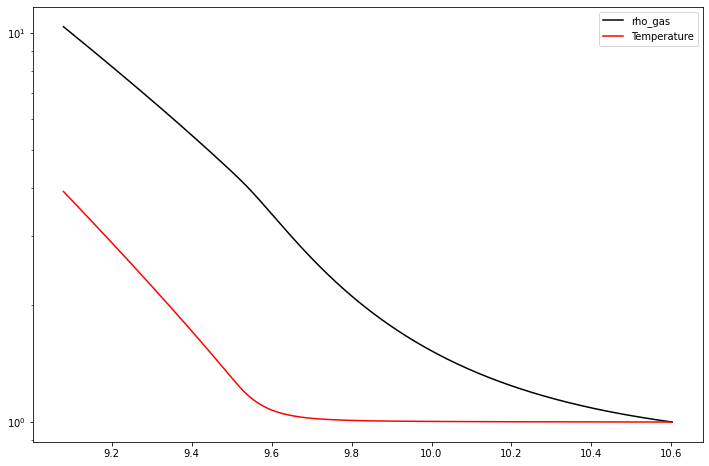

In [29]:
plt.figure(figsize=(12,8)) # I don't know Ormel's normalization values 
plt.plot(R, (rho_gas['g']/rhodisk)**(1/3) , 'k-', label='rho_gas')
plt.plot(R, np.exp(lgt)*T_0 / Tdisk, 'r-', label='Temperature') 
plt.yscale('log')
plt.legend()

Envelope mass (g): 7.837842e+25


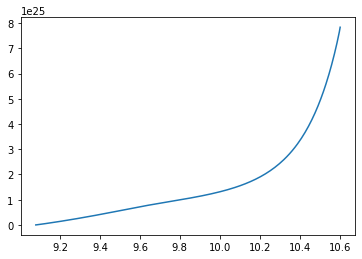

In [30]:
Env = np.zeros(len(R))

En = 4*np.pi*(np.exp(r)*r_0)**2 *rho_g 

m = En.evaluate()
m.require_grid_space()

for i in range(0, len(R)):
    Env[i] = np.trapz(m['g'][0:i], S[0:i]) 
    
    
plt.plot(R, Env)
env_mass = Env[-1]
print("Envelope mass (g): {:e}".format(env_mass))

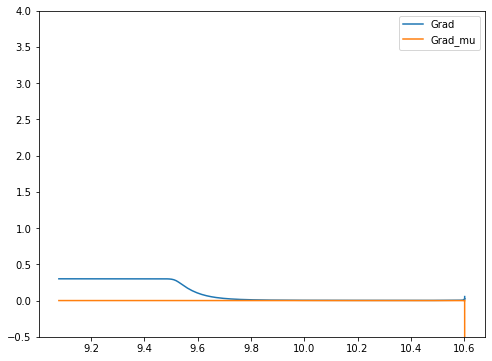

In [31]:
dlgZgr = lgZgr.differentiate('r')
dlgP = lgP.differentiate('r')

# Multiply dlgZgr by Zgr to get dZgr (as a proxy for dmu = d(1+Zgr) = dZgr)
grad_mu= dlgZgr['g']/ dlgP['g'] 
grad_mu *= np.exp(lgZgr['g'])

#grad_mu.evaluate()
#grad_mu.require_grid_space()

plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'], label='Grad')
#plt.plot(R, dlgZgr['g'] / dlgP['g'], label='Grad_mu')
plt.plot(R, grad_mu, label='Grad_mu')
plt.ylim(-0.5, 4)
plt.legend()

(-4.0, 4.0)

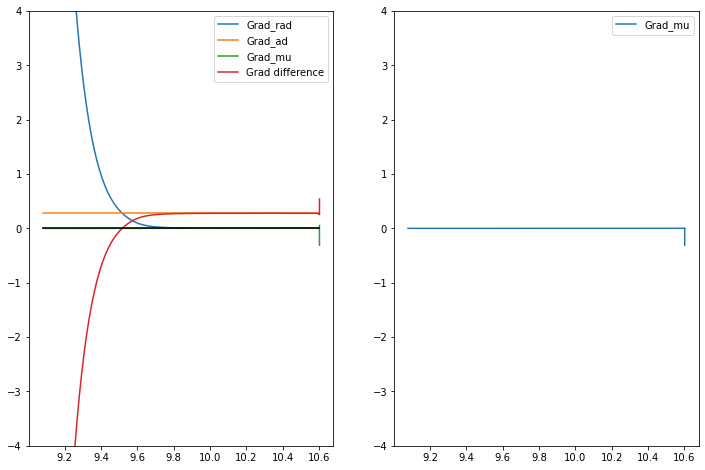

In [32]:
lgMu = np.log(1+np.exp(lgZgr))
dlgMu = log_basis.Differentiate(lgMu)
dlgP = log_basis.Differentiate(np.log(np.exp(lgP) *P_0))

grad_mu = dlgMu/dlgP

# grad_mu1 = np.diff( np.log(1+np.exp(lgZgr['g'])))/ np.diff(np.log(np.exp(lgP['g']) *P_0)) 
Grad_mu = grad_mu.evaluate()
Grad_mu.require_grid_space()

grad_diff = grad_rad - grad_mu - (-grad_ad) 
Grad_diff = grad_diff.evaluate() 
Grad_diff.require_grid_space() 


plt.figure(figsize = (12,8))
plt.subplot(1,2,1)
# plt.plot(R, Grad_diff['g'])
# plt.plot(R,Grad_mu['g'])
plt.plot(R, -Grad_rad['g'], label = 'Grad_rad')
plt.plot(R, grad_ad*np.ones(len(R)), label = 'Grad_ad')
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
plt.plot(R, Grad_diff['g'], label = 'Grad difference')
plt.plot(R, np.zeros(len(R)), 'k-') 
plt.legend()
plt.ylim((-4, 4))
plt.subplot(1,2,2)
plt.plot(R, Grad_mu['g'], label = 'Grad_mu')
# plt.plot(R[1:], grad_mu1)
plt.legend()
plt.ylim((-4, 4))

<ipython-input-33-47634ba53436>:5: RuntimeWarning: invalid value encountered in log10
  plt.plot(R, np.log10(R_0), label='log10(R_0)')


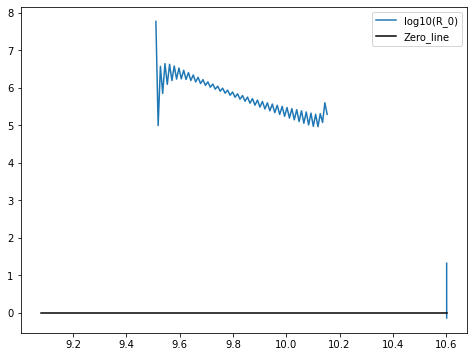

In [33]:
# Plot R_0 for fingering convection
R_0 = (Grad['g'] - grad_ad)/Grad_mu['g']

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(R_0), label='log10(R_0)')
plt.plot(R, 0*R , 'k-', label='Zero_line')
#plt.ylim(-1.0, 1000.0)
plt.legend()


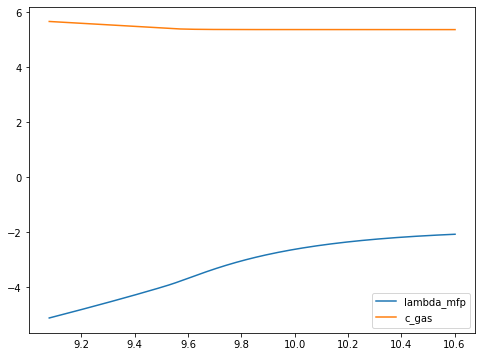

In [34]:
# Profile of nu and Xi for Prandtl number
c_gas=np.sqrt(8.32e7 * np.exp(lgt)*T_0 )
cross_sect_H2=2e-15 #cgs H2 cross section
lambda_mfp= 1./ (cross_sect_H2 * rho_gas['g'] / 2 / 1.67e-24)
nu_visc= lambda_mfp * c_gas

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(lambda_mfp), label='lambda_mfp')
plt.plot(R, np.log10(c_gas), label='c_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()       

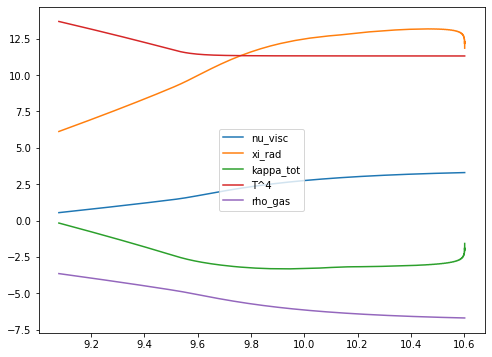

In [35]:
gas_gamma=7./5.
kappa_tot =  kappa.evaluate()
kappa_tot.require_grid_space()
#xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt['g'])*T_0)**4.  / rho_gas['g'] / np.exp(lgP['g']) 
xi_rad= 16./3. * (gas_gamma-1)/gas_gamma * 5.670367e-5 * (np.exp(lgt)*T_0)**4.  / rho_gas['g'] / kappa_tot['g']/ np.exp(lgP['g'])

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc), label='nu_visc')
plt.plot(R, np.log10(xi_rad), label='xi_rad')

plt.plot(R, np.log10(kappa_tot['g']), label='kappa_tot')

plt.plot(R, np.log10((np.exp(lgt)*T_0)**4.), label='T^4')
plt.plot(R, np.log10(rho_gas['g']), label='rho_gas')

#plt.ylim(-0.1, 0.1)
plt.legend()

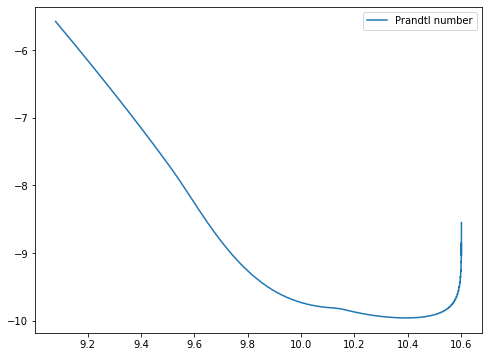

In [36]:
# Profile of Prandtl number
plt.figure(figsize=(8,6))
plt.plot(R, np.log10(nu_visc/xi_rad), label='Prandtl number')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()

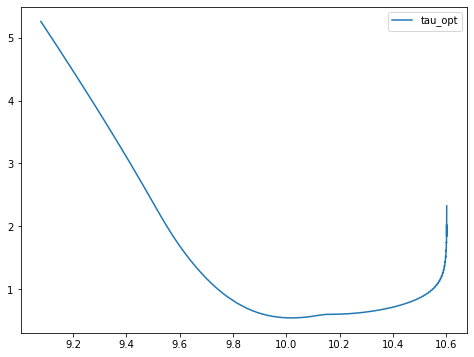

In [37]:
# Optical thickness to 'surface'
tau_opt= 10.**R * rho_gas['g'] *kappa_tot['g'] # Approximation to true integral of rho.dz

plt.figure(figsize=(8,6))
plt.plot(R, np.log10(tau_opt), label='tau_opt')
#plt.plot(R, np.log10(xi_rad), label='xi_rad')

#plt.ylim(-0.1, 0.1)
plt.legend()


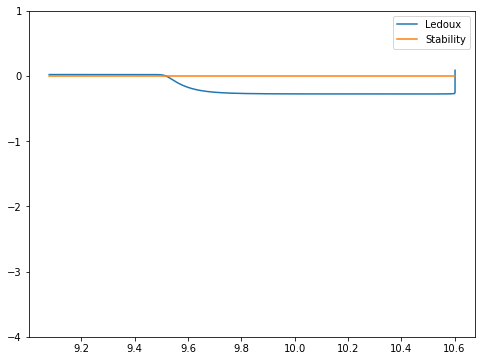

In [38]:
plt.figure(figsize=(8,6))
plt.plot(R, Grad['g'] - Grad_mu['g'] - grad_ad, label='Ledoux')
plt.plot(R, 0*R , label='Stability')
plt.ylim(-4, 1)
plt.legend()

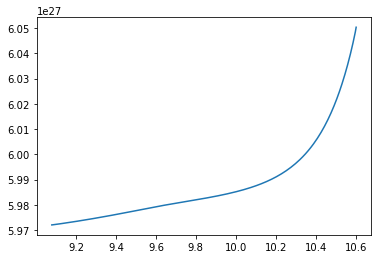

In [43]:
# This should be the mass 
plt.plot(R, Core_mass+Env)
plt.show()

In [44]:
Cs = cg.evaluate() # sound speed, which we previously used 
Cs.require_grid_space()
Cs = Cs['g']

Nth = np.sqrt((G*(Core_mass+Env)/(10**R)**2)**2/Cs**2*(grad_ad-Grad_rad['g'])) # I changed grad_rad to be positive now
d_finger= ((nu_visc*xi_rad)/Nth**2)**(1/4)
tau_cool = d_finger**2/xi_rad

Rgas = 8.32e7 / 2.3 # You gave me this value, but the wikipedia one in cgs doesnt have the /2.3 
Sigma = 5.7e-5
tau_cool_thin = Rgas/(16*kappa_tot['g']*Sigma*(np.exp(lgt)*T_0)**3)

Prandtl = nu_visc/xi_rad 

v_coll = d_finger/(np.sqrt(Prandtl)*tau_cool)

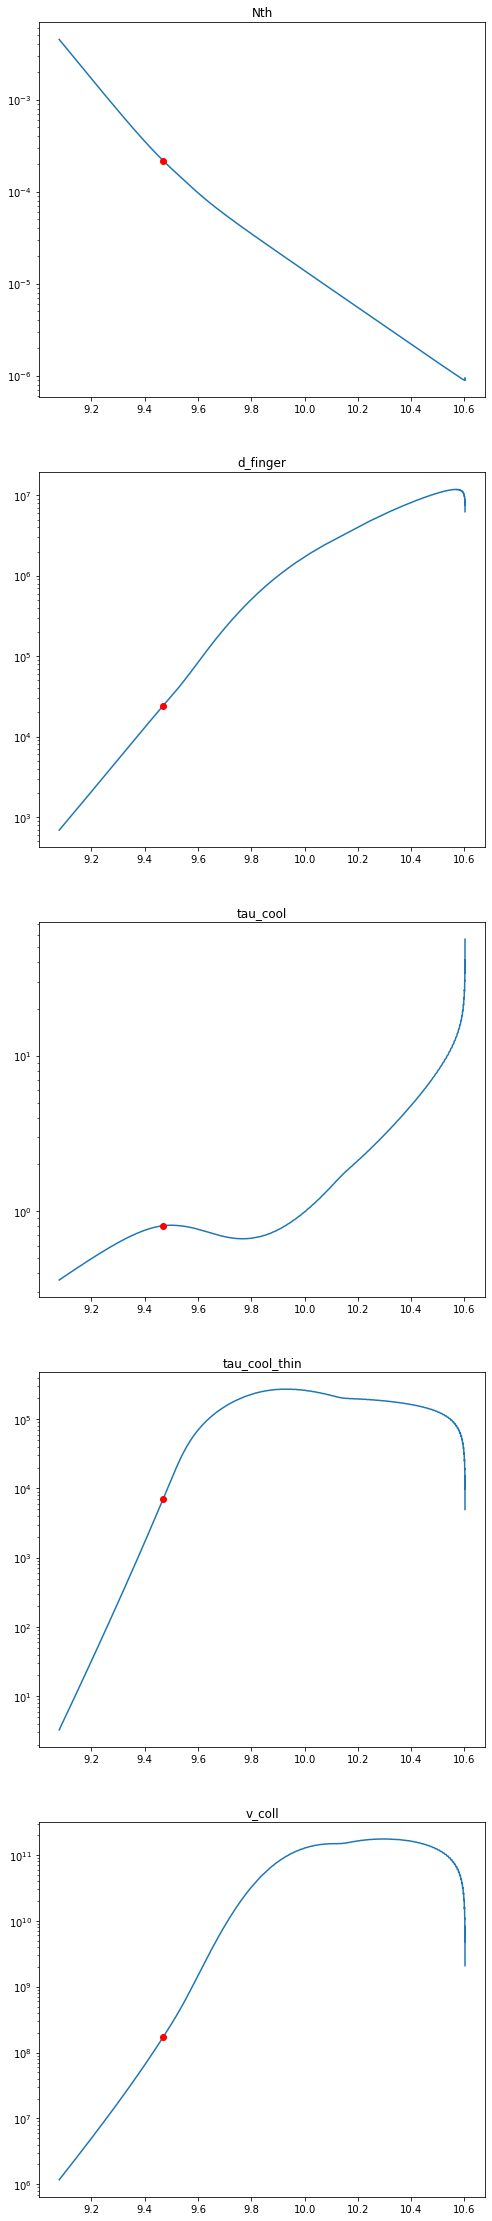

In [45]:
# red dot marks where grad transitions to grad_rad

plt.figure(figsize=(8,8*5))

plt.subplot(5,1,1)
plt.plot(R, Nth)
plt.plot(R[RCB], Nth[RCB], 'ro')
plt.yscale('log')
plt.title('Nth')

plt.subplot(5,1,2)
plt.plot(R,d_finger)
plt.plot(R[RCB], d_finger[RCB], 'ro')
plt.title('d_finger')
plt.yscale('log')

plt.subplot(5,1,3)
plt.plot(R,tau_cool)
plt.plot(R[RCB], tau_cool[RCB], 'ro')
plt.title('tau_cool')
plt.yscale('log')

plt.subplot(5,1,4)
plt.plot(R,tau_cool_thin)
plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.title('tau_cool_thin')
plt.yscale('log')

plt.subplot(5,1,5)
plt.plot(R,v_coll)
plt.plot(R[RCB], v_coll[RCB], 'ro')
plt.title('v_coll')
plt.yscale('log')

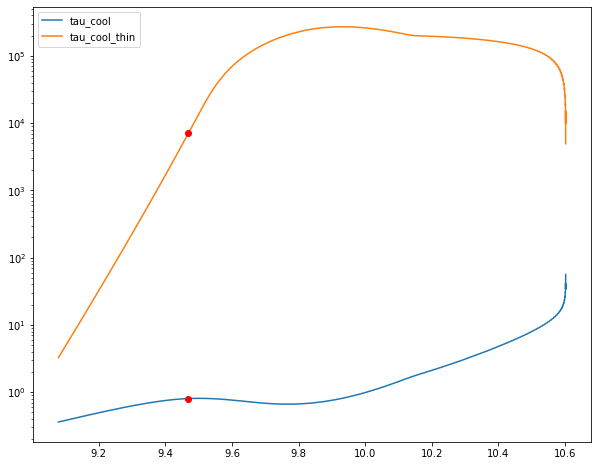

In [46]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_cool, label='tau_cool')
plt.plot(R, tau_cool_thin, label='tau_cool_thin')
plt.plot(R[RCB], tau_cool[RCB], 'ro')
plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

In [47]:
np.savetxt("NPressure_dep.txt", lgP_list[-1])
np.savetxt("NTemperature_dep.txt", lgT_list[-1])
np.savetxt("NZgr_dep.txt", lgZgr_list[-1])
np.savetxt("NM_dep.txt", lgM_list[-1])
np.savetxt("Nm_dep.txt",  m_list[-1])
np.savetxt("NL_dep.txt", L_list[-1])

In [48]:
prefix = '02_1_'

np.savetxt('saved/'+prefix+'Ngrad.txt', Grad['g'])
np.savetxt('saved/'+prefix+'Ngrad_rad.txt', -Grad_rad['g'])
np.savetxt('saved/'+prefix+'NTstop.txt', np.log10(TStop['g']))
np.savetxt('saved/'+prefix+'NTgrow.txt', np.log10(TGrow['g']))
np.savetxt('saved/'+prefix+'NTsettl.txt', Tsettl) 
np.savetxt('saved/'+prefix+'NZgr.txt', np.exp(lgZgr['g'])) 
np.savetxt('saved/'+prefix+'Nkappa_gr.txt', kappa_gr['g']) 
np.savetxt('saved/'+prefix+'Nsize.txt', size['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_cbrt.txt', (rho_gas['g'])**(1/3))
np.savetxt('saved/'+prefix+'NTemperature.txt', np.exp(lgt)*T_0)
np.savetxt('saved/'+prefix+'NPress.txt', np.exp(lgt)*T_0 *rho_gas['g'])
np.savetxt('saved/'+prefix+'Nrho_gas_norm.txt', (rho_gas['g']/rhodisk)**(1/3))
np.savetxt('saved/'+prefix+'NTemperature_norm.txt',np.exp(lgt)*T_0 / Tdisk)
np.savetxt('saved/'+prefix+'NEnv.txt', Env)
np.savetxt('saved/'+prefix+'Ngrad_mu.txt', Grad_mu['g'])
np.savetxt('saved/'+prefix+'Ngrad_ad.txt', grad_ad*np.ones(len(R)))
np.savetxt('saved/'+prefix+'Ngrad_diff.txt',  Grad_diff['g'])
np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))
np.savetxt('saved/'+prefix+'Nlambda_mfp.txt',  np.log10(lambda_mfp))
np.savetxt('saved/'+prefix+'Nc_gas.txt',  np.log10(c_gas))
np.savetxt('saved/'+prefix+'Nnu_visc.txt',  np.log10(nu_visc))
np.savetxt('saved/'+prefix+'Nxi_rad.txt',  np.log10(xi_rad))
np.savetxt('saved/'+prefix+'Nkappa_tot.txt',  np.log10(kappa_tot['g']))
np.savetxt('saved/'+prefix+'NTfourth.txt',  np.log10((np.exp(lgt)*T_0)**4.))
np.savetxt('saved/'+prefix+'Nrho_gas.txt',  np.log10(rho_gas['g']))
np.savetxt('saved/'+prefix+'NPrandtl_number.txt',  np.log10(nu_visc/xi_rad))
np.savetxt('saved/'+prefix+'Ntau_opt.txt',  np.log10(tau_opt))
np.savetxt('saved/'+prefix+'NLedoux.txt',  Grad['g'] - Grad_mu['g'] - grad_ad)
np.savetxt('saved/'+prefix+'NR.txt', R)


<ipython-input-48-2bb87fa6a9b8>:20: RuntimeWarning: invalid value encountered in log10
  np.savetxt('saved/'+prefix+'Nlog10(R_0).txt',  np.log10(R_0))


# New section Oct 13 (Kristen - evaluate diffusion times vs settling)

In [49]:
# Growth time of fingers (thick/thin)
#tau_growth_thick = np.sqrt(Prandtl) * tau_cool
#tau_growth_thin  = np.sqrt(Prandtl) * tau_cool_thin
tau_growth_thick = 1./np.sqrt(Prandtl / R_0) * tau_cool
tau_growth_thin  = 1./np.sqrt(Prandtl / R_0) * tau_cool_thin



# Diffusion coeff from fingers (thick/thin)
diff_thick = d_finger**2 / tau_growth_thick
diff_thin = d_finger**2 / tau_growth_thin

# Local Diffusion time from fingers (thick/thin)
tau_diff_thick = (10**R)**2 / diff_thick 
tau_diff_thin = (10**R)**2 / diff_thin

# Collision velocity
v_coll_thick = d_finger / tau_growth_thick

<ipython-input-49-333f650762b7>:4: RuntimeWarning: invalid value encountered in sqrt
  tau_growth_thick = 1./np.sqrt(Prandtl / R_0) * tau_cool
<ipython-input-49-333f650762b7>:5: RuntimeWarning: invalid value encountered in sqrt
  tau_growth_thin  = 1./np.sqrt(Prandtl / R_0) * tau_cool_thin


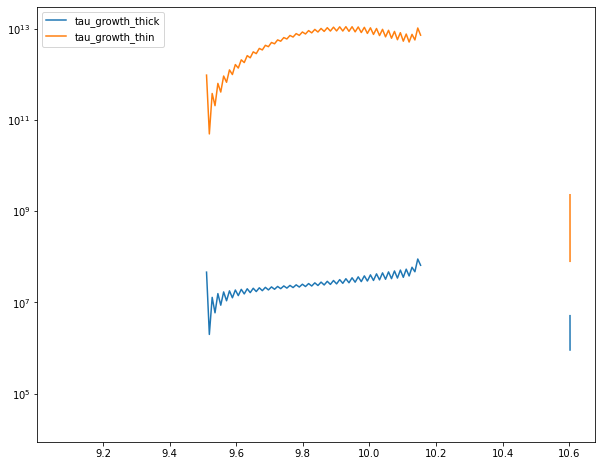

In [50]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_growth_thick, label='tau_growth_thick')
plt.plot(R, tau_growth_thin, label='tau_growth_thin')
#plt.plot(R[RCB], tau_cool[RCB], 'ro')
#plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

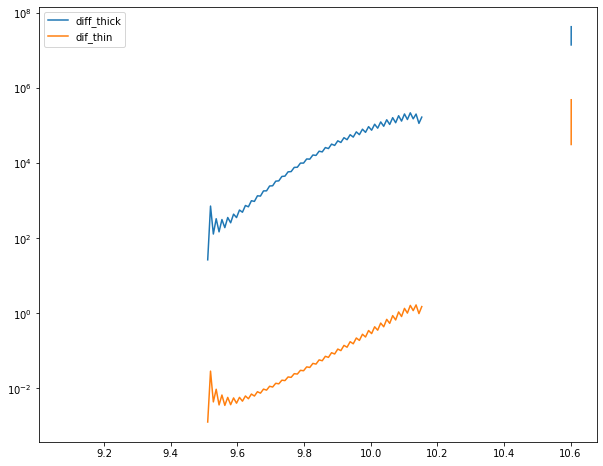

In [51]:
plt.figure(figsize=(10,8))
plt.plot(R,diff_thick, label='diff_thick')
plt.plot(R, diff_thin, label='dif_thin')
#plt.plot(R[RCB], tau_cool[RCB], 'ro')
#plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()

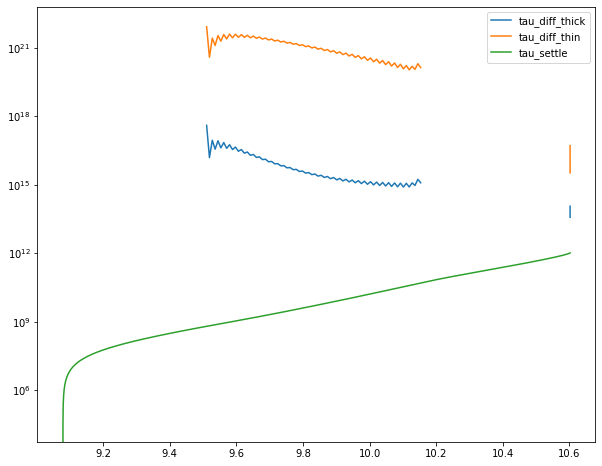

In [52]:
plt.figure(figsize=(10,8))
plt.plot(R,tau_diff_thick, label='tau_diff_thick')
plt.plot(R, tau_diff_thin, label='tau_diff_thin')
plt.plot(R, Tsettl, label='tau_settle')
#plt.plot(R[RCB], tau_cool[RCB], 'ro')
#plt.plot(R[RCB], tau_cool_thin[RCB], 'ro')
plt.yscale('log')
plt.legend()
plt.show()


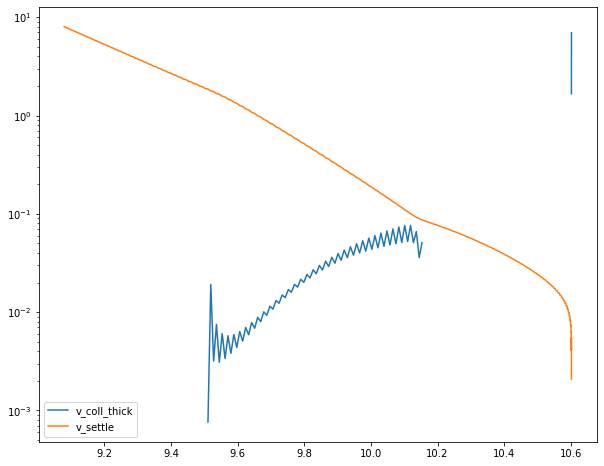

In [53]:
plt.figure(figsize=(10,8))
plt.plot(R,v_coll_thick, label='v_coll_thick')
plt.plot(R,Vset, label='v_settle')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

# New section Oct 14 (using a new optically thin expression for finger size + optically-thin cooling time)

In [54]:
new_d_finger = np.sqrt(nu_visc / Nth**2 / tau_cool_thin)

# Growth time of fingers 
#new_tau_growth_thin  = np.sqrt(Prandtl) * tau_cool_thin
new_tau_growth_thin  = 1./np.sqrt(Prandtl/R_0) * tau_cool_thin

# Diffusion coeff from fingers 
new_diff_thin = new_d_finger**2 / new_tau_growth_thin

# Local Diffusion time from fingers 
new_tau_diff_thin = (10**R)**2 / new_diff_thin

# Collision velocity
new_v_coll = new_d_finger / new_tau_growth_thin

<ipython-input-54-93ceda7b252a>:5: RuntimeWarning: invalid value encountered in sqrt
  new_tau_growth_thin  = 1./np.sqrt(Prandtl/R_0) * tau_cool_thin


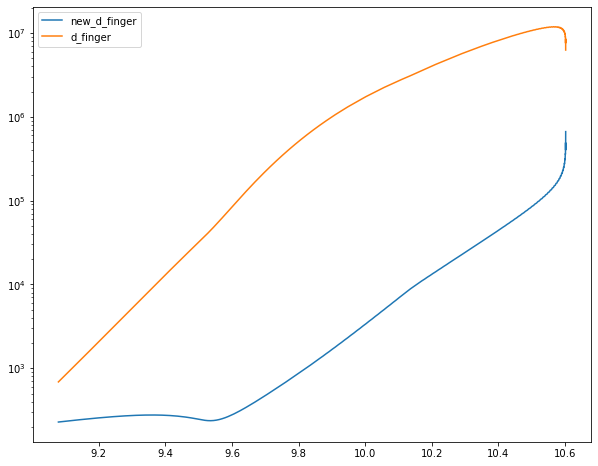

In [55]:
plt.figure(figsize=(10,8))
plt.plot(R,new_d_finger, label='new_d_finger')
plt.plot(R,d_finger, label='d_finger')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

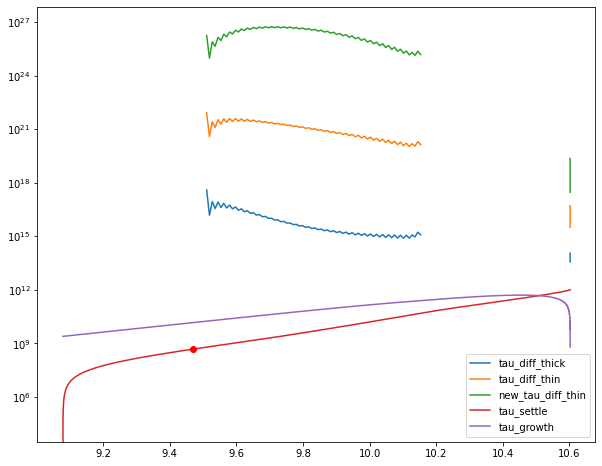

In [56]:
plt.figure(figsize=(10,8))
plt.plot(R, tau_diff_thick, label='tau_diff_thick')
plt.plot(R, tau_diff_thin, label='tau_diff_thin')
plt.plot(R, new_tau_diff_thin, label='new_tau_diff_thin')
plt.plot(R, Tsettl, label='tau_settle')
plt.plot(R, TGrow['g'], label='tau_growth')
plt.plot(R[RCB], Tsettl[RCB], 'ro')

plt.yscale('log')
plt.legend()
plt.show()

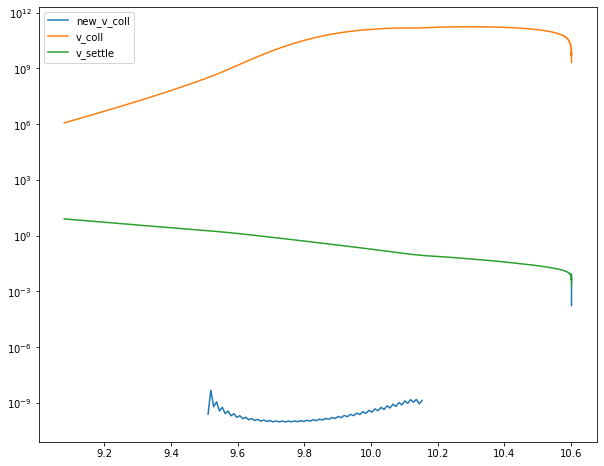

In [57]:
plt.figure(figsize=(10,8))
plt.plot(R,new_v_coll, label='new_v_coll')
plt.plot(R,v_coll, label='v_coll')
plt.plot(R,Vset, label='v_settle')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

# New section Oct 26: fingers must be larger to cool more slowly.

# Just make fingers larger for slower cooling time (to avoid viscous dissipation), keep all other scalings as original Brown+ theory

In [58]:
# From: tau_cool = d_finger**2/xi_rad
d_finger_eff = np.sqrt(xi_rad * tau_cool_thin)

# 

tau_cool_eff = tau_cool_thin # effective cooling time is tau_cool_thin

# Then use all optically thick formalism with d_finger_eff (cooling time is now thin one):

# Growth time of fingers 
#tau_growth_eff =  tau_cool_eff
tau_growth_eff = 1./np.sqrt(Prandtl) * tau_cool_eff
#tau_growth_eff = 1./np.sqrt(Prandtl / R_0) * tau_cool_eff  

# Diffusion coeff from fingers 
diff_eff = d_finger_eff**2 / tau_growth_eff

#diff_theory = np.sqrt(xi_rad**2 * Prandtl)
#diff_eff = diff_theory

# Local Diffusion time from fingers 
tau_diff_eff = (10**R)**2 / diff_eff 

# Velocity collision
v_coll_eff = d_finger_eff / tau_growth_eff

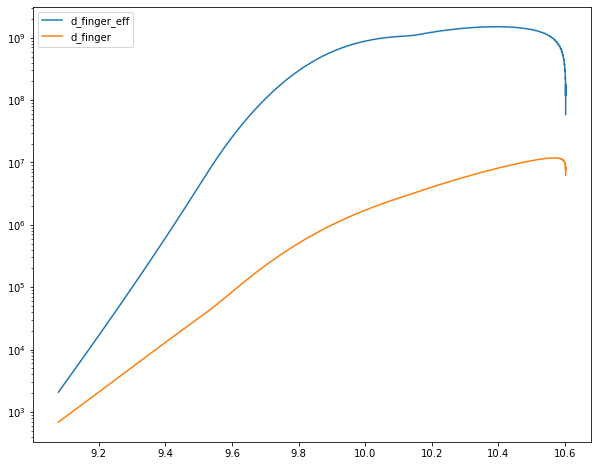

In [59]:
plt.figure(figsize=(10,8))
plt.plot(R,d_finger_eff, label='d_finger_eff')
plt.plot(R,d_finger, label='d_finger')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()


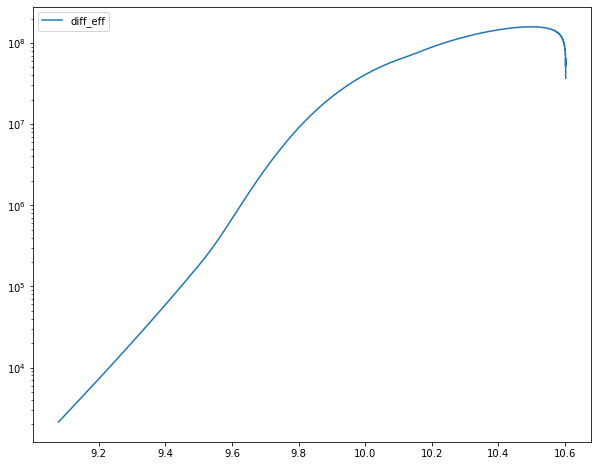

In [60]:
plt.figure(figsize=(10,8))
plt.plot(R,diff_eff, label='diff_eff')
#plt.plot(R,d_finger, label='d_finger')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()


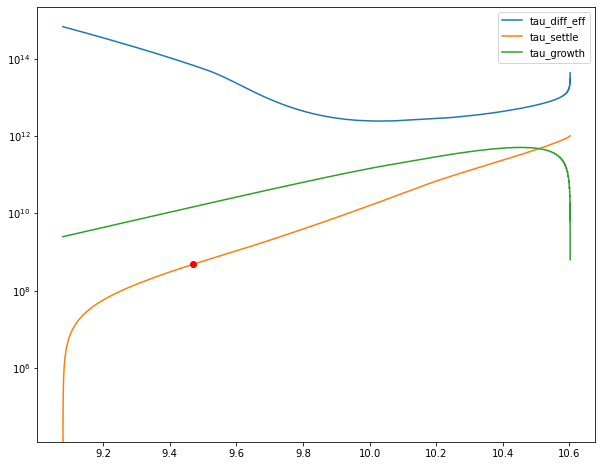

In [61]:
plt.figure(figsize=(10,8))
plt.plot(R, tau_diff_eff, label='tau_diff_eff')
plt.plot(R, Tsettl, label='tau_settle')
plt.plot(R, TGrow['g'], label='tau_growth')
plt.plot(R[RCB], Tsettl[RCB], 'ro')

plt.yscale('log')
plt.legend()
plt.show()

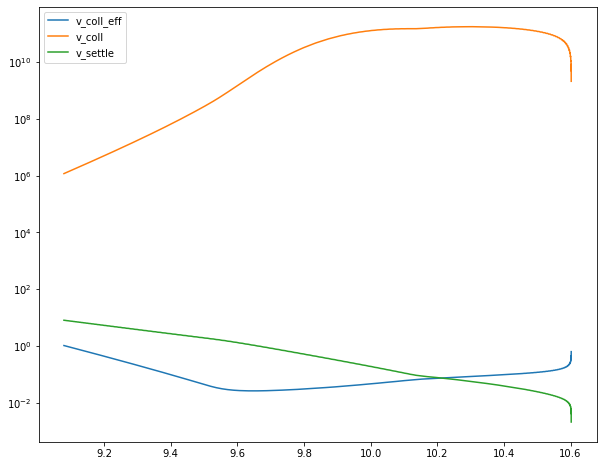

In [62]:
plt.figure(figsize=(10,8))
plt.plot(R,v_coll_eff, label='v_coll_eff')
plt.plot(R,v_coll, label='v_coll')
plt.plot(R,Vset, label='v_settle')
#plt.plot(R[RCB], d_finger[RCB], 'ro')
#plt.title('d_finger')
plt.yscale('log')
plt.legend()
plt.show()

# New section Oct 27: Stern number from Brown + 2013

In [63]:
# We use intermediate regime Tau,Prandtl << r << 1. Eqns 36 & 37 of Brown+ 

X_mu =1.0e0 # reduction factor for compositional of dust, relative to viscosity
Prandtl_mu = X_mu * Prandtl # written Tau in Brown : ratio of compositional diffusion to thermal diffusion
r_Brown = (R_0 -1) / (1./Prandtl_mu - 1)


C = 7.0 # Calibration constant

Nusselt_T = 1 + C**2 * Prandtl * Prandtl_mu * (1 + Prandtl_mu / Prandtl) / r_Brown
Nusselt_mu = 1 + C**2 * np.sqrt(Prandtl / Prandtl_mu) * np.sqrt((1 + Prandtl_mu / Prandtl) / r_Brown)

<ipython-input-63-f1b807cc0ac1>:11: RuntimeWarning: invalid value encountered in sqrt
  Nusselt_mu = 1 + C**2 * np.sqrt(Prandtl / Prandtl_mu) * np.sqrt((1 + Prandtl_mu / Prandtl) / r_Brown)


In [64]:
# Stern number A

gamma_turb = R_0 * (Nusselt_T -1) /  (Nusselt_mu -1) / Prandtl_mu
A = (Nusselt_T -1) * (1./gamma_turb -1) / Prandtl / (1 - 1./R_0)

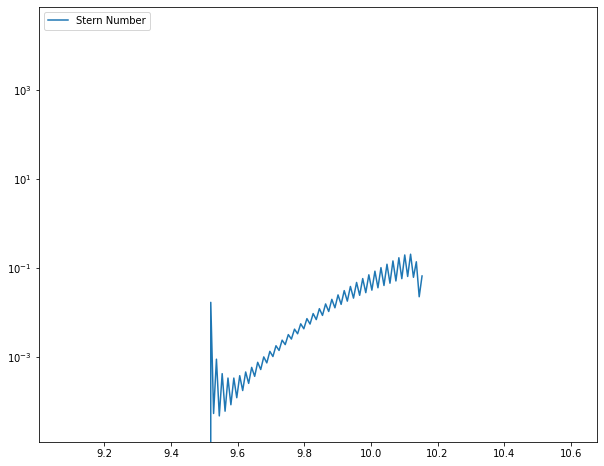

In [65]:
plt.figure(figsize=(10,8))
plt.plot(R,A, label='Stern Number')

plt.yscale('log')
plt.legend()
plt.show()

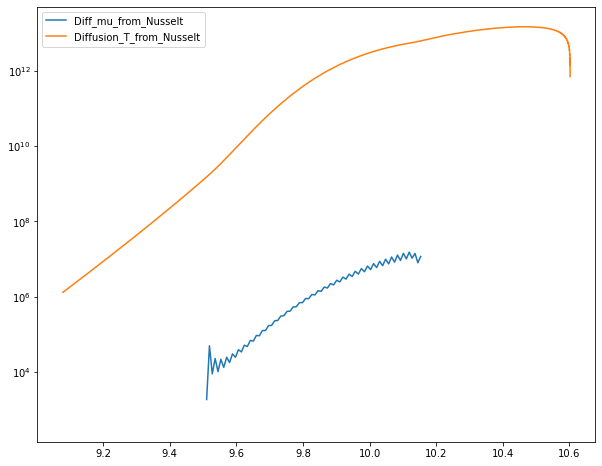

In [66]:
plt.figure(figsize=(10,8))
plt.plot(R,Nusselt_mu * Prandtl * xi_rad , label='Diff_mu_from_Nusselt')
plt.plot(R,Nusselt_T * xi_rad, label='Diffusion_T_from_Nusselt')
plt.yscale('log')
plt.legend()
plt.show()